In [2]:
!python -V

Python 3.9.12


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")

# checks if this experiment is present or creates it and assigns all the runs to this experiment
mlflow.set_experiment("nyc-taxi-experiment")

2025/10/09 10:48:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/09 10:48:36 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1759405959862, experiment_id='1', last_update_time=1759405959862, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_78360/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_78360/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


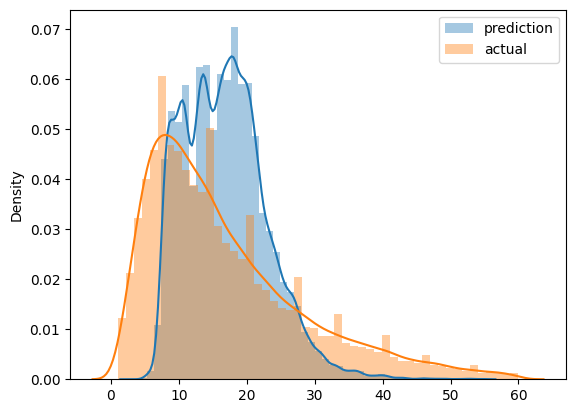

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
#tracking variables like alpha
with mlflow.start_run():
    #logging information about this run
    mlflow.set_tag("developer","Sneha")
    
    mlflow.log_param("train-data-path","../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path","../data/green_tripdata_2021-02.parquet")
    alpha=0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse=root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

In [19]:
import xgboost as xgb

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
#Ranges to perform hyperparameter testing

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# max iterations are 50
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:59:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68912                                                                                                                                  
[1]	validation-rmse:11.20883                                                                                                                                  
[2]	validation-rmse:10.76946                                                                                                                                  
[3]	validation-rmse:10.36786                                                                                                                                  
[4]	validation-rmse:10.00154                                                                                                                                  
[5]	validation-rmse:9.66808                                                                                                                                   
[6]	validation-rmse:9.36510                   

[51]	validation-rmse:6.57658                                                                                                                                  
[52]	validation-rmse:6.57274                                                                                                                                  
[53]	validation-rmse:6.56919                                                                                                                                  
[54]	validation-rmse:6.56570                                                                                                                                  
[55]	validation-rmse:6.56238                                                                                                                                  
[56]	validation-rmse:6.55932                                                                                                                                  
[57]	validation-rmse:6.55662                  

[102]	validation-rmse:6.50033                                                                                                                                 
[103]	validation-rmse:6.50004                                                                                                                                 
[104]	validation-rmse:6.49951                                                                                                                                 
[105]	validation-rmse:6.49907                                                                                                                                 
[106]	validation-rmse:6.49860                                                                                                                                 
[107]	validation-rmse:6.49818                                                                                                                                 
[108]	validation-rmse:6.49775                 

[153]	validation-rmse:6.48404                                                                                                                                 
[154]	validation-rmse:6.48373                                                                                                                                 
[155]	validation-rmse:6.48341                                                                                                                                 
[156]	validation-rmse:6.48324                                                                                                                                 
[157]	validation-rmse:6.48303                                                                                                                                 
[158]	validation-rmse:6.48271                                                                                                                                 
[159]	validation-rmse:6.48243                 

[204]	validation-rmse:6.47386                                                                                                                                 
[205]	validation-rmse:6.47370                                                                                                                                 
[206]	validation-rmse:6.47348                                                                                                                                 
[207]	validation-rmse:6.47307                                                                                                                                 
[208]	validation-rmse:6.47286                                                                                                                                 
[209]	validation-rmse:6.47255                                                                                                                                 
[210]	validation-rmse:6.47215                 

[255]	validation-rmse:6.46539                                                                                                                                 
[256]	validation-rmse:6.46527                                                                                                                                 
[257]	validation-rmse:6.46517                                                                                                                                 
[258]	validation-rmse:6.46501                                                                                                                                 
[259]	validation-rmse:6.46493                                                                                                                                 
[260]	validation-rmse:6.46477                                                                                                                                 
[261]	validation-rmse:6.46467                 

[306]	validation-rmse:6.45997                                                                                                                                 
[307]	validation-rmse:6.45977                                                                                                                                 
[308]	validation-rmse:6.45970                                                                                                                                 
[309]	validation-rmse:6.45948                                                                                                                                 
[310]	validation-rmse:6.45938                                                                                                                                 
[311]	validation-rmse:6.45933                                                                                                                                 
[312]	validation-rmse:6.45924                 

[357]	validation-rmse:6.45454                                                                                                                                 
[358]	validation-rmse:6.45435                                                                                                                                 
[359]	validation-rmse:6.45411                                                                                                                                 
[360]	validation-rmse:6.45409                                                                                                                                 
[361]	validation-rmse:6.45394                                                                                                                                 
[362]	validation-rmse:6.45386                                                                                                                                 
[363]	validation-rmse:6.45378                 

[408]	validation-rmse:6.45038                                                                                                                                 
[409]	validation-rmse:6.45028                                                                                                                                 
[410]	validation-rmse:6.45022                                                                                                                                 
[411]	validation-rmse:6.45020                                                                                                                                 
[412]	validation-rmse:6.45018                                                                                                                                 
[413]	validation-rmse:6.45012                                                                                                                                 
[414]	validation-rmse:6.45011                 

[459]	validation-rmse:6.44725                                                                                                                                 
[460]	validation-rmse:6.44702                                                                                                                                 
[461]	validation-rmse:6.44692                                                                                                                                 
[462]	validation-rmse:6.44675                                                                                                                                 
[463]	validation-rmse:6.44666                                                                                                                                 
[464]	validation-rmse:6.44646                                                                                                                                 
[465]	validation-rmse:6.44647                 

[510]	validation-rmse:6.44388                                                                                                                                 
[511]	validation-rmse:6.44376                                                                                                                                 
[512]	validation-rmse:6.44365                                                                                                                                 
[513]	validation-rmse:6.44361                                                                                                                                 
[514]	validation-rmse:6.44361                                                                                                                                 
[515]	validation-rmse:6.44354                                                                                                                                 
[516]	validation-rmse:6.44345                 

[561]	validation-rmse:6.44080                                                                                                                                 
[562]	validation-rmse:6.44076                                                                                                                                 
[563]	validation-rmse:6.44079                                                                                                                                 
[564]	validation-rmse:6.44069                                                                                                                                 
[565]	validation-rmse:6.44063                                                                                                                                 
[566]	validation-rmse:6.44051                                                                                                                                 
[567]	validation-rmse:6.44050                 

[612]	validation-rmse:6.43768                                                                                                                                 
[613]	validation-rmse:6.43762                                                                                                                                 
[614]	validation-rmse:6.43759                                                                                                                                 
[615]	validation-rmse:6.43755                                                                                                                                 
[616]	validation-rmse:6.43745                                                                                                                                 
[617]	validation-rmse:6.43734                                                                                                                                 
[618]	validation-rmse:6.43730                 

[663]	validation-rmse:6.43541                                                                                                                                 
[664]	validation-rmse:6.43538                                                                                                                                 
[665]	validation-rmse:6.43540                                                                                                                                 
[666]	validation-rmse:6.43540                                                                                                                                 
[667]	validation-rmse:6.43532                                                                                                                                 
[668]	validation-rmse:6.43532                                                                                                                                 
[669]	validation-rmse:6.43530                 

[714]	validation-rmse:6.43366                                                                                                                                 
[715]	validation-rmse:6.43360                                                                                                                                 
[716]	validation-rmse:6.43352                                                                                                                                 
[717]	validation-rmse:6.43349                                                                                                                                 
[718]	validation-rmse:6.43351                                                                                                                                 
[719]	validation-rmse:6.43352                                                                                                                                 
[720]	validation-rmse:6.43337                 

[765]	validation-rmse:6.43176                                                                                                                                 
[766]	validation-rmse:6.43173                                                                                                                                 
[767]	validation-rmse:6.43164                                                                                                                                 
[768]	validation-rmse:6.43161                                                                                                                                 
[769]	validation-rmse:6.43161                                                                                                                                 
[770]	validation-rmse:6.43155                                                                                                                                 
[771]	validation-rmse:6.43156                 

[816]	validation-rmse:6.43013                                                                                                                                 
[817]	validation-rmse:6.43009                                                                                                                                 
[818]	validation-rmse:6.43006                                                                                                                                 
[819]	validation-rmse:6.43008                                                                                                                                 
[820]	validation-rmse:6.43005                                                                                                                                 
[821]	validation-rmse:6.43002                                                                                                                                 
[822]	validation-rmse:6.42996                 

[867]	validation-rmse:6.42846                                                                                                                                 
[868]	validation-rmse:6.42842                                                                                                                                 
[869]	validation-rmse:6.42841                                                                                                                                 
[870]	validation-rmse:6.42835                                                                                                                                 
[871]	validation-rmse:6.42832                                                                                                                                 
[872]	validation-rmse:6.42824                                                                                                                                 
[873]	validation-rmse:6.42816                 

[918]	validation-rmse:6.42638                                                                                                                                 
[919]	validation-rmse:6.42632                                                                                                                                 
[920]	validation-rmse:6.42631                                                                                                                                 
[921]	validation-rmse:6.42629                                                                                                                                 
[922]	validation-rmse:6.42626                                                                                                                                 
[923]	validation-rmse:6.42624                                                                                                                                 
[924]	validation-rmse:6.42613                 

[969]	validation-rmse:6.42496                                                                                                                                 
[970]	validation-rmse:6.42493                                                                                                                                 
[971]	validation-rmse:6.42487                                                                                                                                 
[972]	validation-rmse:6.42477                                                                                                                                 
[973]	validation-rmse:6.42474                                                                                                                                 
[974]	validation-rmse:6.42472                                                                                                                                 
[975]	validation-rmse:6.42470                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:03:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16402                                                                                                                                   
[1]	validation-rmse:7.01273                                                                                                                                   
[2]	validation-rmse:6.70485                                                                                                                                   
[3]	validation-rmse:6.60507                                                                                                                                   
[4]	validation-rmse:6.55909                                                                                                                                   
[5]	validation-rmse:6.53770                                                                                                                                   
[6]	validation-rmse:6.51941                   

[51]	validation-rmse:6.44952                                                                                                                                  
[52]	validation-rmse:6.44936                                                                                                                                  
[53]	validation-rmse:6.44919                                                                                                                                  
[54]	validation-rmse:6.44917                                                                                                                                  
[55]	validation-rmse:6.44864                                                                                                                                  
[56]	validation-rmse:6.44851                                                                                                                                  
[57]	validation-rmse:6.44856                  

[102]	validation-rmse:6.43922                                                                                                                                 
[103]	validation-rmse:6.43930                                                                                                                                 
[104]	validation-rmse:6.43899                                                                                                                                 
[105]	validation-rmse:6.43836                                                                                                                                 
[106]	validation-rmse:6.43854                                                                                                                                 
[107]	validation-rmse:6.43899                                                                                                                                 
[108]	validation-rmse:6.43873                 

[153]	validation-rmse:6.43280                                                                                                                                 
[154]	validation-rmse:6.43280                                                                                                                                 
[155]	validation-rmse:6.43238                                                                                                                                 
[156]	validation-rmse:6.43280                                                                                                                                 
[157]	validation-rmse:6.43296                                                                                                                                 
[158]	validation-rmse:6.43291                                                                                                                                 
[159]	validation-rmse:6.43309                 

[204]	validation-rmse:6.43211                                                                                                                                 
[205]	validation-rmse:6.43192                                                                                                                                 
[206]	validation-rmse:6.43216                                                                                                                                 
[207]	validation-rmse:6.43217                                                                                                                                 
[208]	validation-rmse:6.43238                                                                                                                                 
[209]	validation-rmse:6.43247                                                                                                                                 
[210]	validation-rmse:6.43191                 

[255]	validation-rmse:6.43367                                                                                                                                 
[256]	validation-rmse:6.43332                                                                                                                                 
[257]	validation-rmse:6.43380                                                                                                                                 
[258]	validation-rmse:6.43377                                                                                                                                 
[259]	validation-rmse:6.43384                                                                                                                                 
[260]	validation-rmse:6.43381                                                                                                                                 
[261]	validation-rmse:6.43365                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:04:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53006                                                                                                                                  
[1]	validation-rmse:10.92093                                                                                                                                  
[2]	validation-rmse:10.37895                                                                                                                                  
[3]	validation-rmse:9.89715                                                                                                                                   
[4]	validation-rmse:9.47089                                                                                                                                   
[5]	validation-rmse:9.09498                                                                                                                                   
[6]	validation-rmse:8.76399                   

[53]	validation-rmse:6.44612                                                                                                                           
[54]	validation-rmse:6.44325                                                                                                                           
[55]	validation-rmse:6.44069                                                                                                                           
[56]	validation-rmse:6.43936                                                                                                                           
[57]	validation-rmse:6.43768                                                                                                                           
[58]	validation-rmse:6.43624                                                                                                                           
[59]	validation-rmse:6.43498                                                            

[106]	validation-rmse:6.39925                                                                                                                          
[107]	validation-rmse:6.39890                                                                                                                          
[108]	validation-rmse:6.39851                                                                                                                          
[109]	validation-rmse:6.39789                                                                                                                          
[110]	validation-rmse:6.39755                                                                                                                          
[111]	validation-rmse:6.39729                                                                                                                          
[112]	validation-rmse:6.39693                                                           

[159]	validation-rmse:6.38041                                                                                                                          
[160]	validation-rmse:6.38014                                                                                                                          
[161]	validation-rmse:6.37989                                                                                                                          
[162]	validation-rmse:6.37981                                                                                                                          
[163]	validation-rmse:6.37942                                                                                                                          
[164]	validation-rmse:6.37907                                                                                                                          
[165]	validation-rmse:6.37871                                                           

[212]	validation-rmse:6.36788                                                                                                                          
[213]	validation-rmse:6.36766                                                                                                                          
[214]	validation-rmse:6.36753                                                                                                                          
[215]	validation-rmse:6.36745                                                                                                                          
[216]	validation-rmse:6.36729                                                                                                                          
[217]	validation-rmse:6.36705                                                                                                                          
[218]	validation-rmse:6.36651                                                           

[265]	validation-rmse:6.35704                                                                                                                          
[266]	validation-rmse:6.35689                                                                                                                          
[267]	validation-rmse:6.35677                                                                                                                          
[268]	validation-rmse:6.35679                                                                                                                          
[269]	validation-rmse:6.35673                                                                                                                          
[270]	validation-rmse:6.35664                                                                                                                          
[271]	validation-rmse:6.35666                                                           

[318]	validation-rmse:6.35045                                                                                                                          
[319]	validation-rmse:6.35032                                                                                                                          
[320]	validation-rmse:6.35035                                                                                                                          
[321]	validation-rmse:6.35006                                                                                                                          
[322]	validation-rmse:6.34995                                                                                                                          
[323]	validation-rmse:6.34978                                                                                                                          
[324]	validation-rmse:6.34982                                                           

[371]	validation-rmse:6.34524                                                                                                                          
[372]	validation-rmse:6.34516                                                                                                                          
[373]	validation-rmse:6.34524                                                                                                                          
[374]	validation-rmse:6.34514                                                                                                                          
[375]	validation-rmse:6.34499                                                                                                                          
[376]	validation-rmse:6.34490                                                                                                                          
[377]	validation-rmse:6.34469                                                           

[424]	validation-rmse:6.34169                                                                                                                          
[425]	validation-rmse:6.34165                                                                                                                          
[426]	validation-rmse:6.34161                                                                                                                          
[427]	validation-rmse:6.34163                                                                                                                          
[428]	validation-rmse:6.34157                                                                                                                          
[429]	validation-rmse:6.34149                                                                                                                          
[430]	validation-rmse:6.34149                                                           

[477]	validation-rmse:6.33898                                                                                                                          
[478]	validation-rmse:6.33901                                                                                                                          
[479]	validation-rmse:6.33893                                                                                                                          
[480]	validation-rmse:6.33876                                                                                                                          
[481]	validation-rmse:6.33877                                                                                                                          
[482]	validation-rmse:6.33874                                                                                                                          
[483]	validation-rmse:6.33861                                                           

[530]	validation-rmse:6.33671                                                                                                                          
[531]	validation-rmse:6.33671                                                                                                                          
[532]	validation-rmse:6.33672                                                                                                                          
[533]	validation-rmse:6.33665                                                                                                                          
[534]	validation-rmse:6.33674                                                                                                                          
[535]	validation-rmse:6.33679                                                                                                                          
[536]	validation-rmse:6.33679                                                           

[583]	validation-rmse:6.33400                                                                                                                          
[584]	validation-rmse:6.33380                                                                                                                          
[585]	validation-rmse:6.33361                                                                                                                          
[586]	validation-rmse:6.33352                                                                                                                          
[587]	validation-rmse:6.33338                                                                                                                          
[588]	validation-rmse:6.33337                                                                                                                          
[589]	validation-rmse:6.33329                                                           

[636]	validation-rmse:6.33160                                                                                                                          
[637]	validation-rmse:6.33167                                                                                                                          
[638]	validation-rmse:6.33162                                                                                                                          
[639]	validation-rmse:6.33159                                                                                                                          
[640]	validation-rmse:6.33158                                                                                                                          
[641]	validation-rmse:6.33166                                                                                                                          
[642]	validation-rmse:6.33167                                                           

[689]	validation-rmse:6.33137                                                                                                                          
[690]	validation-rmse:6.33143                                                                                                                          
[691]	validation-rmse:6.33139                                                                                                                          
[692]	validation-rmse:6.33136                                                                                                                          
[693]	validation-rmse:6.33137                                                                                                                          
[694]	validation-rmse:6.33141                                                                                                                          
[695]	validation-rmse:6.33135                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:09:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.52122                                                                                                                            
[2]	validation-rmse:7.03508                                                                                                                            
[3]	validation-rmse:6.85522                                                                                                                            
[4]	validation-rmse:6.78147                                                                                                                            
[5]	validation-rmse:6.74397                                                                                                                            
[6]	validation-rmse:6.72673                                                                                                                            
[7]	validation-rmse:6.71469                                                             

[54]	validation-rmse:6.62554                                                                                                                           
[55]	validation-rmse:6.62457                                                                                                                           
[56]	validation-rmse:6.62392                                                                                                                           
[57]	validation-rmse:6.62354                                                                                                                           
[58]	validation-rmse:6.62301                                                                                                                           
[59]	validation-rmse:6.62221                                                                                                                           
[60]	validation-rmse:6.62165                                                            

[107]	validation-rmse:6.59461                                                                                                                          
[108]	validation-rmse:6.59379                                                                                                                          
[109]	validation-rmse:6.59343                                                                                                                          
[110]	validation-rmse:6.59326                                                                                                                          
[111]	validation-rmse:6.59275                                                                                                                          
[112]	validation-rmse:6.59238                                                                                                                          
[113]	validation-rmse:6.59228                                                           

[160]	validation-rmse:6.58164                                                                                                                          
[161]	validation-rmse:6.58134                                                                                                                          
[162]	validation-rmse:6.58099                                                                                                                          
[163]	validation-rmse:6.58081                                                                                                                          
[164]	validation-rmse:6.58056                                                                                                                          
[165]	validation-rmse:6.58049                                                                                                                          
[166]	validation-rmse:6.58048                                                           

[213]	validation-rmse:6.57221                                                                                                                          
[214]	validation-rmse:6.57207                                                                                                                          
[215]	validation-rmse:6.57192                                                                                                                          
[216]	validation-rmse:6.57148                                                                                                                          
[217]	validation-rmse:6.57108                                                                                                                          
[218]	validation-rmse:6.57106                                                                                                                          
[219]	validation-rmse:6.57098                                                           

[266]	validation-rmse:6.56576                                                                                                                          
[267]	validation-rmse:6.56560                                                                                                                          
[268]	validation-rmse:6.56554                                                                                                                          
[269]	validation-rmse:6.56546                                                                                                                          
[270]	validation-rmse:6.56531                                                                                                                          
[271]	validation-rmse:6.56525                                                                                                                          
[272]	validation-rmse:6.56547                                                           

[319]	validation-rmse:6.56157                                                                                                                          
[320]	validation-rmse:6.56161                                                                                                                          
[321]	validation-rmse:6.56151                                                                                                                          
[322]	validation-rmse:6.56146                                                                                                                          
[323]	validation-rmse:6.56136                                                                                                                          
[324]	validation-rmse:6.56119                                                                                                                          
[325]	validation-rmse:6.56102                                                           

[372]	validation-rmse:6.55949                                                                                                                          
[373]	validation-rmse:6.55922                                                                                                                          
[374]	validation-rmse:6.55927                                                                                                                          
[375]	validation-rmse:6.55918                                                                                                                          
[376]	validation-rmse:6.55945                                                                                                                          
[377]	validation-rmse:6.55927                                                                                                                          
[378]	validation-rmse:6.55930                                                           

[425]	validation-rmse:6.55803                                                                                                                          
[426]	validation-rmse:6.55817                                                                                                                          
[427]	validation-rmse:6.55794                                                                                                                          
[428]	validation-rmse:6.55761                                                                                                                          
[429]	validation-rmse:6.55778                                                                                                                          
[430]	validation-rmse:6.55775                                                                                                                          
[431]	validation-rmse:6.55758                                                           

[478]	validation-rmse:6.55578                                                                                                                          
[479]	validation-rmse:6.55585                                                                                                                          
[480]	validation-rmse:6.55577                                                                                                                          
[481]	validation-rmse:6.55557                                                                                                                          
[482]	validation-rmse:6.55555                                                                                                                          
[483]	validation-rmse:6.55565                                                                                                                          
[484]	validation-rmse:6.55548                                                           

[531]	validation-rmse:6.55448                                                                                                                          
[532]	validation-rmse:6.55437                                                                                                                          
[533]	validation-rmse:6.55435                                                                                                                          
[534]	validation-rmse:6.55430                                                                                                                          
[535]	validation-rmse:6.55413                                                                                                                          
[536]	validation-rmse:6.55429                                                                                                                          
[537]	validation-rmse:6.55407                                                           

[584]	validation-rmse:6.55352                                                                                                                          
[585]	validation-rmse:6.55353                                                                                                                          
[586]	validation-rmse:6.55324                                                                                                                          
[587]	validation-rmse:6.55328                                                                                                                          
[588]	validation-rmse:6.55325                                                                                                                          
[589]	validation-rmse:6.55321                                                                                                                          
[590]	validation-rmse:6.55327                                                           

[637]	validation-rmse:6.55136                                                                                                                          
[638]	validation-rmse:6.55104                                                                                                                          
[639]	validation-rmse:6.55099                                                                                                                          
[640]	validation-rmse:6.55090                                                                                                                          
[641]	validation-rmse:6.55072                                                                                                                          
[642]	validation-rmse:6.55080                                                                                                                          
[643]	validation-rmse:6.55080                                                           

[690]	validation-rmse:6.54991                                                                                                                          
[691]	validation-rmse:6.54984                                                                                                                          
[692]	validation-rmse:6.54986                                                                                                                          
[693]	validation-rmse:6.54982                                                                                                                          
[694]	validation-rmse:6.55007                                                                                                                          
[695]	validation-rmse:6.54993                                                                                                                          
[696]	validation-rmse:6.54977                                                           

[743]	validation-rmse:6.54831                                                                                                                          
[744]	validation-rmse:6.54791                                                                                                                          
[745]	validation-rmse:6.54798                                                                                                                          
[746]	validation-rmse:6.54861                                                                                                                          
[747]	validation-rmse:6.54871                                                                                                                          
[748]	validation-rmse:6.54864                                                                                                                          
[749]	validation-rmse:6.54860                                                           

[796]	validation-rmse:6.54788                                                                                                                          
[797]	validation-rmse:6.54778                                                                                                                          
[798]	validation-rmse:6.54774                                                                                                                          
[799]	validation-rmse:6.54769                                                                                                                          
[800]	validation-rmse:6.54754                                                                                                                          
[801]	validation-rmse:6.54768                                                                                                                          
[802]	validation-rmse:6.54758                                                           

[849]	validation-rmse:6.54733                                                                                                                          
[850]	validation-rmse:6.54723                                                                                                                          
[851]	validation-rmse:6.54732                                                                                                                          
[852]	validation-rmse:6.54761                                                                                                                          
[853]	validation-rmse:6.54743                                                                                                                          
[854]	validation-rmse:6.54759                                                                                                                          
[855]	validation-rmse:6.54748                                                           

[902]	validation-rmse:6.54762                                                                                                                          
[903]	validation-rmse:6.54758                                                                                                                          
[904]	validation-rmse:6.54769                                                                                                                          
[905]	validation-rmse:6.54766                                                                                                                          
[906]	validation-rmse:6.54767                                                                                                                          
[907]	validation-rmse:6.54764                                                                                                                          
[908]	validation-rmse:6.54750                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:10:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18340                                                                                                                           
[1]	validation-rmse:8.82840                                                                                                                            
[2]	validation-rmse:7.95108                                                                                                                            
[3]	validation-rmse:7.39565                                                                                                                            
[4]	validation-rmse:7.04950                                                                                                                            
[5]	validation-rmse:6.83583                                                                                                                            
[6]	validation-rmse:6.69783                                                             

[53]	validation-rmse:6.36022                                                                                                                           
[54]	validation-rmse:6.35917                                                                                                                           
[55]	validation-rmse:6.35900                                                                                                                           
[56]	validation-rmse:6.35905                                                                                                                           
[57]	validation-rmse:6.35879                                                                                                                           
[58]	validation-rmse:6.35831                                                                                                                           
[59]	validation-rmse:6.35784                                                            

[106]	validation-rmse:6.33883                                                                                                                          
[107]	validation-rmse:6.33890                                                                                                                          
[108]	validation-rmse:6.33846                                                                                                                          
[109]	validation-rmse:6.33786                                                                                                                          
[110]	validation-rmse:6.33756                                                                                                                          
[111]	validation-rmse:6.33821                                                                                                                          
[112]	validation-rmse:6.33839                                                           

[159]	validation-rmse:6.34061                                                                                                                          
[160]	validation-rmse:6.34035                                                                                                                          
[161]	validation-rmse:6.34113                                                                                                                          
[162]	validation-rmse:6.34081                                                                                                                          
[163]	validation-rmse:6.34046                                                                                                                          
[164]	validation-rmse:6.34075                                                                                                                          
[165]	validation-rmse:6.34103                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:12:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.25068                                                                                                                           
[1]	validation-rmse:8.93742                                                                                                                            
[2]	validation-rmse:8.08379                                                                                                                            
[3]	validation-rmse:7.53981                                                                                                                            
[4]	validation-rmse:7.19931                                                                                                                            
[5]	validation-rmse:6.98573                                                                                                                            
[6]	validation-rmse:6.84823                                                             

[53]	validation-rmse:6.50122                                                                                                                           
[54]	validation-rmse:6.50038                                                                                                                           
[55]	validation-rmse:6.49999                                                                                                                           
[56]	validation-rmse:6.49923                                                                                                                           
[57]	validation-rmse:6.49906                                                                                                                           
[58]	validation-rmse:6.49718                                                                                                                           
[59]	validation-rmse:6.49682                                                            

[106]	validation-rmse:6.47415                                                                                                                          
[107]	validation-rmse:6.47392                                                                                                                          
[108]	validation-rmse:6.47365                                                                                                                          
[109]	validation-rmse:6.47322                                                                                                                          
[110]	validation-rmse:6.47305                                                                                                                          
[111]	validation-rmse:6.47203                                                                                                                          
[112]	validation-rmse:6.47149                                                           

[159]	validation-rmse:6.46312                                                                                                                          
[160]	validation-rmse:6.46298                                                                                                                          
[161]	validation-rmse:6.46276                                                                                                                          
[162]	validation-rmse:6.46256                                                                                                                          
[163]	validation-rmse:6.46245                                                                                                                          
[164]	validation-rmse:6.46228                                                                                                                          
[165]	validation-rmse:6.46202                                                           

[212]	validation-rmse:6.45792                                                                                                                          
[213]	validation-rmse:6.45792                                                                                                                          
[214]	validation-rmse:6.45763                                                                                                                          
[215]	validation-rmse:6.45757                                                                                                                          
[216]	validation-rmse:6.45751                                                                                                                          
[217]	validation-rmse:6.45719                                                                                                                          
[218]	validation-rmse:6.45748                                                           

[265]	validation-rmse:6.45098                                                                                                                          
[266]	validation-rmse:6.45094                                                                                                                          
[267]	validation-rmse:6.45093                                                                                                                          
[268]	validation-rmse:6.45093                                                                                                                          
[269]	validation-rmse:6.45068                                                                                                                          
[270]	validation-rmse:6.45056                                                                                                                          
[271]	validation-rmse:6.45047                                                           

[318]	validation-rmse:6.44687                                                                                                                          
[319]	validation-rmse:6.44695                                                                                                                          
[320]	validation-rmse:6.44689                                                                                                                          
[321]	validation-rmse:6.44649                                                                                                                          
[322]	validation-rmse:6.44649                                                                                                                          
[323]	validation-rmse:6.44657                                                                                                                          
[324]	validation-rmse:6.44667                                                           

[371]	validation-rmse:6.44417                                                                                                                          
[372]	validation-rmse:6.44408                                                                                                                          
[373]	validation-rmse:6.44412                                                                                                                          
[374]	validation-rmse:6.44416                                                                                                                          
[375]	validation-rmse:6.44389                                                                                                                          
[376]	validation-rmse:6.44406                                                                                                                          
[377]	validation-rmse:6.44364                                                           

[424]	validation-rmse:6.44254                                                                                                                          
[425]	validation-rmse:6.44251                                                                                                                          
[426]	validation-rmse:6.44252                                                                                                                          
[427]	validation-rmse:6.44253                                                                                                                          
[428]	validation-rmse:6.44250                                                                                                                          
[429]	validation-rmse:6.44262                                                                                                                          
[430]	validation-rmse:6.44243                                                           

[477]	validation-rmse:6.44049                                                                                                                          
[478]	validation-rmse:6.44043                                                                                                                          
[479]	validation-rmse:6.44047                                                                                                                          
[480]	validation-rmse:6.44040                                                                                                                          
[481]	validation-rmse:6.44038                                                                                                                          
[482]	validation-rmse:6.44044                                                                                                                          
[483]	validation-rmse:6.44030                                                           

[530]	validation-rmse:6.43912                                                                                                                          
[531]	validation-rmse:6.43921                                                                                                                          
[532]	validation-rmse:6.43931                                                                                                                          
[533]	validation-rmse:6.43919                                                                                                                          
[534]	validation-rmse:6.43908                                                                                                                          
[535]	validation-rmse:6.43916                                                                                                                          
[536]	validation-rmse:6.43924                                                           

[583]	validation-rmse:6.43776                                                                                                                          
[584]	validation-rmse:6.43751                                                                                                                          
[585]	validation-rmse:6.43763                                                                                                                          
[586]	validation-rmse:6.43757                                                                                                                          
[587]	validation-rmse:6.43753                                                                                                                          
[588]	validation-rmse:6.43765                                                                                                                          
[589]	validation-rmse:6.43785                                                           

[636]	validation-rmse:6.43718                                                                                                                          
[637]	validation-rmse:6.43718                                                                                                                          
[638]	validation-rmse:6.43727                                                                                                                          
[639]	validation-rmse:6.43733                                                                                                                          
[640]	validation-rmse:6.43732                                                                                                                          
[641]	validation-rmse:6.43725                                                                                                                          
[642]	validation-rmse:6.43712                                                           

[689]	validation-rmse:6.43666                                                                                                                          
[690]	validation-rmse:6.43673                                                                                                                          
[691]	validation-rmse:6.43673                                                                                                                          
[692]	validation-rmse:6.43664                                                                                                                          
[693]	validation-rmse:6.43648                                                                                                                          
[694]	validation-rmse:6.43654                                                                                                                          
[695]	validation-rmse:6.43655                                                           

[742]	validation-rmse:6.43770                                                                                                                          
 12%|█████████▍                                                                     | 6/50 [14:39<1:36:29, 131.59s/trial, best loss: 6.331351671844976]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:14:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66151                                                                                                                            
[1]	validation-rmse:7.35915                                                                                                                            
[2]	validation-rmse:6.91294                                                                                                                            
[3]	validation-rmse:6.75261                                                                                                                            
[4]	validation-rmse:6.68481                                                                                                                            
[5]	validation-rmse:6.65146                                                                                                                            
[6]	validation-rmse:6.63181                                                             

[53]	validation-rmse:6.50845                                                                                                                           
[54]	validation-rmse:6.50764                                                                                                                           
[55]	validation-rmse:6.50551                                                                                                                           
[56]	validation-rmse:6.50435                                                                                                                           
[57]	validation-rmse:6.50392                                                                                                                           
[58]	validation-rmse:6.50369                                                                                                                           
[59]	validation-rmse:6.50319                                                            

[106]	validation-rmse:6.46316                                                                                                                          
[107]	validation-rmse:6.46226                                                                                                                          
[108]	validation-rmse:6.46123                                                                                                                          
[109]	validation-rmse:6.46006                                                                                                                          
[110]	validation-rmse:6.46046                                                                                                                          
[111]	validation-rmse:6.45892                                                                                                                          
[112]	validation-rmse:6.45852                                                           

[159]	validation-rmse:6.44221                                                                                                                          
[160]	validation-rmse:6.44205                                                                                                                          
[161]	validation-rmse:6.44225                                                                                                                          
[162]	validation-rmse:6.44214                                                                                                                          
[163]	validation-rmse:6.44203                                                                                                                          
[164]	validation-rmse:6.44127                                                                                                                          
[165]	validation-rmse:6.44076                                                           

[212]	validation-rmse:6.43328                                                                                                                          
[213]	validation-rmse:6.43438                                                                                                                          
[214]	validation-rmse:6.43418                                                                                                                          
[215]	validation-rmse:6.43507                                                                                                                          
[216]	validation-rmse:6.43532                                                                                                                          
[217]	validation-rmse:6.43540                                                                                                                          
[218]	validation-rmse:6.43558                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:15:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46528                                                                                                                           
[1]	validation-rmse:10.80971                                                                                                                           
[2]	validation-rmse:10.23701                                                                                                                           
[3]	validation-rmse:9.73809                                                                                                                            
[4]	validation-rmse:9.30541                                                                                                                            
[5]	validation-rmse:8.93125                                                                                                                            
[6]	validation-rmse:8.60897                                                             

[53]	validation-rmse:6.68433                                                                                                                           
[54]	validation-rmse:6.68357                                                                                                                           
[55]	validation-rmse:6.68261                                                                                                                           
[56]	validation-rmse:6.68186                                                                                                                           
[57]	validation-rmse:6.68123                                                                                                                           
[58]	validation-rmse:6.68028                                                                                                                           
[59]	validation-rmse:6.67964                                                            

[106]	validation-rmse:6.65544                                                                                                                          
[107]	validation-rmse:6.65460                                                                                                                          
[108]	validation-rmse:6.65440                                                                                                                          
[109]	validation-rmse:6.65403                                                                                                                          
[110]	validation-rmse:6.65377                                                                                                                          
[111]	validation-rmse:6.65344                                                                                                                          
[112]	validation-rmse:6.65308                                                           

[159]	validation-rmse:6.63903                                                                                                                          
[160]	validation-rmse:6.63877                                                                                                                          
[161]	validation-rmse:6.63861                                                                                                                          
[162]	validation-rmse:6.63833                                                                                                                          
[163]	validation-rmse:6.63816                                                                                                                          
[164]	validation-rmse:6.63801                                                                                                                          
[165]	validation-rmse:6.63776                                                           

[212]	validation-rmse:6.62713                                                                                                                          
[213]	validation-rmse:6.62691                                                                                                                          
[214]	validation-rmse:6.62669                                                                                                                          
[215]	validation-rmse:6.62661                                                                                                                          
[216]	validation-rmse:6.62652                                                                                                                          
[217]	validation-rmse:6.62627                                                                                                                          
[218]	validation-rmse:6.62611                                                           

[265]	validation-rmse:6.61756                                                                                                                          
[266]	validation-rmse:6.61745                                                                                                                          
[267]	validation-rmse:6.61736                                                                                                                          
[268]	validation-rmse:6.61727                                                                                                                          
[269]	validation-rmse:6.61720                                                                                                                          
[270]	validation-rmse:6.61710                                                                                                                          
[271]	validation-rmse:6.61686                                                           

[318]	validation-rmse:6.61002                                                                                                                          
[319]	validation-rmse:6.60989                                                                                                                          
[320]	validation-rmse:6.60970                                                                                                                          
[321]	validation-rmse:6.60965                                                                                                                          
[322]	validation-rmse:6.60966                                                                                                                          
[323]	validation-rmse:6.60936                                                                                                                          
[324]	validation-rmse:6.60926                                                           

[371]	validation-rmse:6.60336                                                                                                                          
[372]	validation-rmse:6.60329                                                                                                                          
[373]	validation-rmse:6.60321                                                                                                                          
[374]	validation-rmse:6.60316                                                                                                                          
[375]	validation-rmse:6.60305                                                                                                                          
[376]	validation-rmse:6.60300                                                                                                                          
[377]	validation-rmse:6.60286                                                           

[424]	validation-rmse:6.59865                                                                                                                          
[425]	validation-rmse:6.59849                                                                                                                          
[426]	validation-rmse:6.59836                                                                                                                          
[427]	validation-rmse:6.59833                                                                                                                          
[428]	validation-rmse:6.59823                                                                                                                          
[429]	validation-rmse:6.59810                                                                                                                          
[430]	validation-rmse:6.59803                                                           

[477]	validation-rmse:6.59308                                                                                                                          
[478]	validation-rmse:6.59301                                                                                                                          
[479]	validation-rmse:6.59302                                                                                                                          
[480]	validation-rmse:6.59300                                                                                                                          
[481]	validation-rmse:6.59297                                                                                                                          
[482]	validation-rmse:6.59291                                                                                                                          
[483]	validation-rmse:6.59292                                                           

[530]	validation-rmse:6.58975                                                                                                                          
[531]	validation-rmse:6.58966                                                                                                                          
[532]	validation-rmse:6.58957                                                                                                                          
[533]	validation-rmse:6.58951                                                                                                                          
[534]	validation-rmse:6.58959                                                                                                                          
[535]	validation-rmse:6.58949                                                                                                                          
[536]	validation-rmse:6.58945                                                           

[583]	validation-rmse:6.58694                                                                                                                          
[584]	validation-rmse:6.58689                                                                                                                          
[585]	validation-rmse:6.58689                                                                                                                          
[586]	validation-rmse:6.58688                                                                                                                          
[587]	validation-rmse:6.58681                                                                                                                          
[588]	validation-rmse:6.58674                                                                                                                          
[589]	validation-rmse:6.58671                                                           

[636]	validation-rmse:6.58426                                                                                                                          
[637]	validation-rmse:6.58426                                                                                                                          
[638]	validation-rmse:6.58426                                                                                                                          
[639]	validation-rmse:6.58420                                                                                                                          
[640]	validation-rmse:6.58408                                                                                                                          
[641]	validation-rmse:6.58404                                                                                                                          
[642]	validation-rmse:6.58397                                                           

[689]	validation-rmse:6.58131                                                                                                                          
[690]	validation-rmse:6.58126                                                                                                                          
[691]	validation-rmse:6.58116                                                                                                                          
[692]	validation-rmse:6.58108                                                                                                                          
[693]	validation-rmse:6.58100                                                                                                                          
[694]	validation-rmse:6.58096                                                                                                                          
[695]	validation-rmse:6.58089                                                           

[742]	validation-rmse:6.57831                                                                                                                          
[743]	validation-rmse:6.57832                                                                                                                          
[744]	validation-rmse:6.57829                                                                                                                          
[745]	validation-rmse:6.57829                                                                                                                          
[746]	validation-rmse:6.57826                                                                                                                          
[747]	validation-rmse:6.57819                                                                                                                          
[748]	validation-rmse:6.57816                                                           

[795]	validation-rmse:6.57680                                                                                                                          
[796]	validation-rmse:6.57675                                                                                                                          
[797]	validation-rmse:6.57670                                                                                                                          
[798]	validation-rmse:6.57670                                                                                                                          
[799]	validation-rmse:6.57674                                                                                                                          
[800]	validation-rmse:6.57674                                                                                                                          
[801]	validation-rmse:6.57677                                                           

[848]	validation-rmse:6.57245                                                                                                                          
[849]	validation-rmse:6.57238                                                                                                                          
[850]	validation-rmse:6.57234                                                                                                                          
[851]	validation-rmse:6.57233                                                                                                                          
[852]	validation-rmse:6.57201                                                                                                                          
[853]	validation-rmse:6.57198                                                                                                                          
[854]	validation-rmse:6.57199                                                           

[901]	validation-rmse:6.57063                                                                                                                          
[902]	validation-rmse:6.57059                                                                                                                          
[903]	validation-rmse:6.57058                                                                                                                          
[904]	validation-rmse:6.57042                                                                                                                          
[905]	validation-rmse:6.57042                                                                                                                          
[906]	validation-rmse:6.57043                                                                                                                          
[907]	validation-rmse:6.57047                                                           

[954]	validation-rmse:6.56867                                                                                                                          
[955]	validation-rmse:6.56863                                                                                                                          
[956]	validation-rmse:6.56861                                                                                                                          
[957]	validation-rmse:6.56858                                                                                                                          
[958]	validation-rmse:6.56857                                                                                                                          
[959]	validation-rmse:6.56851                                                                                                                          
[960]	validation-rmse:6.56853                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:16:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10881                                                                                                                           
[1]	validation-rmse:10.20363                                                                                                                           
[2]	validation-rmse:9.46417                                                                                                                            
[3]	validation-rmse:8.86574                                                                                                                            
[4]	validation-rmse:8.38658                                                                                                                            
[5]	validation-rmse:8.00289                                                                                                                            
[6]	validation-rmse:7.70110                                                             

[53]	validation-rmse:6.45512                                                                                                                           
[54]	validation-rmse:6.45390                                                                                                                           
[55]	validation-rmse:6.45298                                                                                                                           
[56]	validation-rmse:6.45197                                                                                                                           
[57]	validation-rmse:6.45127                                                                                                                           
[58]	validation-rmse:6.45011                                                                                                                           
[59]	validation-rmse:6.44936                                                            

[106]	validation-rmse:6.41072                                                                                                                          
[107]	validation-rmse:6.40989                                                                                                                          
[108]	validation-rmse:6.40930                                                                                                                          
[109]	validation-rmse:6.40818                                                                                                                          
[110]	validation-rmse:6.40740                                                                                                                          
[111]	validation-rmse:6.40707                                                                                                                          
[112]	validation-rmse:6.40563                                                           

[159]	validation-rmse:6.38254                                                                                                                          
[160]	validation-rmse:6.38186                                                                                                                          
[161]	validation-rmse:6.38148                                                                                                                          
[162]	validation-rmse:6.38084                                                                                                                          
[163]	validation-rmse:6.38023                                                                                                                          
[164]	validation-rmse:6.37986                                                                                                                          
[165]	validation-rmse:6.37920                                                           

[212]	validation-rmse:6.36372                                                                                                                          
[213]	validation-rmse:6.36324                                                                                                                          
[214]	validation-rmse:6.36304                                                                                                                          
[215]	validation-rmse:6.36290                                                                                                                          
[216]	validation-rmse:6.36287                                                                                                                          
[217]	validation-rmse:6.36249                                                                                                                          
[218]	validation-rmse:6.36210                                                           

[265]	validation-rmse:6.34895                                                                                                                          
[266]	validation-rmse:6.34851                                                                                                                          
[267]	validation-rmse:6.34822                                                                                                                          
[268]	validation-rmse:6.34803                                                                                                                          
[269]	validation-rmse:6.34796                                                                                                                          
[270]	validation-rmse:6.34794                                                                                                                          
[271]	validation-rmse:6.34774                                                           

[318]	validation-rmse:6.33801                                                                                                                          
[319]	validation-rmse:6.33773                                                                                                                          
[320]	validation-rmse:6.33745                                                                                                                          
[321]	validation-rmse:6.33727                                                                                                                          
[322]	validation-rmse:6.33725                                                                                                                          
[323]	validation-rmse:6.33709                                                                                                                          
[324]	validation-rmse:6.33687                                                           

[371]	validation-rmse:6.32991                                                                                                                          
[372]	validation-rmse:6.32973                                                                                                                          
[373]	validation-rmse:6.32951                                                                                                                          
[374]	validation-rmse:6.32961                                                                                                                          
[375]	validation-rmse:6.32956                                                                                                                          
[376]	validation-rmse:6.32944                                                                                                                          
[377]	validation-rmse:6.32931                                                           

[424]	validation-rmse:6.32276                                                                                                                          
[425]	validation-rmse:6.32269                                                                                                                          
[426]	validation-rmse:6.32239                                                                                                                          
[427]	validation-rmse:6.32247                                                                                                                          
[428]	validation-rmse:6.32230                                                                                                                          
[429]	validation-rmse:6.32220                                                                                                                          
[430]	validation-rmse:6.32222                                                           

[477]	validation-rmse:6.31772                                                                                                                          
[478]	validation-rmse:6.31767                                                                                                                          
[479]	validation-rmse:6.31746                                                                                                                          
[480]	validation-rmse:6.31741                                                                                                                          
[481]	validation-rmse:6.31724                                                                                                                          
[482]	validation-rmse:6.31739                                                                                                                          
[483]	validation-rmse:6.31734                                                           

[530]	validation-rmse:6.31287                                                                                                                          
[531]	validation-rmse:6.31292                                                                                                                          
[532]	validation-rmse:6.31234                                                                                                                          
[533]	validation-rmse:6.31282                                                                                                                          
[534]	validation-rmse:6.31272                                                                                                                          
[535]	validation-rmse:6.31255                                                                                                                          
[536]	validation-rmse:6.31254                                                           

[583]	validation-rmse:6.31036                                                                                                                          
[584]	validation-rmse:6.31019                                                                                                                          
[585]	validation-rmse:6.31024                                                                                                                          
[586]	validation-rmse:6.31028                                                                                                                          
[587]	validation-rmse:6.31028                                                                                                                          
[588]	validation-rmse:6.31005                                                                                                                          
[589]	validation-rmse:6.31001                                                           

[636]	validation-rmse:6.30868                                                                                                                          
[637]	validation-rmse:6.30869                                                                                                                          
[638]	validation-rmse:6.30866                                                                                                                          
[639]	validation-rmse:6.30884                                                                                                                          
[640]	validation-rmse:6.30887                                                                                                                          
[641]	validation-rmse:6.30885                                                                                                                          
[642]	validation-rmse:6.30865                                                           

[689]	validation-rmse:6.30650                                                                                                                          
[690]	validation-rmse:6.30670                                                                                                                          
[691]	validation-rmse:6.30653                                                                                                                          
[692]	validation-rmse:6.30657                                                                                                                          
[693]	validation-rmse:6.30652                                                                                                                          
[694]	validation-rmse:6.30664                                                                                                                          
[695]	validation-rmse:6.30655                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:19:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.09452                                                                                                                            
[1]	validation-rmse:7.02836                                                                                                                            
[2]	validation-rmse:6.74428                                                                                                                            
[3]	validation-rmse:6.65575                                                                                                                            
[4]	validation-rmse:6.62026                                                                                                                            
[5]	validation-rmse:6.60719                                                                                                                            
[6]	validation-rmse:6.59573                                                             

[53]	validation-rmse:6.49422                                                                                                                           
[54]	validation-rmse:6.49228                                                                                                                           
[55]	validation-rmse:6.49213                                                                                                                           
[56]	validation-rmse:6.49213                                                                                                                           
[57]	validation-rmse:6.49130                                                                                                                           
[58]	validation-rmse:6.49061                                                                                                                           
[59]	validation-rmse:6.48956                                                            

[106]	validation-rmse:6.49350                                                                                                                          
[107]	validation-rmse:6.49317                                                                                                                          
[108]	validation-rmse:6.49336                                                                                                                          
[109]	validation-rmse:6.49258                                                                                                                          
[110]	validation-rmse:6.49320                                                                                                                          
[111]	validation-rmse:6.49302                                                                                                                          
[112]	validation-rmse:6.49424                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:20:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.18383                                                                                                                           
[1]	validation-rmse:10.32957                                                                                                                           
[2]	validation-rmse:9.61928                                                                                                                            
[3]	validation-rmse:9.04185                                                                                                                            
[4]	validation-rmse:8.56528                                                                                                                            
[5]	validation-rmse:8.17876                                                                                                                            
[6]	validation-rmse:7.87086                                                             

[53]	validation-rmse:6.50617                                                                                                                           
[54]	validation-rmse:6.50548                                                                                                                           
[55]	validation-rmse:6.50429                                                                                                                           
[56]	validation-rmse:6.50326                                                                                                                           
[57]	validation-rmse:6.50238                                                                                                                           
[58]	validation-rmse:6.50159                                                                                                                           
[59]	validation-rmse:6.50057                                                            

[106]	validation-rmse:6.47205                                                                                                                          
[107]	validation-rmse:6.47147                                                                                                                          
[108]	validation-rmse:6.47070                                                                                                                          
[109]	validation-rmse:6.47014                                                                                                                          
[110]	validation-rmse:6.46932                                                                                                                          
[111]	validation-rmse:6.46882                                                                                                                          
[112]	validation-rmse:6.46863                                                           

[159]	validation-rmse:6.45186                                                                                                                          
[160]	validation-rmse:6.45146                                                                                                                          
[161]	validation-rmse:6.45128                                                                                                                          
[162]	validation-rmse:6.45082                                                                                                                          
[163]	validation-rmse:6.45061                                                                                                                          
[164]	validation-rmse:6.45013                                                                                                                          
[165]	validation-rmse:6.44959                                                           

[212]	validation-rmse:6.43763                                                                                                                          
[213]	validation-rmse:6.43777                                                                                                                          
[214]	validation-rmse:6.43762                                                                                                                          
[215]	validation-rmse:6.43758                                                                                                                          
[216]	validation-rmse:6.43714                                                                                                                          
[217]	validation-rmse:6.43708                                                                                                                          
[218]	validation-rmse:6.43675                                                           

[265]	validation-rmse:6.43041                                                                                                                          
[266]	validation-rmse:6.43026                                                                                                                          
[267]	validation-rmse:6.43002                                                                                                                          
[268]	validation-rmse:6.42981                                                                                                                          
[269]	validation-rmse:6.42966                                                                                                                          
[270]	validation-rmse:6.42959                                                                                                                          
[271]	validation-rmse:6.42956                                                           

[318]	validation-rmse:6.42539                                                                                                                          
[319]	validation-rmse:6.42516                                                                                                                          
[320]	validation-rmse:6.42494                                                                                                                          
[321]	validation-rmse:6.42480                                                                                                                          
[322]	validation-rmse:6.42469                                                                                                                          
[323]	validation-rmse:6.42480                                                                                                                          
[324]	validation-rmse:6.42493                                                           

[371]	validation-rmse:6.42398                                                                                                                          
[372]	validation-rmse:6.42411                                                                                                                          
[373]	validation-rmse:6.42416                                                                                                                          
[374]	validation-rmse:6.42430                                                                                                                          
[375]	validation-rmse:6.42415                                                                                                                          
[376]	validation-rmse:6.42423                                                                                                                          
[377]	validation-rmse:6.42427                                                           

[424]	validation-rmse:6.42374                                                                                                                          
[425]	validation-rmse:6.42364                                                                                                                          
[426]	validation-rmse:6.42383                                                                                                                          
[427]	validation-rmse:6.42401                                                                                                                          
[428]	validation-rmse:6.42413                                                                                                                          
[429]	validation-rmse:6.42415                                                                                                                          
[430]	validation-rmse:6.42399                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:24:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67152                                                                                                                            
[1]	validation-rmse:7.30733                                                                                                                            
[2]	validation-rmse:6.81991                                                                                                                            
[3]	validation-rmse:6.63295                                                                                                                            
[4]	validation-rmse:6.55476                                                                                                                            
[5]	validation-rmse:6.51639                                                                                                                            
[6]	validation-rmse:6.49831                                                             

[53]	validation-rmse:6.36676                                                                                                                           
[54]	validation-rmse:6.36577                                                                                                                           
[55]	validation-rmse:6.36563                                                                                                                           
[56]	validation-rmse:6.36347                                                                                                                           
[57]	validation-rmse:6.36300                                                                                                                           
[58]	validation-rmse:6.36203                                                                                                                           
[59]	validation-rmse:6.36070                                                            

[106]	validation-rmse:6.33289                                                                                                                          
[107]	validation-rmse:6.33206                                                                                                                          
[108]	validation-rmse:6.33153                                                                                                                          
[109]	validation-rmse:6.33124                                                                                                                          
[110]	validation-rmse:6.33111                                                                                                                          
[111]	validation-rmse:6.33176                                                                                                                          
[112]	validation-rmse:6.33209                                                           

[159]	validation-rmse:6.32974                                                                                                                          
[160]	validation-rmse:6.33019                                                                                                                          
[161]	validation-rmse:6.33000                                                                                                                          
[162]	validation-rmse:6.32992                                                                                                                          
[163]	validation-rmse:6.32975                                                                                                                          
[164]	validation-rmse:6.33020                                                                                                                          
[165]	validation-rmse:6.33039                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:25:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69326                                                                                                                           
[1]	validation-rmse:11.21696                                                                                                                           
[2]	validation-rmse:10.78132                                                                                                                           
[3]	validation-rmse:10.38365                                                                                                                           
[4]	validation-rmse:10.02100                                                                                                                           
[5]	validation-rmse:9.69196                                                                                                                            
[6]	validation-rmse:9.39226                                                             

[53]	validation-rmse:6.61293                                                                                                                           
[54]	validation-rmse:6.60950                                                                                                                           
[55]	validation-rmse:6.60662                                                                                                                           
[56]	validation-rmse:6.60367                                                                                                                           
[57]	validation-rmse:6.60116                                                                                                                           
[58]	validation-rmse:6.59869                                                                                                                           
[59]	validation-rmse:6.59663                                                            

[106]	validation-rmse:6.55159                                                                                                                          
[107]	validation-rmse:6.55069                                                                                                                          
[108]	validation-rmse:6.55031                                                                                                                          
[109]	validation-rmse:6.55015                                                                                                                          
[110]	validation-rmse:6.54932                                                                                                                          
[111]	validation-rmse:6.54885                                                                                                                          
[112]	validation-rmse:6.54809                                                           

[159]	validation-rmse:6.52950                                                                                                                          
[160]	validation-rmse:6.52942                                                                                                                          
[161]	validation-rmse:6.52907                                                                                                                          
[162]	validation-rmse:6.52884                                                                                                                          
[163]	validation-rmse:6.52848                                                                                                                          
[164]	validation-rmse:6.52806                                                                                                                          
[165]	validation-rmse:6.52765                                                           

[212]	validation-rmse:6.51324                                                                                                                          
[213]	validation-rmse:6.51295                                                                                                                          
[214]	validation-rmse:6.51249                                                                                                                          
[215]	validation-rmse:6.51225                                                                                                                          
[216]	validation-rmse:6.51201                                                                                                                          
[217]	validation-rmse:6.51188                                                                                                                          
[218]	validation-rmse:6.51165                                                           

[265]	validation-rmse:6.50065                                                                                                                          
[266]	validation-rmse:6.50045                                                                                                                          
[267]	validation-rmse:6.50029                                                                                                                          
[268]	validation-rmse:6.50007                                                                                                                          
[269]	validation-rmse:6.49979                                                                                                                          
[270]	validation-rmse:6.49942                                                                                                                          
[271]	validation-rmse:6.49907                                                           

[318]	validation-rmse:6.48970                                                                                                                          
[319]	validation-rmse:6.48963                                                                                                                          
[320]	validation-rmse:6.48937                                                                                                                          
[321]	validation-rmse:6.48917                                                                                                                          
[322]	validation-rmse:6.48902                                                                                                                          
[323]	validation-rmse:6.48863                                                                                                                          
[324]	validation-rmse:6.48845                                                           

[371]	validation-rmse:6.47826                                                                                                                          
[372]	validation-rmse:6.47814                                                                                                                          
[373]	validation-rmse:6.47811                                                                                                                          
[374]	validation-rmse:6.47799                                                                                                                          
[375]	validation-rmse:6.47786                                                                                                                          
[376]	validation-rmse:6.47769                                                                                                                          
[377]	validation-rmse:6.47764                                                           

[424]	validation-rmse:6.46969                                                                                                                          
[425]	validation-rmse:6.46940                                                                                                                          
[426]	validation-rmse:6.46935                                                                                                                          
[427]	validation-rmse:6.46915                                                                                                                          
[428]	validation-rmse:6.46907                                                                                                                          
[429]	validation-rmse:6.46880                                                                                                                          
[430]	validation-rmse:6.46867                                                           

[477]	validation-rmse:6.46171                                                                                                                          
[478]	validation-rmse:6.46151                                                                                                                          
[479]	validation-rmse:6.46142                                                                                                                          
[480]	validation-rmse:6.46126                                                                                                                          
[481]	validation-rmse:6.46089                                                                                                                          
[482]	validation-rmse:6.46076                                                                                                                          
[483]	validation-rmse:6.46058                                                           

[530]	validation-rmse:6.45432                                                                                                                          
[531]	validation-rmse:6.45416                                                                                                                          
[532]	validation-rmse:6.45406                                                                                                                          
[533]	validation-rmse:6.45381                                                                                                                          
[534]	validation-rmse:6.45412                                                                                                                          
[535]	validation-rmse:6.45399                                                                                                                          
[536]	validation-rmse:6.45380                                                           

[583]	validation-rmse:6.44753                                                                                                                          
[584]	validation-rmse:6.44758                                                                                                                          
[585]	validation-rmse:6.44738                                                                                                                          
[586]	validation-rmse:6.44725                                                                                                                          
[587]	validation-rmse:6.44722                                                                                                                          
[588]	validation-rmse:6.44710                                                                                                                          
[589]	validation-rmse:6.44691                                                           

[636]	validation-rmse:6.44133                                                                                                                          
[637]	validation-rmse:6.44126                                                                                                                          
[638]	validation-rmse:6.44113                                                                                                                          
[639]	validation-rmse:6.44112                                                                                                                          
[640]	validation-rmse:6.44112                                                                                                                          
[641]	validation-rmse:6.44102                                                                                                                          
[642]	validation-rmse:6.44090                                                           

[689]	validation-rmse:6.43628                                                                                                                          
[690]	validation-rmse:6.43609                                                                                                                          
[691]	validation-rmse:6.43609                                                                                                                          
[692]	validation-rmse:6.43613                                                                                                                          
[693]	validation-rmse:6.43592                                                                                                                          
[694]	validation-rmse:6.43591                                                                                                                          
[695]	validation-rmse:6.43592                                                           

[742]	validation-rmse:6.43100                                                                                                                          
[743]	validation-rmse:6.43100                                                                                                                          
[744]	validation-rmse:6.43096                                                                                                                          
[745]	validation-rmse:6.43095                                                                                                                          
[746]	validation-rmse:6.43093                                                                                                                          
[747]	validation-rmse:6.43078                                                                                                                          
[748]	validation-rmse:6.43074                                                           

[795]	validation-rmse:6.42620                                                                                                                          
[796]	validation-rmse:6.42611                                                                                                                          
[797]	validation-rmse:6.42597                                                                                                                          
[798]	validation-rmse:6.42591                                                                                                                          
[799]	validation-rmse:6.42611                                                                                                                          
[800]	validation-rmse:6.42586                                                                                                                          
[801]	validation-rmse:6.42555                                                           

[848]	validation-rmse:6.42252                                                                                                                          
[849]	validation-rmse:6.42195                                                                                                                          
[850]	validation-rmse:6.42196                                                                                                                          
[851]	validation-rmse:6.42190                                                                                                                          
[852]	validation-rmse:6.42178                                                                                                                          
[853]	validation-rmse:6.42180                                                                                                                          
[854]	validation-rmse:6.42175                                                           

[901]	validation-rmse:6.41774                                                                                                                          
[902]	validation-rmse:6.41773                                                                                                                          
[903]	validation-rmse:6.41750                                                                                                                          
[904]	validation-rmse:6.41737                                                                                                                          
[905]	validation-rmse:6.41719                                                                                                                          
[906]	validation-rmse:6.41709                                                                                                                          
[907]	validation-rmse:6.41686                                                           

[954]	validation-rmse:6.41311                                                                                                                          
[955]	validation-rmse:6.41314                                                                                                                          
[956]	validation-rmse:6.41300                                                                                                                          
[957]	validation-rmse:6.41294                                                                                                                          
[958]	validation-rmse:6.41298                                                                                                                          
[959]	validation-rmse:6.41286                                                                                                                          
[960]	validation-rmse:6.41285                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:28:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23216                                                                                                                           
[1]	validation-rmse:10.40917                                                                                                                           
[2]	validation-rmse:9.71924                                                                                                                            
[3]	validation-rmse:9.14783                                                                                                                            
[4]	validation-rmse:8.67443                                                                                                                            
[5]	validation-rmse:8.28592                                                                                                                            
[6]	validation-rmse:7.96833                                                             

[53]	validation-rmse:6.50985                                                                                                                           
[54]	validation-rmse:6.50917                                                                                                                           
[55]	validation-rmse:6.50804                                                                                                                           
[56]	validation-rmse:6.50747                                                                                                                           
[57]	validation-rmse:6.50662                                                                                                                           
[58]	validation-rmse:6.50533                                                                                                                           
[59]	validation-rmse:6.50450                                                            

[106]	validation-rmse:6.48023                                                                                                                          
[107]	validation-rmse:6.47988                                                                                                                          
[108]	validation-rmse:6.47965                                                                                                                          
[109]	validation-rmse:6.47938                                                                                                                          
[110]	validation-rmse:6.47904                                                                                                                          
[111]	validation-rmse:6.47889                                                                                                                          
[112]	validation-rmse:6.47871                                                           

[159]	validation-rmse:6.46537                                                                                                                          
[160]	validation-rmse:6.46506                                                                                                                          
[161]	validation-rmse:6.46494                                                                                                                          
[162]	validation-rmse:6.46441                                                                                                                          
[163]	validation-rmse:6.46412                                                                                                                          
[164]	validation-rmse:6.46376                                                                                                                          
[165]	validation-rmse:6.46326                                                           

[212]	validation-rmse:6.45446                                                                                                                          
[213]	validation-rmse:6.45438                                                                                                                          
[214]	validation-rmse:6.45436                                                                                                                          
[215]	validation-rmse:6.45428                                                                                                                          
[216]	validation-rmse:6.45404                                                                                                                          
[217]	validation-rmse:6.45400                                                                                                                          
[218]	validation-rmse:6.45378                                                           

[265]	validation-rmse:6.45040                                                                                                                          
[266]	validation-rmse:6.45044                                                                                                                          
[267]	validation-rmse:6.45009                                                                                                                          
[268]	validation-rmse:6.44990                                                                                                                          
[269]	validation-rmse:6.44982                                                                                                                          
[270]	validation-rmse:6.45002                                                                                                                          
[271]	validation-rmse:6.44987                                                           

[318]	validation-rmse:6.45014                                                                                                                          
 28%|█████████████████████▊                                                        | 14/50 [32:48<1:46:06, 176.84s/trial, best loss: 6.306628073746691]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:32:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75085                                                                                                                           
[1]	validation-rmse:9.64256                                                                                                                            
[2]	validation-rmse:8.81524                                                                                                                            
[3]	validation-rmse:8.19609                                                                                                                            
[4]	validation-rmse:7.75068                                                                                                                            
[5]	validation-rmse:7.42798                                                                                                                            
[6]	validation-rmse:7.19915                                                             

[53]	validation-rmse:6.48324                                                                                                                           
[54]	validation-rmse:6.48265                                                                                                                           
[55]	validation-rmse:6.48180                                                                                                                           
[56]	validation-rmse:6.48140                                                                                                                           
[57]	validation-rmse:6.48064                                                                                                                           
[58]	validation-rmse:6.47951                                                                                                                           
[59]	validation-rmse:6.47899                                                            

[106]	validation-rmse:6.45329                                                                                                                          
[107]	validation-rmse:6.45342                                                                                                                          
[108]	validation-rmse:6.45259                                                                                                                          
[109]	validation-rmse:6.45238                                                                                                                          
[110]	validation-rmse:6.45225                                                                                                                          
[111]	validation-rmse:6.45207                                                                                                                          
[112]	validation-rmse:6.45216                                                           

[159]	validation-rmse:6.43947                                                                                                                          
[160]	validation-rmse:6.43916                                                                                                                          
[161]	validation-rmse:6.43888                                                                                                                          
[162]	validation-rmse:6.43846                                                                                                                          
[163]	validation-rmse:6.43841                                                                                                                          
[164]	validation-rmse:6.43801                                                                                                                          
[165]	validation-rmse:6.43808                                                           

[212]	validation-rmse:6.43571                                                                                                                          
[213]	validation-rmse:6.43531                                                                                                                          
[214]	validation-rmse:6.43537                                                                                                                          
[215]	validation-rmse:6.43533                                                                                                                          
[216]	validation-rmse:6.43532                                                                                                                          
[217]	validation-rmse:6.43489                                                                                                                          
[218]	validation-rmse:6.43489                                                           

[265]	validation-rmse:6.43309                                                                                                                          
[266]	validation-rmse:6.43312                                                                                                                          
[267]	validation-rmse:6.43302                                                                                                                          
[268]	validation-rmse:6.43324                                                                                                                          
[269]	validation-rmse:6.43299                                                                                                                          
[270]	validation-rmse:6.43307                                                                                                                          
[271]	validation-rmse:6.43340                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:35:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.07487                                                                                                                           
[1]	validation-rmse:8.72856                                                                                                                            
[2]	validation-rmse:7.90805                                                                                                                            
[3]	validation-rmse:7.41927                                                                                                                            
[4]	validation-rmse:7.12893                                                                                                                            
[5]	validation-rmse:6.95889                                                                                                                            
[6]	validation-rmse:6.85379                                                             

[53]	validation-rmse:6.60369                                                                                                                           
[54]	validation-rmse:6.60310                                                                                                                           
[55]	validation-rmse:6.60227                                                                                                                           
[56]	validation-rmse:6.60165                                                                                                                           
[57]	validation-rmse:6.60124                                                                                                                           
[58]	validation-rmse:6.59989                                                                                                                           
[59]	validation-rmse:6.59958                                                            

[106]	validation-rmse:6.56041                                                                                                                          
[107]	validation-rmse:6.56054                                                                                                                          
[108]	validation-rmse:6.55972                                                                                                                          
[109]	validation-rmse:6.55937                                                                                                                          
[110]	validation-rmse:6.55886                                                                                                                          
[111]	validation-rmse:6.55855                                                                                                                          
[112]	validation-rmse:6.55764                                                           

[159]	validation-rmse:6.52872                                                                                                                          
[160]	validation-rmse:6.52710                                                                                                                          
[161]	validation-rmse:6.52587                                                                                                                          
[162]	validation-rmse:6.52526                                                                                                                          
[163]	validation-rmse:6.52472                                                                                                                          
[164]	validation-rmse:6.52506                                                                                                                          
[165]	validation-rmse:6.52337                                                           

[212]	validation-rmse:6.50290                                                                                                                          
[213]	validation-rmse:6.50247                                                                                                                          
[214]	validation-rmse:6.50260                                                                                                                          
[215]	validation-rmse:6.50212                                                                                                                          
[216]	validation-rmse:6.50192                                                                                                                          
[217]	validation-rmse:6.50120                                                                                                                          
[218]	validation-rmse:6.50091                                                           

[265]	validation-rmse:6.48337                                                                                                                          
[266]	validation-rmse:6.48352                                                                                                                          
[267]	validation-rmse:6.48315                                                                                                                          
[268]	validation-rmse:6.48331                                                                                                                          
[269]	validation-rmse:6.48279                                                                                                                          
[270]	validation-rmse:6.48242                                                                                                                          
[271]	validation-rmse:6.48205                                                           

[318]	validation-rmse:6.47026                                                                                                                          
[319]	validation-rmse:6.46984                                                                                                                          
[320]	validation-rmse:6.46964                                                                                                                          
[321]	validation-rmse:6.46935                                                                                                                          
[322]	validation-rmse:6.46946                                                                                                                          
[323]	validation-rmse:6.46901                                                                                                                          
[324]	validation-rmse:6.46878                                                           

[371]	validation-rmse:6.45793                                                                                                                          
[372]	validation-rmse:6.45708                                                                                                                          
[373]	validation-rmse:6.45734                                                                                                                          
[374]	validation-rmse:6.45703                                                                                                                          
[375]	validation-rmse:6.45681                                                                                                                          
[376]	validation-rmse:6.45619                                                                                                                          
[377]	validation-rmse:6.45579                                                           

[424]	validation-rmse:6.44895                                                                                                                          
[425]	validation-rmse:6.44861                                                                                                                          
[426]	validation-rmse:6.44845                                                                                                                          
[427]	validation-rmse:6.44836                                                                                                                          
[428]	validation-rmse:6.44789                                                                                                                          
[429]	validation-rmse:6.44725                                                                                                                          
[430]	validation-rmse:6.44687                                                           

[477]	validation-rmse:6.44181                                                                                                                          
[478]	validation-rmse:6.44160                                                                                                                          
[479]	validation-rmse:6.44126                                                                                                                          
[480]	validation-rmse:6.44105                                                                                                                          
[481]	validation-rmse:6.44098                                                                                                                          
[482]	validation-rmse:6.44066                                                                                                                          
[483]	validation-rmse:6.44040                                                           

[530]	validation-rmse:6.43200                                                                                                                          
[531]	validation-rmse:6.43196                                                                                                                          
[532]	validation-rmse:6.43180                                                                                                                          
[533]	validation-rmse:6.43174                                                                                                                          
[534]	validation-rmse:6.43162                                                                                                                          
[535]	validation-rmse:6.43172                                                                                                                          
[536]	validation-rmse:6.43194                                                           

[583]	validation-rmse:6.42653                                                                                                                          
[584]	validation-rmse:6.42652                                                                                                                          
[585]	validation-rmse:6.42633                                                                                                                          
[586]	validation-rmse:6.42640                                                                                                                          
[587]	validation-rmse:6.42651                                                                                                                          
[588]	validation-rmse:6.42625                                                                                                                          
[589]	validation-rmse:6.42609                                                           

[636]	validation-rmse:6.42150                                                                                                                          
[637]	validation-rmse:6.42076                                                                                                                          
[638]	validation-rmse:6.42070                                                                                                                          
[639]	validation-rmse:6.42049                                                                                                                          
[640]	validation-rmse:6.42121                                                                                                                          
[641]	validation-rmse:6.42126                                                                                                                          
[642]	validation-rmse:6.42101                                                           

[689]	validation-rmse:6.41595                                                                                                                          
[690]	validation-rmse:6.41600                                                                                                                          
[691]	validation-rmse:6.41607                                                                                                                          
[692]	validation-rmse:6.41620                                                                                                                          
[693]	validation-rmse:6.41635                                                                                                                          
[694]	validation-rmse:6.41609                                                                                                                          
[695]	validation-rmse:6.41626                                                           

[742]	validation-rmse:6.41516                                                                                                                          
[743]	validation-rmse:6.41510                                                                                                                          
[744]	validation-rmse:6.41504                                                                                                                          
[745]	validation-rmse:6.41498                                                                                                                          
[746]	validation-rmse:6.41464                                                                                                                          
[747]	validation-rmse:6.41426                                                                                                                          
[748]	validation-rmse:6.41424                                                           

[795]	validation-rmse:6.41169                                                                                                                          
[796]	validation-rmse:6.41161                                                                                                                          
[797]	validation-rmse:6.41186                                                                                                                          
[798]	validation-rmse:6.41201                                                                                                                          
[799]	validation-rmse:6.41202                                                                                                                          
[800]	validation-rmse:6.41197                                                                                                                          
[801]	validation-rmse:6.41214                                                           

[848]	validation-rmse:6.40774                                                                                                                          
[849]	validation-rmse:6.40768                                                                                                                          
[850]	validation-rmse:6.40785                                                                                                                          
[851]	validation-rmse:6.40797                                                                                                                          
[852]	validation-rmse:6.40788                                                                                                                          
[853]	validation-rmse:6.40776                                                                                                                          
[854]	validation-rmse:6.40755                                                           

[901]	validation-rmse:6.40412                                                                                                                          
[902]	validation-rmse:6.40420                                                                                                                          
[903]	validation-rmse:6.40398                                                                                                                          
[904]	validation-rmse:6.40403                                                                                                                          
[905]	validation-rmse:6.40396                                                                                                                          
[906]	validation-rmse:6.40374                                                                                                                          
[907]	validation-rmse:6.40387                                                           

[954]	validation-rmse:6.40300                                                                                                                          
[955]	validation-rmse:6.40301                                                                                                                          
[956]	validation-rmse:6.40332                                                                                                                          
[957]	validation-rmse:6.40324                                                                                                                          
[958]	validation-rmse:6.40335                                                                                                                          
[959]	validation-rmse:6.40308                                                                                                                          
[960]	validation-rmse:6.40303                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:37:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.04959                                                                                                                            
[1]	validation-rmse:6.69971                                                                                                                            
[2]	validation-rmse:6.65516                                                                                                                            
[3]	validation-rmse:6.64325                                                                                                                            
[4]	validation-rmse:6.63441                                                                                                                            
[5]	validation-rmse:6.62918                                                                                                                            
[6]	validation-rmse:6.62652                                                             

[53]	validation-rmse:6.50718                                                                                                                           
[54]	validation-rmse:6.50535                                                                                                                           
[55]	validation-rmse:6.50411                                                                                                                           
[56]	validation-rmse:6.50383                                                                                                                           
[57]	validation-rmse:6.50252                                                                                                                           
[58]	validation-rmse:6.50169                                                                                                                           
[59]	validation-rmse:6.50103                                                            

[106]	validation-rmse:6.46923                                                                                                                          
[107]	validation-rmse:6.46728                                                                                                                          
[108]	validation-rmse:6.46746                                                                                                                          
[109]	validation-rmse:6.46639                                                                                                                          
[110]	validation-rmse:6.46544                                                                                                                          
[111]	validation-rmse:6.46501                                                                                                                          
[112]	validation-rmse:6.46406                                                           

[159]	validation-rmse:6.45168                                                                                                                          
[160]	validation-rmse:6.45140                                                                                                                          
[161]	validation-rmse:6.45140                                                                                                                          
[162]	validation-rmse:6.45072                                                                                                                          
[163]	validation-rmse:6.45092                                                                                                                          
[164]	validation-rmse:6.45088                                                                                                                          
[165]	validation-rmse:6.45180                                                           

[212]	validation-rmse:6.44775                                                                                                                          
[213]	validation-rmse:6.44769                                                                                                                          
[214]	validation-rmse:6.45102                                                                                                                          
[215]	validation-rmse:6.45034                                                                                                                          
[216]	validation-rmse:6.45105                                                                                                                          
[217]	validation-rmse:6.45098                                                                                                                          
[218]	validation-rmse:6.45068                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:38:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.63222                                                                                                                           
[1]	validation-rmse:9.45884                                                                                                                            
[2]	validation-rmse:8.60096                                                                                                                            
[3]	validation-rmse:7.98841                                                                                                                            
[4]	validation-rmse:7.55146                                                                                                                            
[5]	validation-rmse:7.24403                                                                                                                            
[6]	validation-rmse:7.02468                                                             

[53]	validation-rmse:6.39465                                                                                                                           
[54]	validation-rmse:6.39382                                                                                                                           
[55]	validation-rmse:6.39295                                                                                                                           
[56]	validation-rmse:6.39149                                                                                                                           
[57]	validation-rmse:6.39044                                                                                                                           
[58]	validation-rmse:6.38943                                                                                                                           
[59]	validation-rmse:6.38812                                                            

[106]	validation-rmse:6.35585                                                                                                                          
[107]	validation-rmse:6.35583                                                                                                                          
[108]	validation-rmse:6.35558                                                                                                                          
[109]	validation-rmse:6.35552                                                                                                                          
[110]	validation-rmse:6.35494                                                                                                                          
[111]	validation-rmse:6.35454                                                                                                                          
[112]	validation-rmse:6.35395                                                           

[159]	validation-rmse:6.33636                                                                                                                          
[160]	validation-rmse:6.33607                                                                                                                          
[161]	validation-rmse:6.33495                                                                                                                          
[162]	validation-rmse:6.33475                                                                                                                          
[163]	validation-rmse:6.33496                                                                                                                          
[164]	validation-rmse:6.33493                                                                                                                          
[165]	validation-rmse:6.33507                                                           

[212]	validation-rmse:6.32487                                                                                                                          
[213]	validation-rmse:6.32484                                                                                                                          
[214]	validation-rmse:6.32471                                                                                                                          
[215]	validation-rmse:6.32432                                                                                                                          
[216]	validation-rmse:6.32439                                                                                                                          
[217]	validation-rmse:6.32408                                                                                                                          
[218]	validation-rmse:6.32395                                                           

[265]	validation-rmse:6.31958                                                                                                                          
[266]	validation-rmse:6.31950                                                                                                                          
[267]	validation-rmse:6.31902                                                                                                                          
[268]	validation-rmse:6.31918                                                                                                                          
[269]	validation-rmse:6.31909                                                                                                                          
[270]	validation-rmse:6.31897                                                                                                                          
[271]	validation-rmse:6.31902                                                           

[318]	validation-rmse:6.31875                                                                                                                          
[319]	validation-rmse:6.31853                                                                                                                          
[320]	validation-rmse:6.31873                                                                                                                          
[321]	validation-rmse:6.31870                                                                                                                          
[322]	validation-rmse:6.31767                                                                                                                          
[323]	validation-rmse:6.31750                                                                                                                          
[324]	validation-rmse:6.31765                                                           

[371]	validation-rmse:6.32024                                                                                                                          
[372]	validation-rmse:6.32043                                                                                                                          
[373]	validation-rmse:6.32049                                                                                                                          
[374]	validation-rmse:6.32060                                                                                                                          
[375]	validation-rmse:6.32053                                                                                                                          
[376]	validation-rmse:6.32081                                                                                                                          
[377]	validation-rmse:6.32031                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.00265                                                                                                                           
[1]	validation-rmse:8.59909                                                                                                                            
[2]	validation-rmse:7.73659                                                                                                                            
[3]	validation-rmse:7.22499                                                                                                                            
[4]	validation-rmse:6.92197                                                                                                                            
[5]	validation-rmse:6.74379                                                                                                                            
[6]	validation-rmse:6.63258                                                             

[53]	validation-rmse:6.35690                                                                                                                           
[54]	validation-rmse:6.35613                                                                                                                           
[55]	validation-rmse:6.35546                                                                                                                           
[56]	validation-rmse:6.35542                                                                                                                           
[57]	validation-rmse:6.35449                                                                                                                           
[58]	validation-rmse:6.35350                                                                                                                           
[59]	validation-rmse:6.35228                                                            

[106]	validation-rmse:6.33293                                                                                                                          
[107]	validation-rmse:6.33271                                                                                                                          
[108]	validation-rmse:6.33270                                                                                                                          
[109]	validation-rmse:6.33260                                                                                                                          
[110]	validation-rmse:6.33269                                                                                                                          
[111]	validation-rmse:6.33194                                                                                                                          
[112]	validation-rmse:6.33114                                                           

[159]	validation-rmse:6.32877                                                                                                                          
[160]	validation-rmse:6.32898                                                                                                                          
[161]	validation-rmse:6.32911                                                                                                                          
[162]	validation-rmse:6.32879                                                                                                                          
[163]	validation-rmse:6.32877                                                                                                                          
[164]	validation-rmse:6.32872                                                                                                                          
[165]	validation-rmse:6.32800                                                           

[212]	validation-rmse:6.33024                                                                                                                          
[213]	validation-rmse:6.32995                                                                                                                          
[214]	validation-rmse:6.33041                                                                                                                          
[215]	validation-rmse:6.33177                                                                                                                          
[216]	validation-rmse:6.33197                                                                                                                          
[217]	validation-rmse:6.33272                                                                                                                          
[218]	validation-rmse:6.33283                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.88819                                                                                                                            
[1]	validation-rmse:7.48172                                                                                                                            
[2]	validation-rmse:6.92306                                                                                                                            
[3]	validation-rmse:6.70218                                                                                                                            
[4]	validation-rmse:6.60144                                                                                                                            
[5]	validation-rmse:6.54684                                                                                                                            
[6]	validation-rmse:6.52014                                                             

[53]	validation-rmse:6.41109                                                                                                                           
[54]	validation-rmse:6.41076                                                                                                                           
[55]	validation-rmse:6.41037                                                                                                                           
[56]	validation-rmse:6.41022                                                                                                                           
[57]	validation-rmse:6.40961                                                                                                                           
[58]	validation-rmse:6.40752                                                                                                                           
[59]	validation-rmse:6.40709                                                            

[106]	validation-rmse:6.39451                                                                                                                          
[107]	validation-rmse:6.39438                                                                                                                          
[108]	validation-rmse:6.39470                                                                                                                          
[109]	validation-rmse:6.39451                                                                                                                          
[110]	validation-rmse:6.39460                                                                                                                          
[111]	validation-rmse:6.39463                                                                                                                          
[112]	validation-rmse:6.39463                                                           

[159]	validation-rmse:6.39201                                                                                                                          
[160]	validation-rmse:6.39164                                                                                                                          
[161]	validation-rmse:6.39205                                                                                                                          
[162]	validation-rmse:6.39229                                                                                                                          
[163]	validation-rmse:6.39207                                                                                                                          
[164]	validation-rmse:6.39227                                                                                                                          
[165]	validation-rmse:6.39172                                                           

[212]	validation-rmse:6.39153                                                                                                                          
[213]	validation-rmse:6.39136                                                                                                                          
[214]	validation-rmse:6.39136                                                                                                                          
[215]	validation-rmse:6.39170                                                                                                                          
[216]	validation-rmse:6.39143                                                                                                                          
[217]	validation-rmse:6.39117                                                                                                                          
[218]	validation-rmse:6.39115                                                           

[265]	validation-rmse:6.39421                                                                                                                          
[266]	validation-rmse:6.39408                                                                                                                          
[267]	validation-rmse:6.39425                                                                                                                          
[268]	validation-rmse:6.39447                                                                                                                          
[269]	validation-rmse:6.39476                                                                                                                          
[270]	validation-rmse:6.39438                                                                                                                          
[271]	validation-rmse:6.39496                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86121                                                                                                                           
[1]	validation-rmse:9.80610                                                                                                                            
[2]	validation-rmse:8.99203                                                                                                                            
[3]	validation-rmse:8.36969                                                                                                                            
[4]	validation-rmse:7.90058                                                                                                                            
[5]	validation-rmse:7.54825                                                                                                                            
[6]	validation-rmse:7.28614                                                             

[53]	validation-rmse:6.41345                                                                                                                           
[54]	validation-rmse:6.41260                                                                                                                           
[55]	validation-rmse:6.41138                                                                                                                           
[56]	validation-rmse:6.41017                                                                                                                           
[57]	validation-rmse:6.40867                                                                                                                           
[58]	validation-rmse:6.40798                                                                                                                           
[59]	validation-rmse:6.40706                                                            

[106]	validation-rmse:6.37594                                                                                                                          
[107]	validation-rmse:6.37569                                                                                                                          
[108]	validation-rmse:6.37539                                                                                                                          
[109]	validation-rmse:6.37510                                                                                                                          
[110]	validation-rmse:6.37476                                                                                                                          
[111]	validation-rmse:6.37429                                                                                                                          
[112]	validation-rmse:6.37367                                                           

[159]	validation-rmse:6.35699                                                                                                                          
[160]	validation-rmse:6.35690                                                                                                                          
[161]	validation-rmse:6.35669                                                                                                                          
[162]	validation-rmse:6.35628                                                                                                                          
[163]	validation-rmse:6.35613                                                                                                                          
[164]	validation-rmse:6.35559                                                                                                                          
[165]	validation-rmse:6.35487                                                           

[212]	validation-rmse:6.34577                                                                                                                          
[213]	validation-rmse:6.34544                                                                                                                          
[214]	validation-rmse:6.34521                                                                                                                          
[215]	validation-rmse:6.34510                                                                                                                          
[216]	validation-rmse:6.34509                                                                                                                          
[217]	validation-rmse:6.34499                                                                                                                          
[218]	validation-rmse:6.34469                                                           

[265]	validation-rmse:6.33834                                                                                                                          
[266]	validation-rmse:6.33819                                                                                                                          
[267]	validation-rmse:6.33800                                                                                                                          
[268]	validation-rmse:6.33789                                                                                                                          
[269]	validation-rmse:6.33786                                                                                                                          
[270]	validation-rmse:6.33792                                                                                                                          
[271]	validation-rmse:6.33803                                                           

[318]	validation-rmse:6.33333                                                                                                                          
[319]	validation-rmse:6.33319                                                                                                                          
[320]	validation-rmse:6.33334                                                                                                                          
[321]	validation-rmse:6.33333                                                                                                                          
[322]	validation-rmse:6.33329                                                                                                                          
[323]	validation-rmse:6.33339                                                                                                                          
[324]	validation-rmse:6.33340                                                           

[371]	validation-rmse:6.33128                                                                                                                          
[372]	validation-rmse:6.33136                                                                                                                          
[373]	validation-rmse:6.33126                                                                                                                          
[374]	validation-rmse:6.33126                                                                                                                          
[375]	validation-rmse:6.33108                                                                                                                          
[376]	validation-rmse:6.33105                                                                                                                          
[377]	validation-rmse:6.33100                                                           

[424]	validation-rmse:6.32936                                                                                                                          
[425]	validation-rmse:6.32944                                                                                                                          
[426]	validation-rmse:6.32963                                                                                                                          
[427]	validation-rmse:6.32962                                                                                                                          
[428]	validation-rmse:6.32972                                                                                                                          
[429]	validation-rmse:6.32936                                                                                                                          
[430]	validation-rmse:6.32927                                                           

[477]	validation-rmse:6.32650                                                                                                                          
[478]	validation-rmse:6.32631                                                                                                                          
[479]	validation-rmse:6.32620                                                                                                                          
[480]	validation-rmse:6.32641                                                                                                                          
[481]	validation-rmse:6.32638                                                                                                                          
[482]	validation-rmse:6.32627                                                                                                                          
[483]	validation-rmse:6.32632                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09637                                                                                                                           
[1]	validation-rmse:10.18546                                                                                                                           
[2]	validation-rmse:9.44609                                                                                                                            
[3]	validation-rmse:8.85208                                                                                                                            
[4]	validation-rmse:8.37519                                                                                                                            
[5]	validation-rmse:7.99985                                                                                                                            
[6]	validation-rmse:7.70083                                                             

[53]	validation-rmse:6.52019                                                                                                                           
[54]	validation-rmse:6.51892                                                                                                                           
[55]	validation-rmse:6.51792                                                                                                                           
[56]	validation-rmse:6.51588                                                                                                                           
[57]	validation-rmse:6.51485                                                                                                                           
[58]	validation-rmse:6.51424                                                                                                                           
[59]	validation-rmse:6.51318                                                            

[106]	validation-rmse:6.47483                                                                                                                          
[107]	validation-rmse:6.47435                                                                                                                          
[108]	validation-rmse:6.47354                                                                                                                          
[109]	validation-rmse:6.47288                                                                                                                          
[110]	validation-rmse:6.47241                                                                                                                          
[111]	validation-rmse:6.47179                                                                                                                          
[112]	validation-rmse:6.47109                                                           

[159]	validation-rmse:6.44641                                                                                                                          
[160]	validation-rmse:6.44616                                                                                                                          
[161]	validation-rmse:6.44592                                                                                                                          
[162]	validation-rmse:6.44541                                                                                                                          
[163]	validation-rmse:6.44511                                                                                                                          
[164]	validation-rmse:6.44455                                                                                                                          
[165]	validation-rmse:6.44417                                                           

[212]	validation-rmse:6.42476                                                                                                                          
[213]	validation-rmse:6.42455                                                                                                                          
[214]	validation-rmse:6.42418                                                                                                                          
[215]	validation-rmse:6.42379                                                                                                                          
[216]	validation-rmse:6.42300                                                                                                                          
[217]	validation-rmse:6.42266                                                                                                                          
[218]	validation-rmse:6.42228                                                           

[265]	validation-rmse:6.40836                                                                                                                          
[266]	validation-rmse:6.40777                                                                                                                          
[267]	validation-rmse:6.40705                                                                                                                          
[268]	validation-rmse:6.40692                                                                                                                          
[269]	validation-rmse:6.40661                                                                                                                          
[270]	validation-rmse:6.40628                                                                                                                          
[271]	validation-rmse:6.40586                                                           

[318]	validation-rmse:6.39437                                                                                                                          
[319]	validation-rmse:6.39408                                                                                                                          
[320]	validation-rmse:6.39382                                                                                                                          
[321]	validation-rmse:6.39344                                                                                                                          
[322]	validation-rmse:6.39323                                                                                                                          
[323]	validation-rmse:6.39310                                                                                                                          
[324]	validation-rmse:6.39269                                                           

[371]	validation-rmse:6.38264                                                                                                                          
[372]	validation-rmse:6.38237                                                                                                                          
[373]	validation-rmse:6.38225                                                                                                                          
[374]	validation-rmse:6.38220                                                                                                                          
[375]	validation-rmse:6.38188                                                                                                                          
[376]	validation-rmse:6.38161                                                                                                                          
[377]	validation-rmse:6.38136                                                           

[424]	validation-rmse:6.37350                                                                                                                          
[425]	validation-rmse:6.37338                                                                                                                          
[426]	validation-rmse:6.37320                                                                                                                          
[427]	validation-rmse:6.37298                                                                                                                          
[428]	validation-rmse:6.37268                                                                                                                          
[429]	validation-rmse:6.37256                                                                                                                          
[430]	validation-rmse:6.37253                                                           

[477]	validation-rmse:6.36405                                                                                                                          
[478]	validation-rmse:6.36384                                                                                                                          
[479]	validation-rmse:6.36372                                                                                                                          
[480]	validation-rmse:6.36360                                                                                                                          
[481]	validation-rmse:6.36350                                                                                                                          
[482]	validation-rmse:6.36352                                                                                                                          
[483]	validation-rmse:6.36335                                                           

[530]	validation-rmse:6.35769                                                                                                                          
[531]	validation-rmse:6.35749                                                                                                                          
[532]	validation-rmse:6.35736                                                                                                                          
[533]	validation-rmse:6.35729                                                                                                                          
[534]	validation-rmse:6.35737                                                                                                                          
[535]	validation-rmse:6.35739                                                                                                                          
[536]	validation-rmse:6.35741                                                           

[583]	validation-rmse:6.35050                                                                                                                          
[584]	validation-rmse:6.35026                                                                                                                          
[585]	validation-rmse:6.35009                                                                                                                          
[586]	validation-rmse:6.34991                                                                                                                          
[587]	validation-rmse:6.34983                                                                                                                          
[588]	validation-rmse:6.34982                                                                                                                          
[589]	validation-rmse:6.34965                                                           

[636]	validation-rmse:6.34626                                                                                                                          
[637]	validation-rmse:6.34606                                                                                                                          
[638]	validation-rmse:6.34618                                                                                                                          
[639]	validation-rmse:6.34604                                                                                                                          
[640]	validation-rmse:6.34614                                                                                                                          
[641]	validation-rmse:6.34608                                                                                                                          
[642]	validation-rmse:6.34595                                                           

[689]	validation-rmse:6.34229                                                                                                                          
[690]	validation-rmse:6.34210                                                                                                                          
[691]	validation-rmse:6.34205                                                                                                                          
[692]	validation-rmse:6.34195                                                                                                                          
[693]	validation-rmse:6.34195                                                                                                                          
[694]	validation-rmse:6.34199                                                                                                                          
[695]	validation-rmse:6.34193                                                           

[742]	validation-rmse:6.33669                                                                                                                          
[743]	validation-rmse:6.33652                                                                                                                          
[744]	validation-rmse:6.33649                                                                                                                          
[745]	validation-rmse:6.33656                                                                                                                          
[746]	validation-rmse:6.33661                                                                                                                          
[747]	validation-rmse:6.33664                                                                                                                          
[748]	validation-rmse:6.33663                                                           

[795]	validation-rmse:6.33361                                                                                                                          
[796]	validation-rmse:6.33362                                                                                                                          
[797]	validation-rmse:6.33347                                                                                                                          
[798]	validation-rmse:6.33344                                                                                                                          
[799]	validation-rmse:6.33322                                                                                                                          
[800]	validation-rmse:6.33318                                                                                                                          
[801]	validation-rmse:6.33315                                                           

[848]	validation-rmse:6.33178                                                                                                                          
[849]	validation-rmse:6.33166                                                                                                                          
[850]	validation-rmse:6.33155                                                                                                                          
[851]	validation-rmse:6.33154                                                                                                                          
[852]	validation-rmse:6.33145                                                                                                                          
[853]	validation-rmse:6.33139                                                                                                                          
[854]	validation-rmse:6.33141                                                           

[901]	validation-rmse:6.32829                                                                                                                          
[902]	validation-rmse:6.32825                                                                                                                          
[903]	validation-rmse:6.32826                                                                                                                          
[904]	validation-rmse:6.32823                                                                                                                          
[905]	validation-rmse:6.32817                                                                                                                          
[906]	validation-rmse:6.32809                                                                                                                          
[907]	validation-rmse:6.32809                                                           

[954]	validation-rmse:6.32637                                                                                                                          
[955]	validation-rmse:6.32630                                                                                                                          
[956]	validation-rmse:6.32637                                                                                                                          
[957]	validation-rmse:6.32639                                                                                                                          
[958]	validation-rmse:6.32641                                                                                                                          
[959]	validation-rmse:6.32644                                                                                                                          
[960]	validation-rmse:6.32635                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.57447                                                                                                                            
[1]	validation-rmse:8.11996                                                                                                                            
[2]	validation-rmse:7.36225                                                                                                                            
[3]	validation-rmse:6.97189                                                                                                                            
[4]	validation-rmse:6.76995                                                                                                                            
[5]	validation-rmse:6.65808                                                                                                                            
[6]	validation-rmse:6.59140                                                             

[53]	validation-rmse:6.39707                                                                                                                           
[54]	validation-rmse:6.39606                                                                                                                           
[55]	validation-rmse:6.39488                                                                                                                           
[56]	validation-rmse:6.39356                                                                                                                           
[57]	validation-rmse:6.39237                                                                                                                           
[58]	validation-rmse:6.39103                                                                                                                           
[59]	validation-rmse:6.39001                                                            

[106]	validation-rmse:6.35205                                                                                                                          
[107]	validation-rmse:6.35140                                                                                                                          
[108]	validation-rmse:6.35064                                                                                                                          
[109]	validation-rmse:6.35002                                                                                                                          
[110]	validation-rmse:6.34905                                                                                                                          
[111]	validation-rmse:6.34889                                                                                                                          
[112]	validation-rmse:6.34869                                                           

[159]	validation-rmse:6.33057                                                                                                                          
[160]	validation-rmse:6.32985                                                                                                                          
[161]	validation-rmse:6.32962                                                                                                                          
[162]	validation-rmse:6.32895                                                                                                                          
[163]	validation-rmse:6.32853                                                                                                                          
[164]	validation-rmse:6.32763                                                                                                                          
[165]	validation-rmse:6.32770                                                           

[212]	validation-rmse:6.32049                                                                                                                          
[213]	validation-rmse:6.32053                                                                                                                          
[214]	validation-rmse:6.32064                                                                                                                          
[215]	validation-rmse:6.32029                                                                                                                          
[216]	validation-rmse:6.32061                                                                                                                          
[217]	validation-rmse:6.32066                                                                                                                          
[218]	validation-rmse:6.32070                                                           

[265]	validation-rmse:6.31861                                                                                                                          
[266]	validation-rmse:6.31827                                                                                                                          
[267]	validation-rmse:6.31860                                                                                                                          
[268]	validation-rmse:6.31882                                                                                                                          
[269]	validation-rmse:6.31863                                                                                                                          
[270]	validation-rmse:6.31812                                                                                                                          
[271]	validation-rmse:6.31791                                                           

[318]	validation-rmse:6.31880                                                                                                                          
[319]	validation-rmse:6.31930                                                                                                                          
[320]	validation-rmse:6.31956                                                                                                                          
[321]	validation-rmse:6.31974                                                                                                                          
 46%|████████████████████████████████████▊                                           | 23/50 [48:27<45:29, 101.11s/trial, best loss: 6.306628073746691]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:48:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59185                                                                                                                            
[1]	validation-rmse:8.15356                                                                                                                            
[2]	validation-rmse:7.40305                                                                                                                            
[3]	validation-rmse:7.01945                                                                                                                            
[4]	validation-rmse:6.82664                                                                                                                            
[5]	validation-rmse:6.71880                                                                                                                            
[6]	validation-rmse:6.65633                                                             

[53]	validation-rmse:6.47190                                                                                                                           
[54]	validation-rmse:6.47034                                                                                                                           
[55]	validation-rmse:6.46927                                                                                                                           
[56]	validation-rmse:6.46735                                                                                                                           
[57]	validation-rmse:6.46567                                                                                                                           
[58]	validation-rmse:6.46260                                                                                                                           
[59]	validation-rmse:6.46140                                                            

[106]	validation-rmse:6.42445                                                                                                                          
[107]	validation-rmse:6.42357                                                                                                                          
[108]	validation-rmse:6.42288                                                                                                                          
[109]	validation-rmse:6.42213                                                                                                                          
[110]	validation-rmse:6.42137                                                                                                                          
[111]	validation-rmse:6.42023                                                                                                                          
[112]	validation-rmse:6.41998                                                           

[159]	validation-rmse:6.39590                                                                                                                          
[160]	validation-rmse:6.39521                                                                                                                          
[161]	validation-rmse:6.39502                                                                                                                          
[162]	validation-rmse:6.39460                                                                                                                          
[163]	validation-rmse:6.39443                                                                                                                          
[164]	validation-rmse:6.39386                                                                                                                          
[165]	validation-rmse:6.39356                                                           

[212]	validation-rmse:6.38157                                                                                                                          
[213]	validation-rmse:6.38137                                                                                                                          
[214]	validation-rmse:6.38139                                                                                                                          
[215]	validation-rmse:6.38132                                                                                                                          
[216]	validation-rmse:6.38096                                                                                                                          
[217]	validation-rmse:6.38077                                                                                                                          
[218]	validation-rmse:6.38055                                                           

[265]	validation-rmse:6.37361                                                                                                                          
[266]	validation-rmse:6.37361                                                                                                                          
[267]	validation-rmse:6.37345                                                                                                                          
[268]	validation-rmse:6.37309                                                                                                                          
[269]	validation-rmse:6.37296                                                                                                                          
[270]	validation-rmse:6.37269                                                                                                                          
[271]	validation-rmse:6.37254                                                           

[318]	validation-rmse:6.36631                                                                                                                          
[319]	validation-rmse:6.36619                                                                                                                          
[320]	validation-rmse:6.36639                                                                                                                          
[321]	validation-rmse:6.36612                                                                                                                          
[322]	validation-rmse:6.36615                                                                                                                          
[323]	validation-rmse:6.36608                                                                                                                          
[324]	validation-rmse:6.36590                                                           

[371]	validation-rmse:6.36360                                                                                                                          
[372]	validation-rmse:6.36365                                                                                                                          
[373]	validation-rmse:6.36375                                                                                                                          
[374]	validation-rmse:6.36359                                                                                                                          
[375]	validation-rmse:6.36328                                                                                                                          
[376]	validation-rmse:6.36338                                                                                                                          
[377]	validation-rmse:6.36322                                                           

[424]	validation-rmse:6.36024                                                                                                                          
[425]	validation-rmse:6.36012                                                                                                                          
[426]	validation-rmse:6.36003                                                                                                                          
[427]	validation-rmse:6.36001                                                                                                                          
[428]	validation-rmse:6.35952                                                                                                                          
[429]	validation-rmse:6.35951                                                                                                                          
[430]	validation-rmse:6.35955                                                           

[477]	validation-rmse:6.35866                                                                                                                          
[478]	validation-rmse:6.35851                                                                                                                          
[479]	validation-rmse:6.35865                                                                                                                          
[480]	validation-rmse:6.35882                                                                                                                          
[481]	validation-rmse:6.35885                                                                                                                          
[482]	validation-rmse:6.35868                                                                                                                          
[483]	validation-rmse:6.35865                                                           

[530]	validation-rmse:6.35824                                                                                                                          
[531]	validation-rmse:6.35798                                                                                                                          
[532]	validation-rmse:6.35770                                                                                                                          
[533]	validation-rmse:6.35746                                                                                                                          
[534]	validation-rmse:6.35760                                                                                                                          
[535]	validation-rmse:6.35697                                                                                                                          
[536]	validation-rmse:6.35702                                                           

[583]	validation-rmse:6.35773                                                                                                                          
[584]	validation-rmse:6.35770                                                                                                                          
[585]	validation-rmse:6.35711                                                                                                                          
[586]	validation-rmse:6.35659                                                                                                                          
[587]	validation-rmse:6.35689                                                                                                                          
[588]	validation-rmse:6.35666                                                                                                                          
[589]	validation-rmse:6.35652                                                           

[636]	validation-rmse:6.35641                                                                                                                          
[637]	validation-rmse:6.35626                                                                                                                          
[638]	validation-rmse:6.35626                                                                                                                          
[639]	validation-rmse:6.35638                                                                                                                          
[640]	validation-rmse:6.35666                                                                                                                          
[641]	validation-rmse:6.35681                                                                                                                          
[642]	validation-rmse:6.35687                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:49:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52378                                                                                                                           
[1]	validation-rmse:10.91019                                                                                                                           
[2]	validation-rmse:10.36625                                                                                                                           
[3]	validation-rmse:9.88412                                                                                                                            
[4]	validation-rmse:9.45936                                                                                                                            
[5]	validation-rmse:9.08433                                                                                                                            
[6]	validation-rmse:8.75579                                                             

[53]	validation-rmse:6.48173                                                                                                                           
[54]	validation-rmse:6.48051                                                                                                                           
[55]	validation-rmse:6.47914                                                                                                                           
[56]	validation-rmse:6.47849                                                                                                                           
[57]	validation-rmse:6.47713                                                                                                                           
[58]	validation-rmse:6.47660                                                                                                                           
[59]	validation-rmse:6.47555                                                            

[106]	validation-rmse:6.44092                                                                                                                          
[107]	validation-rmse:6.44037                                                                                                                          
[108]	validation-rmse:6.43963                                                                                                                          
[109]	validation-rmse:6.43873                                                                                                                          
[110]	validation-rmse:6.43823                                                                                                                          
[111]	validation-rmse:6.43759                                                                                                                          
[112]	validation-rmse:6.43700                                                           

[159]	validation-rmse:6.41372                                                                                                                          
[160]	validation-rmse:6.41332                                                                                                                          
[161]	validation-rmse:6.41295                                                                                                                          
[162]	validation-rmse:6.41273                                                                                                                          
[163]	validation-rmse:6.41233                                                                                                                          
[164]	validation-rmse:6.41195                                                                                                                          
[165]	validation-rmse:6.41150                                                           

[212]	validation-rmse:6.39337                                                                                                                          
[213]	validation-rmse:6.39302                                                                                                                          
[214]	validation-rmse:6.39282                                                                                                                          
[215]	validation-rmse:6.39255                                                                                                                          
[216]	validation-rmse:6.39213                                                                                                                          
[217]	validation-rmse:6.39197                                                                                                                          
[218]	validation-rmse:6.39142                                                           

[265]	validation-rmse:6.37837                                                                                                                          
[266]	validation-rmse:6.37800                                                                                                                          
[267]	validation-rmse:6.37777                                                                                                                          
[268]	validation-rmse:6.37743                                                                                                                          
[269]	validation-rmse:6.37743                                                                                                                          
[270]	validation-rmse:6.37711                                                                                                                          
[271]	validation-rmse:6.37695                                                           

[318]	validation-rmse:6.36591                                                                                                                          
[319]	validation-rmse:6.36584                                                                                                                          
[320]	validation-rmse:6.36556                                                                                                                          
[321]	validation-rmse:6.36542                                                                                                                          
[322]	validation-rmse:6.36525                                                                                                                          
[323]	validation-rmse:6.36504                                                                                                                          
[324]	validation-rmse:6.36474                                                           

[371]	validation-rmse:6.35682                                                                                                                          
[372]	validation-rmse:6.35644                                                                                                                          
[373]	validation-rmse:6.35629                                                                                                                          
[374]	validation-rmse:6.35611                                                                                                                          
[375]	validation-rmse:6.35600                                                                                                                          
[376]	validation-rmse:6.35578                                                                                                                          
[377]	validation-rmse:6.35558                                                           

[424]	validation-rmse:6.34815                                                                                                                          
[425]	validation-rmse:6.34796                                                                                                                          
[426]	validation-rmse:6.34797                                                                                                                          
[427]	validation-rmse:6.34793                                                                                                                          
[428]	validation-rmse:6.34789                                                                                                                          
[429]	validation-rmse:6.34772                                                                                                                          
[430]	validation-rmse:6.34760                                                           

[477]	validation-rmse:6.34128                                                                                                                          
[478]	validation-rmse:6.34112                                                                                                                          
[479]	validation-rmse:6.34094                                                                                                                          
[480]	validation-rmse:6.34081                                                                                                                          
[481]	validation-rmse:6.34057                                                                                                                          
[482]	validation-rmse:6.34046                                                                                                                          
[483]	validation-rmse:6.34029                                                           

[530]	validation-rmse:6.33506                                                                                                                          
[531]	validation-rmse:6.33504                                                                                                                          
[532]	validation-rmse:6.33497                                                                                                                          
[533]	validation-rmse:6.33486                                                                                                                          
[534]	validation-rmse:6.33484                                                                                                                          
[535]	validation-rmse:6.33481                                                                                                                          
[536]	validation-rmse:6.33471                                                           

[583]	validation-rmse:6.32972                                                                                                                          
[584]	validation-rmse:6.32961                                                                                                                          
[585]	validation-rmse:6.32944                                                                                                                          
[586]	validation-rmse:6.32933                                                                                                                          
[587]	validation-rmse:6.32909                                                                                                                          
[588]	validation-rmse:6.32898                                                                                                                          
[589]	validation-rmse:6.32890                                                           

[636]	validation-rmse:6.32371                                                                                                                          
[637]	validation-rmse:6.32369                                                                                                                          
[638]	validation-rmse:6.32359                                                                                                                          
[639]	validation-rmse:6.32350                                                                                                                          
[640]	validation-rmse:6.32347                                                                                                                          
[641]	validation-rmse:6.32333                                                                                                                          
[642]	validation-rmse:6.32321                                                           

[689]	validation-rmse:6.31994                                                                                                                          
[690]	validation-rmse:6.31989                                                                                                                          
[691]	validation-rmse:6.31982                                                                                                                          
[692]	validation-rmse:6.31963                                                                                                                          
[693]	validation-rmse:6.31962                                                                                                                          
[694]	validation-rmse:6.31957                                                                                                                          
[695]	validation-rmse:6.31947                                                           

[742]	validation-rmse:6.31579                                                                                                                          
[743]	validation-rmse:6.31566                                                                                                                          
[744]	validation-rmse:6.31569                                                                                                                          
[745]	validation-rmse:6.31568                                                                                                                          
[746]	validation-rmse:6.31555                                                                                                                          
[747]	validation-rmse:6.31551                                                                                                                          
[748]	validation-rmse:6.31548                                                           

[795]	validation-rmse:6.31301                                                                                                                          
[796]	validation-rmse:6.31299                                                                                                                          
[797]	validation-rmse:6.31296                                                                                                                          
[798]	validation-rmse:6.31288                                                                                                                          
[799]	validation-rmse:6.31238                                                                                                                          
[800]	validation-rmse:6.31232                                                                                                                          
[801]	validation-rmse:6.31216                                                           

[848]	validation-rmse:6.30987                                                                                                                          
[849]	validation-rmse:6.30984                                                                                                                          
[850]	validation-rmse:6.30976                                                                                                                          
[851]	validation-rmse:6.30967                                                                                                                          
[852]	validation-rmse:6.30966                                                                                                                          
[853]	validation-rmse:6.30981                                                                                                                          
[854]	validation-rmse:6.30971                                                           

[901]	validation-rmse:6.30815                                                                                                                          
[902]	validation-rmse:6.30771                                                                                                                          
[903]	validation-rmse:6.30771                                                                                                                          
[904]	validation-rmse:6.30773                                                                                                                          
[905]	validation-rmse:6.30772                                                                                                                          
[906]	validation-rmse:6.30769                                                                                                                          
[907]	validation-rmse:6.30768                                                           

[954]	validation-rmse:6.30559                                                                                                                          
[955]	validation-rmse:6.30554                                                                                                                          
[956]	validation-rmse:6.30546                                                                                                                          
[957]	validation-rmse:6.30542                                                                                                                          
[958]	validation-rmse:6.30519                                                                                                                          
[959]	validation-rmse:6.30503                                                                                                                          
[960]	validation-rmse:6.30515                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:53:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79097                                                                                                                           
[1]	validation-rmse:11.39735                                                                                                                           
[2]	validation-rmse:11.03074                                                                                                                           
[3]	validation-rmse:10.69005                                                                                                                           
[4]	validation-rmse:10.37328                                                                                                                           
[5]	validation-rmse:10.07935                                                                                                                           
[6]	validation-rmse:9.80680                                                             

[53]	validation-rmse:6.68792                                                                                                                           
[54]	validation-rmse:6.68200                                                                                                                           
[55]	validation-rmse:6.67643                                                                                                                           
[56]	validation-rmse:6.67130                                                                                                                           
[57]	validation-rmse:6.66659                                                                                                                           
[58]	validation-rmse:6.66221                                                                                                                           
[59]	validation-rmse:6.65786                                                            

[106]	validation-rmse:6.57866                                                                                                                          
[107]	validation-rmse:6.57833                                                                                                                          
[108]	validation-rmse:6.57782                                                                                                                          
[109]	validation-rmse:6.57750                                                                                                                          
[110]	validation-rmse:6.57701                                                                                                                          
[111]	validation-rmse:6.57671                                                                                                                          
[112]	validation-rmse:6.57628                                                           

[159]	validation-rmse:6.56226                                                                                                                          
[160]	validation-rmse:6.56208                                                                                                                          
[161]	validation-rmse:6.56195                                                                                                                          
[162]	validation-rmse:6.56163                                                                                                                          
[163]	validation-rmse:6.56143                                                                                                                          
[164]	validation-rmse:6.56122                                                                                                                          
[165]	validation-rmse:6.56111                                                           

[212]	validation-rmse:6.55255                                                                                                                          
[213]	validation-rmse:6.55229                                                                                                                          
[214]	validation-rmse:6.55226                                                                                                                          
[215]	validation-rmse:6.55192                                                                                                                          
[216]	validation-rmse:6.55178                                                                                                                          
[217]	validation-rmse:6.55169                                                                                                                          
[218]	validation-rmse:6.55159                                                           

[265]	validation-rmse:6.54245                                                                                                                          
[266]	validation-rmse:6.54221                                                                                                                          
[267]	validation-rmse:6.54193                                                                                                                          
[268]	validation-rmse:6.54182                                                                                                                          
[269]	validation-rmse:6.54174                                                                                                                          
[270]	validation-rmse:6.54160                                                                                                                          
[271]	validation-rmse:6.54147                                                           

[318]	validation-rmse:6.53571                                                                                                                          
[319]	validation-rmse:6.53548                                                                                                                          
[320]	validation-rmse:6.53529                                                                                                                          
[321]	validation-rmse:6.53528                                                                                                                          
[322]	validation-rmse:6.53520                                                                                                                          
[323]	validation-rmse:6.53512                                                                                                                          
[324]	validation-rmse:6.53497                                                           

[371]	validation-rmse:6.53042                                                                                                                          
[372]	validation-rmse:6.53032                                                                                                                          
[373]	validation-rmse:6.53026                                                                                                                          
[374]	validation-rmse:6.53020                                                                                                                          
[375]	validation-rmse:6.53012                                                                                                                          
[376]	validation-rmse:6.53002                                                                                                                          
[377]	validation-rmse:6.52994                                                           

[424]	validation-rmse:6.52604                                                                                                                          
[425]	validation-rmse:6.52595                                                                                                                          
[426]	validation-rmse:6.52585                                                                                                                          
[427]	validation-rmse:6.52583                                                                                                                          
[428]	validation-rmse:6.52583                                                                                                                          
[429]	validation-rmse:6.52578                                                                                                                          
[430]	validation-rmse:6.52575                                                           

[477]	validation-rmse:6.52244                                                                                                                          
[478]	validation-rmse:6.52239                                                                                                                          
[479]	validation-rmse:6.52232                                                                                                                          
[480]	validation-rmse:6.52228                                                                                                                          
[481]	validation-rmse:6.52224                                                                                                                          
[482]	validation-rmse:6.52216                                                                                                                          
[483]	validation-rmse:6.52207                                                           

[530]	validation-rmse:6.51984                                                                                                                          
[531]	validation-rmse:6.51979                                                                                                                          
[532]	validation-rmse:6.51977                                                                                                                          
[533]	validation-rmse:6.51972                                                                                                                          
[534]	validation-rmse:6.51966                                                                                                                          
[535]	validation-rmse:6.51961                                                                                                                          
[536]	validation-rmse:6.51956                                                           

[583]	validation-rmse:6.51763                                                                                                                          
[584]	validation-rmse:6.51759                                                                                                                          
[585]	validation-rmse:6.51751                                                                                                                          
[586]	validation-rmse:6.51745                                                                                                                          
[587]	validation-rmse:6.51743                                                                                                                          
[588]	validation-rmse:6.51736                                                                                                                          
[589]	validation-rmse:6.51734                                                           

[636]	validation-rmse:6.51572                                                                                                                          
[637]	validation-rmse:6.51570                                                                                                                          
[638]	validation-rmse:6.51568                                                                                                                          
[639]	validation-rmse:6.51562                                                                                                                          
[640]	validation-rmse:6.51562                                                                                                                          
[641]	validation-rmse:6.51555                                                                                                                          
[642]	validation-rmse:6.51551                                                           

[689]	validation-rmse:6.51373                                                                                                                          
[690]	validation-rmse:6.51371                                                                                                                          
[691]	validation-rmse:6.51369                                                                                                                          
[692]	validation-rmse:6.51366                                                                                                                          
[693]	validation-rmse:6.51364                                                                                                                          
[694]	validation-rmse:6.51360                                                                                                                          
[695]	validation-rmse:6.51357                                                           

[742]	validation-rmse:6.51211                                                                                                                          
[743]	validation-rmse:6.51206                                                                                                                          
[744]	validation-rmse:6.51202                                                                                                                          
[745]	validation-rmse:6.51198                                                                                                                          
[746]	validation-rmse:6.51195                                                                                                                          
[747]	validation-rmse:6.51195                                                                                                                          
[748]	validation-rmse:6.51192                                                           

[795]	validation-rmse:6.51066                                                                                                                          
[796]	validation-rmse:6.51064                                                                                                                          
[797]	validation-rmse:6.51061                                                                                                                          
[798]	validation-rmse:6.51055                                                                                                                          
[799]	validation-rmse:6.51052                                                                                                                          
[800]	validation-rmse:6.51048                                                                                                                          
[801]	validation-rmse:6.51045                                                           

[848]	validation-rmse:6.50935                                                                                                                          
[849]	validation-rmse:6.50932                                                                                                                          
[850]	validation-rmse:6.50929                                                                                                                          
[851]	validation-rmse:6.50928                                                                                                                          
[852]	validation-rmse:6.50927                                                                                                                          
[853]	validation-rmse:6.50927                                                                                                                          
[854]	validation-rmse:6.50929                                                           

[901]	validation-rmse:6.50807                                                                                                                          
[902]	validation-rmse:6.50804                                                                                                                          
[903]	validation-rmse:6.50803                                                                                                                          
[904]	validation-rmse:6.50801                                                                                                                          
[905]	validation-rmse:6.50801                                                                                                                          
[906]	validation-rmse:6.50799                                                                                                                          
[907]	validation-rmse:6.50792                                                           

[954]	validation-rmse:6.50684                                                                                                                          
[955]	validation-rmse:6.50689                                                                                                                          
[956]	validation-rmse:6.50693                                                                                                                          
[957]	validation-rmse:6.50691                                                                                                                          
[958]	validation-rmse:6.50692                                                                                                                          
[959]	validation-rmse:6.50690                                                                                                                          
[960]	validation-rmse:6.50690                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:56:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40820                                                                                                                           
[1]	validation-rmse:10.71122                                                                                                                           
[2]	validation-rmse:10.10760                                                                                                                           
[3]	validation-rmse:9.58733                                                                                                                            
[4]	validation-rmse:9.14120                                                                                                                            
[5]	validation-rmse:8.76029                                                                                                                            
[6]	validation-rmse:8.43470                                                             

[53]	validation-rmse:6.59497                                                                                                                           
[54]	validation-rmse:6.59386                                                                                                                           
[55]	validation-rmse:6.59257                                                                                                                           
[56]	validation-rmse:6.59152                                                                                                                           
[57]	validation-rmse:6.59085                                                                                                                           
[58]	validation-rmse:6.58974                                                                                                                           
[59]	validation-rmse:6.58886                                                            

[106]	validation-rmse:6.55797                                                                                                                          
[107]	validation-rmse:6.55735                                                                                                                          
[108]	validation-rmse:6.55679                                                                                                                          
[109]	validation-rmse:6.55638                                                                                                                          
[110]	validation-rmse:6.55629                                                                                                                          
[111]	validation-rmse:6.55587                                                                                                                          
[112]	validation-rmse:6.55514                                                           

[159]	validation-rmse:6.53381                                                                                                                          
[160]	validation-rmse:6.53372                                                                                                                          
[161]	validation-rmse:6.53307                                                                                                                          
[162]	validation-rmse:6.53277                                                                                                                          
[163]	validation-rmse:6.53264                                                                                                                          
[164]	validation-rmse:6.53238                                                                                                                          
[165]	validation-rmse:6.53212                                                           

[212]	validation-rmse:6.51673                                                                                                                          
[213]	validation-rmse:6.51638                                                                                                                          
[214]	validation-rmse:6.51610                                                                                                                          
[215]	validation-rmse:6.51581                                                                                                                          
[216]	validation-rmse:6.51547                                                                                                                          
[217]	validation-rmse:6.51485                                                                                                                          
[218]	validation-rmse:6.51448                                                           

[265]	validation-rmse:6.50094                                                                                                                          
[266]	validation-rmse:6.50083                                                                                                                          
[267]	validation-rmse:6.50078                                                                                                                          
[268]	validation-rmse:6.50043                                                                                                                          
[269]	validation-rmse:6.50014                                                                                                                          
[270]	validation-rmse:6.49982                                                                                                                          
[271]	validation-rmse:6.49951                                                           

[318]	validation-rmse:6.48818                                                                                                                          
[319]	validation-rmse:6.48806                                                                                                                          
[320]	validation-rmse:6.48788                                                                                                                          
[321]	validation-rmse:6.48753                                                                                                                          
[322]	validation-rmse:6.48738                                                                                                                          
[323]	validation-rmse:6.48729                                                                                                                          
[324]	validation-rmse:6.48689                                                           

[371]	validation-rmse:6.47661                                                                                                                          
[372]	validation-rmse:6.47640                                                                                                                          
[373]	validation-rmse:6.47614                                                                                                                          
[374]	validation-rmse:6.47596                                                                                                                          
[375]	validation-rmse:6.47567                                                                                                                          
[376]	validation-rmse:6.47562                                                                                                                          
[377]	validation-rmse:6.47547                                                           

[424]	validation-rmse:6.46726                                                                                                                          
[425]	validation-rmse:6.46702                                                                                                                          
[426]	validation-rmse:6.46671                                                                                                                          
[427]	validation-rmse:6.46675                                                                                                                          
[428]	validation-rmse:6.46655                                                                                                                          
[429]	validation-rmse:6.46635                                                                                                                          
[430]	validation-rmse:6.46629                                                           

[477]	validation-rmse:6.45663                                                                                                                          
[478]	validation-rmse:6.45677                                                                                                                          
[479]	validation-rmse:6.45698                                                                                                                          
[480]	validation-rmse:6.45694                                                                                                                          
[481]	validation-rmse:6.45672                                                                                                                          
[482]	validation-rmse:6.45664                                                                                                                          
[483]	validation-rmse:6.45657                                                           

[530]	validation-rmse:6.45079                                                                                                                          
[531]	validation-rmse:6.45058                                                                                                                          
[532]	validation-rmse:6.45050                                                                                                                          
[533]	validation-rmse:6.45034                                                                                                                          
[534]	validation-rmse:6.45000                                                                                                                          
[535]	validation-rmse:6.45002                                                                                                                          
[536]	validation-rmse:6.44974                                                           

[583]	validation-rmse:6.44235                                                                                                                          
[584]	validation-rmse:6.44227                                                                                                                          
[585]	validation-rmse:6.44215                                                                                                                          
[586]	validation-rmse:6.44190                                                                                                                          
[587]	validation-rmse:6.44200                                                                                                                          
[588]	validation-rmse:6.44180                                                                                                                          
[589]	validation-rmse:6.44166                                                           

[636]	validation-rmse:6.43556                                                                                                                          
[637]	validation-rmse:6.43528                                                                                                                          
[638]	validation-rmse:6.43524                                                                                                                          
[639]	validation-rmse:6.43510                                                                                                                          
[640]	validation-rmse:6.43498                                                                                                                          
[641]	validation-rmse:6.43491                                                                                                                          
[642]	validation-rmse:6.43476                                                           

[689]	validation-rmse:6.43099                                                                                                                          
[690]	validation-rmse:6.43092                                                                                                                          
[691]	validation-rmse:6.43088                                                                                                                          
[692]	validation-rmse:6.43073                                                                                                                          
[693]	validation-rmse:6.43062                                                                                                                          
[694]	validation-rmse:6.43051                                                                                                                          
[695]	validation-rmse:6.43035                                                           

[742]	validation-rmse:6.42396                                                                                                                          
[743]	validation-rmse:6.42373                                                                                                                          
[744]	validation-rmse:6.42352                                                                                                                          
[745]	validation-rmse:6.42343                                                                                                                          
[746]	validation-rmse:6.42345                                                                                                                          
[747]	validation-rmse:6.42362                                                                                                                          
[748]	validation-rmse:6.42353                                                           

[795]	validation-rmse:6.41826                                                                                                                          
[796]	validation-rmse:6.41832                                                                                                                          
[797]	validation-rmse:6.41803                                                                                                                          
[798]	validation-rmse:6.41780                                                                                                                          
[799]	validation-rmse:6.41762                                                                                                                          
[800]	validation-rmse:6.41747                                                                                                                          
[801]	validation-rmse:6.41765                                                           

[848]	validation-rmse:6.41370                                                                                                                          
[849]	validation-rmse:6.41364                                                                                                                          
[850]	validation-rmse:6.41345                                                                                                                          
[851]	validation-rmse:6.41348                                                                                                                          
[852]	validation-rmse:6.41332                                                                                                                          
[853]	validation-rmse:6.41329                                                                                                                          
[854]	validation-rmse:6.41354                                                           

[901]	validation-rmse:6.40989                                                                                                                          
[902]	validation-rmse:6.40988                                                                                                                          
[903]	validation-rmse:6.40984                                                                                                                          
[904]	validation-rmse:6.40966                                                                                                                          
[905]	validation-rmse:6.40968                                                                                                                          
[906]	validation-rmse:6.40941                                                                                                                          
[907]	validation-rmse:6.40925                                                           

[954]	validation-rmse:6.40523                                                                                                                          
[955]	validation-rmse:6.40525                                                                                                                          
[956]	validation-rmse:6.40521                                                                                                                          
[957]	validation-rmse:6.40514                                                                                                                          
[958]	validation-rmse:6.40490                                                                                                                          
[959]	validation-rmse:6.40484                                                                                                                          
[960]	validation-rmse:6.40469                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:58:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60904                                                                                                                           
[1]	validation-rmse:11.06292                                                                                                                           
[2]	validation-rmse:10.56978                                                                                                                           
[3]	validation-rmse:10.12569                                                                                                                           
[4]	validation-rmse:9.72645                                                                                                                            
[5]	validation-rmse:9.36877                                                                                                                            
[6]	validation-rmse:9.04769                                                             

[53]	validation-rmse:6.47844                                                                                                                           
[54]	validation-rmse:6.47530                                                                                                                           
[55]	validation-rmse:6.47277                                                                                                                           
[56]	validation-rmse:6.47028                                                                                                                           
[57]	validation-rmse:6.46814                                                                                                                           
[58]	validation-rmse:6.46598                                                                                                                           
[59]	validation-rmse:6.46400                                                            

[106]	validation-rmse:6.42287                                                                                                                          
[107]	validation-rmse:6.42247                                                                                                                          
[108]	validation-rmse:6.42194                                                                                                                          
[109]	validation-rmse:6.42118                                                                                                                          
[110]	validation-rmse:6.42059                                                                                                                          
[111]	validation-rmse:6.42028                                                                                                                          
[112]	validation-rmse:6.41956                                                           

[159]	validation-rmse:6.39990                                                                                                                          
[160]	validation-rmse:6.39940                                                                                                                          
[161]	validation-rmse:6.39924                                                                                                                          
[162]	validation-rmse:6.39870                                                                                                                          
[163]	validation-rmse:6.39858                                                                                                                          
[164]	validation-rmse:6.39845                                                                                                                          
[165]	validation-rmse:6.39825                                                           

[212]	validation-rmse:6.38469                                                                                                                          
[213]	validation-rmse:6.38454                                                                                                                          
[214]	validation-rmse:6.38416                                                                                                                          
[215]	validation-rmse:6.38403                                                                                                                          
[216]	validation-rmse:6.38386                                                                                                                          
[217]	validation-rmse:6.38361                                                                                                                          
[218]	validation-rmse:6.38339                                                           

[265]	validation-rmse:6.37334                                                                                                                          
[266]	validation-rmse:6.37317                                                                                                                          
[267]	validation-rmse:6.37297                                                                                                                          
[268]	validation-rmse:6.37288                                                                                                                          
[269]	validation-rmse:6.37275                                                                                                                          
[270]	validation-rmse:6.37259                                                                                                                          
[271]	validation-rmse:6.37229                                                           

[318]	validation-rmse:6.36404                                                                                                                          
[319]	validation-rmse:6.36379                                                                                                                          
[320]	validation-rmse:6.36363                                                                                                                          
[321]	validation-rmse:6.36358                                                                                                                          
[322]	validation-rmse:6.36338                                                                                                                          
[323]	validation-rmse:6.36322                                                                                                                          
[324]	validation-rmse:6.36306                                                           

[371]	validation-rmse:6.35665                                                                                                                          
[372]	validation-rmse:6.35655                                                                                                                          
[373]	validation-rmse:6.35642                                                                                                                          
[374]	validation-rmse:6.35638                                                                                                                          
[375]	validation-rmse:6.35613                                                                                                                          
[376]	validation-rmse:6.35609                                                                                                                          
[377]	validation-rmse:6.35598                                                           

[424]	validation-rmse:6.35085                                                                                                                          
[425]	validation-rmse:6.35061                                                                                                                          
[426]	validation-rmse:6.35058                                                                                                                          
[427]	validation-rmse:6.35054                                                                                                                          
[428]	validation-rmse:6.35041                                                                                                                          
[429]	validation-rmse:6.35044                                                                                                                          
[430]	validation-rmse:6.35028                                                           

[477]	validation-rmse:6.34560                                                                                                                          
[478]	validation-rmse:6.34568                                                                                                                          
[479]	validation-rmse:6.34568                                                                                                                          
[480]	validation-rmse:6.34572                                                                                                                          
[481]	validation-rmse:6.34570                                                                                                                          
[482]	validation-rmse:6.34573                                                                                                                          
[483]	validation-rmse:6.34537                                                           

[530]	validation-rmse:6.34157                                                                                                                          
[531]	validation-rmse:6.34164                                                                                                                          
[532]	validation-rmse:6.34158                                                                                                                          
[533]	validation-rmse:6.34150                                                                                                                          
[534]	validation-rmse:6.34142                                                                                                                          
[535]	validation-rmse:6.34135                                                                                                                          
[536]	validation-rmse:6.34138                                                           

[583]	validation-rmse:6.33919                                                                                                                          
[584]	validation-rmse:6.33917                                                                                                                          
[585]	validation-rmse:6.33908                                                                                                                          
[586]	validation-rmse:6.33899                                                                                                                          
[587]	validation-rmse:6.33898                                                                                                                          
[588]	validation-rmse:6.33890                                                                                                                          
[589]	validation-rmse:6.33880                                                           

[636]	validation-rmse:6.33692                                                                                                                          
[637]	validation-rmse:6.33687                                                                                                                          
[638]	validation-rmse:6.33688                                                                                                                          
[639]	validation-rmse:6.33688                                                                                                                          
[640]	validation-rmse:6.33678                                                                                                                          
[641]	validation-rmse:6.33678                                                                                                                          
[642]	validation-rmse:6.33670                                                           

[689]	validation-rmse:6.33386                                                                                                                          
[690]	validation-rmse:6.33386                                                                                                                          
[691]	validation-rmse:6.33380                                                                                                                          
[692]	validation-rmse:6.33355                                                                                                                          
[693]	validation-rmse:6.33361                                                                                                                          
[694]	validation-rmse:6.33355                                                                                                                          
[695]	validation-rmse:6.33357                                                           

[742]	validation-rmse:6.33133                                                                                                                          
[743]	validation-rmse:6.33128                                                                                                                          
[744]	validation-rmse:6.33115                                                                                                                          
[745]	validation-rmse:6.33114                                                                                                                          
[746]	validation-rmse:6.33109                                                                                                                          
[747]	validation-rmse:6.33098                                                                                                                          
[748]	validation-rmse:6.33089                                                           

[795]	validation-rmse:6.32999                                                                                                                          
[796]	validation-rmse:6.33004                                                                                                                          
[797]	validation-rmse:6.33010                                                                                                                          
[798]	validation-rmse:6.32988                                                                                                                          
[799]	validation-rmse:6.32993                                                                                                                          
[800]	validation-rmse:6.33001                                                                                                                          
[801]	validation-rmse:6.32998                                                           

[848]	validation-rmse:6.32923                                                                                                                          
[849]	validation-rmse:6.32933                                                                                                                          
[850]	validation-rmse:6.32935                                                                                                                          
[851]	validation-rmse:6.32938                                                                                                                          
[852]	validation-rmse:6.32948                                                                                                                          
[853]	validation-rmse:6.32953                                                                                                                          
[854]	validation-rmse:6.32941                                                           

[901]	validation-rmse:6.32913                                                                                                                          
[902]	validation-rmse:6.32913                                                                                                                          
[903]	validation-rmse:6.32917                                                                                                                          
[904]	validation-rmse:6.32919                                                                                                                          
[905]	validation-rmse:6.32921                                                                                                                          
[906]	validation-rmse:6.32920                                                                                                                          
[907]	validation-rmse:6.32912                                                           

[954]	validation-rmse:6.32744                                                                                                                          
[955]	validation-rmse:6.32743                                                                                                                          
[956]	validation-rmse:6.32737                                                                                                                          
[957]	validation-rmse:6.32737                                                                                                                          
[958]	validation-rmse:6.32738                                                                                                                          
[959]	validation-rmse:6.32741                                                                                                                          
[960]	validation-rmse:6.32746                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:02:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75834                                                                                                                           
[1]	validation-rmse:11.33617                                                                                                                           
[2]	validation-rmse:10.94462                                                                                                                           
[3]	validation-rmse:10.58236                                                                                                                           
[4]	validation-rmse:10.24721                                                                                                                           
[5]	validation-rmse:9.93792                                                                                                                            
[6]	validation-rmse:9.65243                                                             

[53]	validation-rmse:6.57859                                                                                                                           
[54]	validation-rmse:6.57307                                                                                                                           
[55]	validation-rmse:6.56831                                                                                                                           
[56]	validation-rmse:6.56419                                                                                                                           
[57]	validation-rmse:6.55964                                                                                                                           
[58]	validation-rmse:6.55617                                                                                                                           
[59]	validation-rmse:6.55216                                                            

[106]	validation-rmse:6.47909                                                                                                                          
[107]	validation-rmse:6.47867                                                                                                                          
[108]	validation-rmse:6.47803                                                                                                                          
[109]	validation-rmse:6.47762                                                                                                                          
[110]	validation-rmse:6.47698                                                                                                                          
[111]	validation-rmse:6.47634                                                                                                                          
[112]	validation-rmse:6.47603                                                           

[159]	validation-rmse:6.45882                                                                                                                          
[160]	validation-rmse:6.45862                                                                                                                          
[161]	validation-rmse:6.45824                                                                                                                          
[162]	validation-rmse:6.45801                                                                                                                          
[163]	validation-rmse:6.45769                                                                                                                          
[164]	validation-rmse:6.45738                                                                                                                          
[165]	validation-rmse:6.45712                                                           

[212]	validation-rmse:6.44674                                                                                                                          
[213]	validation-rmse:6.44661                                                                                                                          
[214]	validation-rmse:6.44651                                                                                                                          
[215]	validation-rmse:6.44638                                                                                                                          
[216]	validation-rmse:6.44601                                                                                                                          
[217]	validation-rmse:6.44583                                                                                                                          
[218]	validation-rmse:6.44565                                                           

[265]	validation-rmse:6.43779                                                                                                                          
[266]	validation-rmse:6.43750                                                                                                                          
[267]	validation-rmse:6.43734                                                                                                                          
[268]	validation-rmse:6.43726                                                                                                                          
[269]	validation-rmse:6.43714                                                                                                                          
[270]	validation-rmse:6.43700                                                                                                                          
[271]	validation-rmse:6.43687                                                           

[318]	validation-rmse:6.43080                                                                                                                          
[319]	validation-rmse:6.43061                                                                                                                          
[320]	validation-rmse:6.43049                                                                                                                          
[321]	validation-rmse:6.43030                                                                                                                          
[322]	validation-rmse:6.43023                                                                                                                          
[323]	validation-rmse:6.43016                                                                                                                          
[324]	validation-rmse:6.43005                                                           

[371]	validation-rmse:6.42513                                                                                                                          
[372]	validation-rmse:6.42506                                                                                                                          
[373]	validation-rmse:6.42492                                                                                                                          
[374]	validation-rmse:6.42483                                                                                                                          
[375]	validation-rmse:6.42472                                                                                                                          
[376]	validation-rmse:6.42466                                                                                                                          
[377]	validation-rmse:6.42454                                                           

[424]	validation-rmse:6.42034                                                                                                                          
[425]	validation-rmse:6.42034                                                                                                                          
[426]	validation-rmse:6.42033                                                                                                                          
[427]	validation-rmse:6.42016                                                                                                                          
[428]	validation-rmse:6.42018                                                                                                                          
[429]	validation-rmse:6.42012                                                                                                                          
[430]	validation-rmse:6.41994                                                           

[477]	validation-rmse:6.41577                                                                                                                          
[478]	validation-rmse:6.41568                                                                                                                          
[479]	validation-rmse:6.41555                                                                                                                          
[480]	validation-rmse:6.41536                                                                                                                          
[481]	validation-rmse:6.41524                                                                                                                          
[482]	validation-rmse:6.41512                                                                                                                          
[483]	validation-rmse:6.41500                                                           

[530]	validation-rmse:6.41228                                                                                                                          
[531]	validation-rmse:6.41227                                                                                                                          
[532]	validation-rmse:6.41219                                                                                                                          
[533]	validation-rmse:6.41211                                                                                                                          
[534]	validation-rmse:6.41207                                                                                                                          
[535]	validation-rmse:6.41197                                                                                                                          
[536]	validation-rmse:6.41195                                                           

[583]	validation-rmse:6.40985                                                                                                                          
[584]	validation-rmse:6.40983                                                                                                                          
[585]	validation-rmse:6.40973                                                                                                                          
[586]	validation-rmse:6.40963                                                                                                                          
[587]	validation-rmse:6.40966                                                                                                                          
[588]	validation-rmse:6.40958                                                                                                                          
[589]	validation-rmse:6.40957                                                           

[636]	validation-rmse:6.40735                                                                                                                          
[637]	validation-rmse:6.40732                                                                                                                          
[638]	validation-rmse:6.40730                                                                                                                          
[639]	validation-rmse:6.40730                                                                                                                          
[640]	validation-rmse:6.40729                                                                                                                          
[641]	validation-rmse:6.40724                                                                                                                          
[642]	validation-rmse:6.40722                                                           

[689]	validation-rmse:6.40475                                                                                                                          
[690]	validation-rmse:6.40468                                                                                                                          
[691]	validation-rmse:6.40466                                                                                                                          
[692]	validation-rmse:6.40461                                                                                                                          
[693]	validation-rmse:6.40462                                                                                                                          
[694]	validation-rmse:6.40462                                                                                                                          
[695]	validation-rmse:6.40462                                                           

[742]	validation-rmse:6.40278                                                                                                                          
[743]	validation-rmse:6.40268                                                                                                                          
[744]	validation-rmse:6.40266                                                                                                                          
[745]	validation-rmse:6.40265                                                                                                                          
[746]	validation-rmse:6.40263                                                                                                                          
[747]	validation-rmse:6.40248                                                                                                                          
[748]	validation-rmse:6.40240                                                           

[795]	validation-rmse:6.40043                                                                                                                          
[796]	validation-rmse:6.40044                                                                                                                          
[797]	validation-rmse:6.40041                                                                                                                          
[798]	validation-rmse:6.40029                                                                                                                          
[799]	validation-rmse:6.40026                                                                                                                          
[800]	validation-rmse:6.40013                                                                                                                          
[801]	validation-rmse:6.39995                                                           

[848]	validation-rmse:6.39807                                                                                                                          
[849]	validation-rmse:6.39801                                                                                                                          
[850]	validation-rmse:6.39794                                                                                                                          
[851]	validation-rmse:6.39790                                                                                                                          
[852]	validation-rmse:6.39784                                                                                                                          
[853]	validation-rmse:6.39781                                                                                                                          
[854]	validation-rmse:6.39768                                                           

[901]	validation-rmse:6.39548                                                                                                                          
[902]	validation-rmse:6.39549                                                                                                                          
[903]	validation-rmse:6.39544                                                                                                                          
[904]	validation-rmse:6.39545                                                                                                                          
[905]	validation-rmse:6.39531                                                                                                                          
[906]	validation-rmse:6.39536                                                                                                                          
[907]	validation-rmse:6.39535                                                           

[954]	validation-rmse:6.39387                                                                                                                          
[955]	validation-rmse:6.39390                                                                                                                          
[956]	validation-rmse:6.39391                                                                                                                          
[957]	validation-rmse:6.39390                                                                                                                          
[958]	validation-rmse:6.39384                                                                                                                          
[959]	validation-rmse:6.39381                                                                                                                          
[960]	validation-rmse:6.39381                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:06:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38013                                                                                                                           
[1]	validation-rmse:10.66194                                                                                                                           
[2]	validation-rmse:10.04607                                                                                                                           
[3]	validation-rmse:9.51945                                                                                                                            
[4]	validation-rmse:9.07165                                                                                                                            
[5]	validation-rmse:8.69254                                                                                                                            
[6]	validation-rmse:8.37272                                                             

[53]	validation-rmse:6.66637                                                                                                                           
[54]	validation-rmse:6.66541                                                                                                                           
[55]	validation-rmse:6.66487                                                                                                                           
[56]	validation-rmse:6.66395                                                                                                                           
[57]	validation-rmse:6.66355                                                                                                                           
[58]	validation-rmse:6.66306                                                                                                                           
[59]	validation-rmse:6.66233                                                            

[106]	validation-rmse:6.65073                                                                                                                          
[107]	validation-rmse:6.65065                                                                                                                          
[108]	validation-rmse:6.65045                                                                                                                          
[109]	validation-rmse:6.65033                                                                                                                          
[110]	validation-rmse:6.65020                                                                                                                          
[111]	validation-rmse:6.65008                                                                                                                          
[112]	validation-rmse:6.65005                                                           

[159]	validation-rmse:6.64500                                                                                                                          
[160]	validation-rmse:6.64497                                                                                                                          
[161]	validation-rmse:6.64491                                                                                                                          
[162]	validation-rmse:6.64457                                                                                                                          
[163]	validation-rmse:6.64449                                                                                                                          
[164]	validation-rmse:6.64440                                                                                                                          
[165]	validation-rmse:6.64435                                                           

[212]	validation-rmse:6.64003                                                                                                                          
[213]	validation-rmse:6.63992                                                                                                                          
[214]	validation-rmse:6.63987                                                                                                                          
[215]	validation-rmse:6.63980                                                                                                                          
[216]	validation-rmse:6.63981                                                                                                                          
[217]	validation-rmse:6.63978                                                                                                                          
[218]	validation-rmse:6.63953                                                           

[265]	validation-rmse:6.63666                                                                                                                          
[266]	validation-rmse:6.63671                                                                                                                          
[267]	validation-rmse:6.63651                                                                                                                          
[268]	validation-rmse:6.63650                                                                                                                          
[269]	validation-rmse:6.63642                                                                                                                          
[270]	validation-rmse:6.63641                                                                                                                          
[271]	validation-rmse:6.63635                                                           

[318]	validation-rmse:6.63371                                                                                                                          
[319]	validation-rmse:6.63371                                                                                                                          
[320]	validation-rmse:6.63364                                                                                                                          
[321]	validation-rmse:6.63359                                                                                                                          
[322]	validation-rmse:6.63347                                                                                                                          
[323]	validation-rmse:6.63344                                                                                                                          
[324]	validation-rmse:6.63344                                                           

[371]	validation-rmse:6.63122                                                                                                                          
[372]	validation-rmse:6.63108                                                                                                                          
[373]	validation-rmse:6.63106                                                                                                                          
[374]	validation-rmse:6.63093                                                                                                                          
[375]	validation-rmse:6.63096                                                                                                                          
[376]	validation-rmse:6.63085                                                                                                                          
[377]	validation-rmse:6.63085                                                           

[424]	validation-rmse:6.62863                                                                                                                          
[425]	validation-rmse:6.62856                                                                                                                          
[426]	validation-rmse:6.62848                                                                                                                          
[427]	validation-rmse:6.62849                                                                                                                          
[428]	validation-rmse:6.62847                                                                                                                          
[429]	validation-rmse:6.62844                                                                                                                          
[430]	validation-rmse:6.62851                                                           

[477]	validation-rmse:6.62690                                                                                                                          
[478]	validation-rmse:6.62687                                                                                                                          
[479]	validation-rmse:6.62686                                                                                                                          
[480]	validation-rmse:6.62682                                                                                                                          
[481]	validation-rmse:6.62691                                                                                                                          
[482]	validation-rmse:6.62689                                                                                                                          
[483]	validation-rmse:6.62685                                                           

[530]	validation-rmse:6.62505                                                                                                                          
[531]	validation-rmse:6.62495                                                                                                                          
[532]	validation-rmse:6.62503                                                                                                                          
[533]	validation-rmse:6.62506                                                                                                                          
[534]	validation-rmse:6.62492                                                                                                                          
[535]	validation-rmse:6.62497                                                                                                                          
[536]	validation-rmse:6.62492                                                           

[583]	validation-rmse:6.62384                                                                                                                          
[584]	validation-rmse:6.62382                                                                                                                          
[585]	validation-rmse:6.62375                                                                                                                          
[586]	validation-rmse:6.62369                                                                                                                          
[587]	validation-rmse:6.62367                                                                                                                          
[588]	validation-rmse:6.62365                                                                                                                          
[589]	validation-rmse:6.62365                                                           

[636]	validation-rmse:6.62233                                                                                                                          
[637]	validation-rmse:6.62231                                                                                                                          
[638]	validation-rmse:6.62225                                                                                                                          
[639]	validation-rmse:6.62219                                                                                                                          
[640]	validation-rmse:6.62224                                                                                                                          
[641]	validation-rmse:6.62214                                                                                                                          
[642]	validation-rmse:6.62206                                                           

[689]	validation-rmse:6.62107                                                                                                                          
[690]	validation-rmse:6.62102                                                                                                                          
[691]	validation-rmse:6.62104                                                                                                                          
[692]	validation-rmse:6.62100                                                                                                                          
[693]	validation-rmse:6.62107                                                                                                                          
[694]	validation-rmse:6.62103                                                                                                                          
[695]	validation-rmse:6.62096                                                           

[742]	validation-rmse:6.61983                                                                                                                          
[743]	validation-rmse:6.61985                                                                                                                          
[744]	validation-rmse:6.61975                                                                                                                          
[745]	validation-rmse:6.61981                                                                                                                          
[746]	validation-rmse:6.61979                                                                                                                          
[747]	validation-rmse:6.61976                                                                                                                          
[748]	validation-rmse:6.61975                                                           

[795]	validation-rmse:6.61876                                                                                                                          
[796]	validation-rmse:6.61873                                                                                                                          
[797]	validation-rmse:6.61869                                                                                                                          
[798]	validation-rmse:6.61863                                                                                                                          
[799]	validation-rmse:6.61866                                                                                                                          
[800]	validation-rmse:6.61867                                                                                                                          
[801]	validation-rmse:6.61870                                                           

[848]	validation-rmse:6.61788                                                                                                                          
[849]	validation-rmse:6.61787                                                                                                                          
[850]	validation-rmse:6.61781                                                                                                                          
[851]	validation-rmse:6.61782                                                                                                                          
[852]	validation-rmse:6.61779                                                                                                                          
[853]	validation-rmse:6.61780                                                                                                                          
[854]	validation-rmse:6.61779                                                           

[901]	validation-rmse:6.61707                                                                                                                          
[902]	validation-rmse:6.61700                                                                                                                          
[903]	validation-rmse:6.61703                                                                                                                          
[904]	validation-rmse:6.61705                                                                                                                          
[905]	validation-rmse:6.61704                                                                                                                          
[906]	validation-rmse:6.61708                                                                                                                          
[907]	validation-rmse:6.61699                                                           

[954]	validation-rmse:6.61640                                                                                                                          
[955]	validation-rmse:6.61632                                                                                                                          
[956]	validation-rmse:6.61634                                                                                                                          
[957]	validation-rmse:6.61633                                                                                                                          
[958]	validation-rmse:6.61633                                                                                                                          
[959]	validation-rmse:6.61629                                                                                                                          
[960]	validation-rmse:6.61625                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:09:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96803                                                                                                                           
[1]	validation-rmse:9.97649                                                                                                                            
[2]	validation-rmse:9.19599                                                                                                                            
[3]	validation-rmse:8.58671                                                                                                                            
[4]	validation-rmse:8.11881                                                                                                                            
[5]	validation-rmse:7.75636                                                                                                                            
[6]	validation-rmse:7.47982                                                             

[53]	validation-rmse:6.48067                                                                                                                           
[54]	validation-rmse:6.47965                                                                                                                           
[55]	validation-rmse:6.47820                                                                                                                           
[56]	validation-rmse:6.47694                                                                                                                           
[57]	validation-rmse:6.47621                                                                                                                           
[58]	validation-rmse:6.47595                                                                                                                           
[59]	validation-rmse:6.47546                                                            

[106]	validation-rmse:6.43421                                                                                                                          
[107]	validation-rmse:6.43378                                                                                                                          
[108]	validation-rmse:6.43327                                                                                                                          
[109]	validation-rmse:6.43265                                                                                                                          
[110]	validation-rmse:6.43187                                                                                                                          
[111]	validation-rmse:6.43112                                                                                                                          
[112]	validation-rmse:6.43026                                                           

[159]	validation-rmse:6.40622                                                                                                                          
[160]	validation-rmse:6.40567                                                                                                                          
[161]	validation-rmse:6.40521                                                                                                                          
[162]	validation-rmse:6.40466                                                                                                                          
[163]	validation-rmse:6.40409                                                                                                                          
[164]	validation-rmse:6.40383                                                                                                                          
[165]	validation-rmse:6.40334                                                           

[212]	validation-rmse:6.38434                                                                                                                          
[213]	validation-rmse:6.38385                                                                                                                          
[214]	validation-rmse:6.38368                                                                                                                          
[215]	validation-rmse:6.38343                                                                                                                          
[216]	validation-rmse:6.38294                                                                                                                          
[217]	validation-rmse:6.38272                                                                                                                          
[218]	validation-rmse:6.38276                                                           

[265]	validation-rmse:6.36858                                                                                                                          
[266]	validation-rmse:6.36818                                                                                                                          
[267]	validation-rmse:6.36720                                                                                                                          
[268]	validation-rmse:6.36711                                                                                                                          
[269]	validation-rmse:6.36689                                                                                                                          
[270]	validation-rmse:6.36666                                                                                                                          
[271]	validation-rmse:6.36618                                                           

[318]	validation-rmse:6.35513                                                                                                                          
[319]	validation-rmse:6.35536                                                                                                                          
[320]	validation-rmse:6.35514                                                                                                                          
[321]	validation-rmse:6.35496                                                                                                                          
[322]	validation-rmse:6.35489                                                                                                                          
[323]	validation-rmse:6.35460                                                                                                                          
[324]	validation-rmse:6.35434                                                           

[371]	validation-rmse:6.34508                                                                                                                          
[372]	validation-rmse:6.34515                                                                                                                          
[373]	validation-rmse:6.34494                                                                                                                          
[374]	validation-rmse:6.34463                                                                                                                          
[375]	validation-rmse:6.34450                                                                                                                          
[376]	validation-rmse:6.34426                                                                                                                          
[377]	validation-rmse:6.34433                                                           

[424]	validation-rmse:6.33712                                                                                                                          
[425]	validation-rmse:6.33697                                                                                                                          
[426]	validation-rmse:6.33696                                                                                                                          
[427]	validation-rmse:6.33672                                                                                                                          
[428]	validation-rmse:6.33659                                                                                                                          
[429]	validation-rmse:6.33657                                                                                                                          
[430]	validation-rmse:6.33620                                                           

[477]	validation-rmse:6.33110                                                                                                                          
[478]	validation-rmse:6.33082                                                                                                                          
[479]	validation-rmse:6.33040                                                                                                                          
[480]	validation-rmse:6.33015                                                                                                                          
[481]	validation-rmse:6.33005                                                                                                                          
[482]	validation-rmse:6.33001                                                                                                                          
[483]	validation-rmse:6.32996                                                           

[530]	validation-rmse:6.32627                                                                                                                          
[531]	validation-rmse:6.32634                                                                                                                          
[532]	validation-rmse:6.32613                                                                                                                          
[533]	validation-rmse:6.32595                                                                                                                          
[534]	validation-rmse:6.32600                                                                                                                          
[535]	validation-rmse:6.32596                                                                                                                          
[536]	validation-rmse:6.32590                                                           

[583]	validation-rmse:6.32120                                                                                                                          
[584]	validation-rmse:6.32117                                                                                                                          
[585]	validation-rmse:6.32098                                                                                                                          
[586]	validation-rmse:6.32103                                                                                                                          
[587]	validation-rmse:6.32087                                                                                                                          
[588]	validation-rmse:6.32095                                                                                                                          
[589]	validation-rmse:6.32095                                                           

[636]	validation-rmse:6.31705                                                                                                                          
[637]	validation-rmse:6.31689                                                                                                                          
[638]	validation-rmse:6.31668                                                                                                                          
[639]	validation-rmse:6.31665                                                                                                                          
[640]	validation-rmse:6.31668                                                                                                                          
[641]	validation-rmse:6.31679                                                                                                                          
[642]	validation-rmse:6.31669                                                           

[689]	validation-rmse:6.31514                                                                                                                          
[690]	validation-rmse:6.31516                                                                                                                          
[691]	validation-rmse:6.31518                                                                                                                          
[692]	validation-rmse:6.31505                                                                                                                          
[693]	validation-rmse:6.31510                                                                                                                          
[694]	validation-rmse:6.31499                                                                                                                          
[695]	validation-rmse:6.31472                                                           

[742]	validation-rmse:6.31312                                                                                                                          
[743]	validation-rmse:6.31303                                                                                                                          
[744]	validation-rmse:6.31308                                                                                                                          
[745]	validation-rmse:6.31311                                                                                                                          
[746]	validation-rmse:6.31315                                                                                                                          
[747]	validation-rmse:6.31304                                                                                                                          
[748]	validation-rmse:6.31297                                                           

[795]	validation-rmse:6.31033                                                                                                                          
[796]	validation-rmse:6.31025                                                                                                                          
[797]	validation-rmse:6.31028                                                                                                                          
[798]	validation-rmse:6.31023                                                                                                                          
[799]	validation-rmse:6.31018                                                                                                                          
[800]	validation-rmse:6.31011                                                                                                                          
[801]	validation-rmse:6.31018                                                           

[848]	validation-rmse:6.30921                                                                                                                          
[849]	validation-rmse:6.30919                                                                                                                          
[850]	validation-rmse:6.30890                                                                                                                          
[851]	validation-rmse:6.30904                                                                                                                          
[852]	validation-rmse:6.30917                                                                                                                          
[853]	validation-rmse:6.30908                                                                                                                          
[854]	validation-rmse:6.30896                                                           

[901]	validation-rmse:6.30902                                                                                                                          
[902]	validation-rmse:6.30898                                                                                                                          
[903]	validation-rmse:6.30881                                                                                                                          
[904]	validation-rmse:6.30892                                                                                                                          
[905]	validation-rmse:6.30916                                                                                                                          
[906]	validation-rmse:6.30920                                                                                                                          
[907]	validation-rmse:6.30908                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:12:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64341                                                                                                                           
[1]	validation-rmse:11.12510                                                                                                                           
[2]	validation-rmse:10.65364                                                                                                                           
[3]	validation-rmse:10.22750                                                                                                                           
[4]	validation-rmse:9.84092                                                                                                                            
[5]	validation-rmse:9.49170                                                                                                                            
[6]	validation-rmse:9.17690                                                             

[53]	validation-rmse:6.49347                                                                                                                           
[54]	validation-rmse:6.49048                                                                                                                           
[55]	validation-rmse:6.48761                                                                                                                           
[56]	validation-rmse:6.48513                                                                                                                           
[57]	validation-rmse:6.48248                                                                                                                           
[58]	validation-rmse:6.47984                                                                                                                           
[59]	validation-rmse:6.47717                                                            

[106]	validation-rmse:6.43280                                                                                                                          
[107]	validation-rmse:6.43211                                                                                                                          
[108]	validation-rmse:6.43165                                                                                                                          
[109]	validation-rmse:6.43107                                                                                                                          
[110]	validation-rmse:6.43071                                                                                                                          
[111]	validation-rmse:6.43015                                                                                                                          
[112]	validation-rmse:6.42966                                                           

[159]	validation-rmse:6.40907                                                                                                                          
[160]	validation-rmse:6.40881                                                                                                                          
[161]	validation-rmse:6.40865                                                                                                                          
[162]	validation-rmse:6.40823                                                                                                                          
[163]	validation-rmse:6.40774                                                                                                                          
[164]	validation-rmse:6.40731                                                                                                                          
[165]	validation-rmse:6.40673                                                           

[212]	validation-rmse:6.39268                                                                                                                          
[213]	validation-rmse:6.39244                                                                                                                          
[214]	validation-rmse:6.39216                                                                                                                          
[215]	validation-rmse:6.39198                                                                                                                          
[216]	validation-rmse:6.39167                                                                                                                          
[217]	validation-rmse:6.39143                                                                                                                          
[218]	validation-rmse:6.39127                                                           

[265]	validation-rmse:6.38072                                                                                                                          
[266]	validation-rmse:6.38038                                                                                                                          
[267]	validation-rmse:6.38028                                                                                                                          
[268]	validation-rmse:6.37996                                                                                                                          
[269]	validation-rmse:6.37987                                                                                                                          
[270]	validation-rmse:6.37966                                                                                                                          
[271]	validation-rmse:6.37959                                                           

[318]	validation-rmse:6.37121                                                                                                                          
[319]	validation-rmse:6.37106                                                                                                                          
[320]	validation-rmse:6.37096                                                                                                                          
[321]	validation-rmse:6.37084                                                                                                                          
[322]	validation-rmse:6.37049                                                                                                                          
[323]	validation-rmse:6.37048                                                                                                                          
[324]	validation-rmse:6.37026                                                           

[371]	validation-rmse:6.36295                                                                                                                          
[372]	validation-rmse:6.36284                                                                                                                          
[373]	validation-rmse:6.36276                                                                                                                          
[374]	validation-rmse:6.36266                                                                                                                          
[375]	validation-rmse:6.36235                                                                                                                          
[376]	validation-rmse:6.36216                                                                                                                          
[377]	validation-rmse:6.36195                                                           

[424]	validation-rmse:6.35601                                                                                                                          
[425]	validation-rmse:6.35586                                                                                                                          
[426]	validation-rmse:6.35578                                                                                                                          
[427]	validation-rmse:6.35559                                                                                                                          
[428]	validation-rmse:6.35546                                                                                                                          
[429]	validation-rmse:6.35527                                                                                                                          
[430]	validation-rmse:6.35512                                                           

[477]	validation-rmse:6.35039                                                                                                                          
[478]	validation-rmse:6.35028                                                                                                                          
[479]	validation-rmse:6.35017                                                                                                                          
[480]	validation-rmse:6.35010                                                                                                                          
[481]	validation-rmse:6.34985                                                                                                                          
[482]	validation-rmse:6.34958                                                                                                                          
[483]	validation-rmse:6.34937                                                           

[530]	validation-rmse:6.34558                                                                                                                          
[531]	validation-rmse:6.34545                                                                                                                          
[532]	validation-rmse:6.34540                                                                                                                          
[533]	validation-rmse:6.34542                                                                                                                          
[534]	validation-rmse:6.34522                                                                                                                          
[535]	validation-rmse:6.34508                                                                                                                          
[536]	validation-rmse:6.34501                                                           

[583]	validation-rmse:6.34203                                                                                                                          
[584]	validation-rmse:6.34192                                                                                                                          
[585]	validation-rmse:6.34188                                                                                                                          
[586]	validation-rmse:6.34175                                                                                                                          
[587]	validation-rmse:6.34166                                                                                                                          
[588]	validation-rmse:6.34151                                                                                                                          
[589]	validation-rmse:6.34150                                                           

[636]	validation-rmse:6.33867                                                                                                                          
[637]	validation-rmse:6.33870                                                                                                                          
[638]	validation-rmse:6.33865                                                                                                                          
[639]	validation-rmse:6.33862                                                                                                                          
[640]	validation-rmse:6.33867                                                                                                                          
[641]	validation-rmse:6.33862                                                                                                                          
[642]	validation-rmse:6.33856                                                           

[689]	validation-rmse:6.33631                                                                                                                          
[690]	validation-rmse:6.33636                                                                                                                          
[691]	validation-rmse:6.33638                                                                                                                          
[692]	validation-rmse:6.33630                                                                                                                          
[693]	validation-rmse:6.33631                                                                                                                          
[694]	validation-rmse:6.33633                                                                                                                          
[695]	validation-rmse:6.33634                                                           

[742]	validation-rmse:6.33421                                                                                                                          
[743]	validation-rmse:6.33420                                                                                                                          
[744]	validation-rmse:6.33424                                                                                                                          
[745]	validation-rmse:6.33413                                                                                                                          
[746]	validation-rmse:6.33404                                                                                                                          
[747]	validation-rmse:6.33401                                                                                                                          
[748]	validation-rmse:6.33402                                                           

[795]	validation-rmse:6.33168                                                                                                                          
[796]	validation-rmse:6.33162                                                                                                                          
[797]	validation-rmse:6.33161                                                                                                                          
[798]	validation-rmse:6.33150                                                                                                                          
[799]	validation-rmse:6.33149                                                                                                                          
[800]	validation-rmse:6.33141                                                                                                                          
[801]	validation-rmse:6.33125                                                           

[848]	validation-rmse:6.33016                                                                                                                          
[849]	validation-rmse:6.33019                                                                                                                          
[850]	validation-rmse:6.33010                                                                                                                          
[851]	validation-rmse:6.32992                                                                                                                          
[852]	validation-rmse:6.33001                                                                                                                          
[853]	validation-rmse:6.33001                                                                                                                          
[854]	validation-rmse:6.33005                                                           

[901]	validation-rmse:6.32889                                                                                                                          
[902]	validation-rmse:6.32899                                                                                                                          
[903]	validation-rmse:6.32889                                                                                                                          
[904]	validation-rmse:6.32888                                                                                                                          
[905]	validation-rmse:6.32889                                                                                                                          
[906]	validation-rmse:6.32892                                                                                                                          
[907]	validation-rmse:6.32889                                                           

[954]	validation-rmse:6.32808                                                                                                                          
[955]	validation-rmse:6.32807                                                                                                                          
[956]	validation-rmse:6.32806                                                                                                                          
[957]	validation-rmse:6.32802                                                                                                                          
[958]	validation-rmse:6.32793                                                                                                                          
[959]	validation-rmse:6.32791                                                                                                                          
[960]	validation-rmse:6.32791                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:16:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54371                                                                                                                           
[1]	validation-rmse:10.94758                                                                                                                           
[2]	validation-rmse:10.41737                                                                                                                           
[3]	validation-rmse:9.94808                                                                                                                            
[4]	validation-rmse:9.53247                                                                                                                            
[5]	validation-rmse:9.16703                                                                                                                            
[6]	validation-rmse:8.84458                                                             

[53]	validation-rmse:6.61585                                                                                                                           
[54]	validation-rmse:6.61443                                                                                                                           
[55]	validation-rmse:6.61256                                                                                                                           
[56]	validation-rmse:6.61149                                                                                                                           
[57]	validation-rmse:6.61012                                                                                                                           
[58]	validation-rmse:6.60906                                                                                                                           
[59]	validation-rmse:6.60773                                                            

[106]	validation-rmse:6.57902                                                                                                                          
[107]	validation-rmse:6.57866                                                                                                                          
[108]	validation-rmse:6.57809                                                                                                                          
[109]	validation-rmse:6.57749                                                                                                                          
[110]	validation-rmse:6.57674                                                                                                                          
[111]	validation-rmse:6.57626                                                                                                                          
[112]	validation-rmse:6.57586                                                           

[159]	validation-rmse:6.55846                                                                                                                          
[160]	validation-rmse:6.55819                                                                                                                          
[161]	validation-rmse:6.55789                                                                                                                          
[162]	validation-rmse:6.55750                                                                                                                          
[163]	validation-rmse:6.55714                                                                                                                          
[164]	validation-rmse:6.55689                                                                                                                          
[165]	validation-rmse:6.55659                                                           

[212]	validation-rmse:6.54402                                                                                                                          
[213]	validation-rmse:6.54379                                                                                                                          
[214]	validation-rmse:6.54350                                                                                                                          
[215]	validation-rmse:6.54333                                                                                                                          
[216]	validation-rmse:6.54300                                                                                                                          
[217]	validation-rmse:6.54288                                                                                                                          
[218]	validation-rmse:6.54261                                                           

[265]	validation-rmse:6.53331                                                                                                                          
[266]	validation-rmse:6.53314                                                                                                                          
[267]	validation-rmse:6.53314                                                                                                                          
[268]	validation-rmse:6.53297                                                                                                                          
[269]	validation-rmse:6.53274                                                                                                                          
[270]	validation-rmse:6.53258                                                                                                                          
[271]	validation-rmse:6.53223                                                           

[318]	validation-rmse:6.52409                                                                                                                          
[319]	validation-rmse:6.52389                                                                                                                          
[320]	validation-rmse:6.52370                                                                                                                          
[321]	validation-rmse:6.52357                                                                                                                          
[322]	validation-rmse:6.52341                                                                                                                          
[323]	validation-rmse:6.52321                                                                                                                          
[324]	validation-rmse:6.52301                                                           

[371]	validation-rmse:6.51678                                                                                                                          
[372]	validation-rmse:6.51672                                                                                                                          
[373]	validation-rmse:6.51657                                                                                                                          
[374]	validation-rmse:6.51638                                                                                                                          
[375]	validation-rmse:6.51626                                                                                                                          
[376]	validation-rmse:6.51611                                                                                                                          
[377]	validation-rmse:6.51591                                                           

[424]	validation-rmse:6.50784                                                                                                                          
[425]	validation-rmse:6.50779                                                                                                                          
[426]	validation-rmse:6.50771                                                                                                                          
[427]	validation-rmse:6.50760                                                                                                                          
[428]	validation-rmse:6.50754                                                                                                                          
[429]	validation-rmse:6.50744                                                                                                                          
[430]	validation-rmse:6.50745                                                           

[477]	validation-rmse:6.50149                                                                                                                          
[478]	validation-rmse:6.50138                                                                                                                          
[479]	validation-rmse:6.50130                                                                                                                          
[480]	validation-rmse:6.50115                                                                                                                          
[481]	validation-rmse:6.50107                                                                                                                          
[482]	validation-rmse:6.50101                                                                                                                          
[483]	validation-rmse:6.50082                                                           

[530]	validation-rmse:6.49521                                                                                                                          
[531]	validation-rmse:6.49515                                                                                                                          
[532]	validation-rmse:6.49505                                                                                                                          
[533]	validation-rmse:6.49477                                                                                                                          
[534]	validation-rmse:6.49474                                                                                                                          
[535]	validation-rmse:6.49467                                                                                                                          
[536]	validation-rmse:6.49458                                                           

[583]	validation-rmse:6.49053                                                                                                                          
[584]	validation-rmse:6.49046                                                                                                                          
[585]	validation-rmse:6.49039                                                                                                                          
[586]	validation-rmse:6.49024                                                                                                                          
[587]	validation-rmse:6.48958                                                                                                                          
[588]	validation-rmse:6.48932                                                                                                                          
[589]	validation-rmse:6.48916                                                           

[636]	validation-rmse:6.48553                                                                                                                          
[637]	validation-rmse:6.48542                                                                                                                          
[638]	validation-rmse:6.48540                                                                                                                          
[639]	validation-rmse:6.48530                                                                                                                          
[640]	validation-rmse:6.48520                                                                                                                          
[641]	validation-rmse:6.48508                                                                                                                          
[642]	validation-rmse:6.48498                                                           

[689]	validation-rmse:6.48181                                                                                                                          
[690]	validation-rmse:6.48175                                                                                                                          
[691]	validation-rmse:6.48164                                                                                                                          
[692]	validation-rmse:6.48156                                                                                                                          
[693]	validation-rmse:6.48129                                                                                                                          
[694]	validation-rmse:6.48125                                                                                                                          
[695]	validation-rmse:6.48129                                                           

[742]	validation-rmse:6.47882                                                                                                                          
[743]	validation-rmse:6.47889                                                                                                                          
[744]	validation-rmse:6.47882                                                                                                                          
[745]	validation-rmse:6.47879                                                                                                                          
[746]	validation-rmse:6.47859                                                                                                                          
[747]	validation-rmse:6.47826                                                                                                                          
[748]	validation-rmse:6.47824                                                           

[795]	validation-rmse:6.47526                                                                                                                          
[796]	validation-rmse:6.47514                                                                                                                          
[797]	validation-rmse:6.47505                                                                                                                          
[798]	validation-rmse:6.47475                                                                                                                          
[799]	validation-rmse:6.47458                                                                                                                          
[800]	validation-rmse:6.47451                                                                                                                          
[801]	validation-rmse:6.47449                                                           

[848]	validation-rmse:6.47277                                                                                                                          
[849]	validation-rmse:6.47276                                                                                                                          
[850]	validation-rmse:6.47271                                                                                                                          
[851]	validation-rmse:6.47273                                                                                                                          
[852]	validation-rmse:6.47272                                                                                                                          
[853]	validation-rmse:6.47263                                                                                                                          
[854]	validation-rmse:6.47258                                                           

[901]	validation-rmse:6.47038                                                                                                                          
[902]	validation-rmse:6.47036                                                                                                                          
[903]	validation-rmse:6.47020                                                                                                                          
[904]	validation-rmse:6.47006                                                                                                                          
[905]	validation-rmse:6.46982                                                                                                                          
[906]	validation-rmse:6.46969                                                                                                                          
[907]	validation-rmse:6.46951                                                           

[954]	validation-rmse:6.46655                                                                                                                          
[955]	validation-rmse:6.46650                                                                                                                          
[956]	validation-rmse:6.46643                                                                                                                          
[957]	validation-rmse:6.46642                                                                                                                          
[958]	validation-rmse:6.46639                                                                                                                          
[959]	validation-rmse:6.46635                                                                                                                          
[960]	validation-rmse:6.46638                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:17:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.11295                                                                                                                           
[3]	validation-rmse:10.79296                                                                                                                           
[4]	validation-rmse:10.49420                                                                                                                           
[5]	validation-rmse:10.21671                                                                                                                           
[6]	validation-rmse:9.95780                                                                                                                            
[7]	validation-rmse:9.71716                                                                                                                            
[8]	validation-rmse:9.49334                                                             

[55]	validation-rmse:6.82718                                                                                                                           
[56]	validation-rmse:6.82140                                                                                                                           
[57]	validation-rmse:6.81626                                                                                                                           
[58]	validation-rmse:6.81138                                                                                                                           
[59]	validation-rmse:6.80689                                                                                                                           
[60]	validation-rmse:6.80259                                                                                                                           
[61]	validation-rmse:6.79857                                                            

[108]	validation-rmse:6.73314                                                                                                                          
[109]	validation-rmse:6.73282                                                                                                                          
[110]	validation-rmse:6.73247                                                                                                                          
[111]	validation-rmse:6.73188                                                                                                                          
[112]	validation-rmse:6.73140                                                                                                                          
[113]	validation-rmse:6.73078                                                                                                                          
[114]	validation-rmse:6.73040                                                           

[161]	validation-rmse:6.71191                                                                                                                          
[162]	validation-rmse:6.71152                                                                                                                          
[163]	validation-rmse:6.71121                                                                                                                          
[164]	validation-rmse:6.71090                                                                                                                          
[165]	validation-rmse:6.71077                                                                                                                          
[166]	validation-rmse:6.71059                                                                                                                          
[167]	validation-rmse:6.71011                                                           

[214]	validation-rmse:6.69531                                                                                                                          
[215]	validation-rmse:6.69513                                                                                                                          
[216]	validation-rmse:6.69475                                                                                                                          
[217]	validation-rmse:6.69455                                                                                                                          
[218]	validation-rmse:6.69435                                                                                                                          
[219]	validation-rmse:6.69402                                                                                                                          
[220]	validation-rmse:6.69372                                                           

[267]	validation-rmse:6.68250                                                                                                                          
[268]	validation-rmse:6.68227                                                                                                                          
[269]	validation-rmse:6.68203                                                                                                                          
[270]	validation-rmse:6.68171                                                                                                                          
[271]	validation-rmse:6.68144                                                                                                                          
[272]	validation-rmse:6.68125                                                                                                                          
[273]	validation-rmse:6.68115                                                           

[320]	validation-rmse:6.67158                                                                                                                          
[321]	validation-rmse:6.67140                                                                                                                          
[322]	validation-rmse:6.67115                                                                                                                          
[323]	validation-rmse:6.67102                                                                                                                          
[324]	validation-rmse:6.67082                                                                                                                          
[325]	validation-rmse:6.67058                                                                                                                          
[326]	validation-rmse:6.67038                                                           

[373]	validation-rmse:6.66228                                                                                                                          
[374]	validation-rmse:6.66208                                                                                                                          
[375]	validation-rmse:6.66185                                                                                                                          
[376]	validation-rmse:6.66162                                                                                                                          
[377]	validation-rmse:6.66150                                                                                                                          
[378]	validation-rmse:6.66131                                                                                                                          
[379]	validation-rmse:6.66116                                                           

[426]	validation-rmse:6.65314                                                                                                                          
[427]	validation-rmse:6.65300                                                                                                                          
[428]	validation-rmse:6.65285                                                                                                                          
[429]	validation-rmse:6.65258                                                                                                                          
[430]	validation-rmse:6.65245                                                                                                                          
[431]	validation-rmse:6.65235                                                                                                                          
[432]	validation-rmse:6.65220                                                           

[479]	validation-rmse:6.64445                                                                                                                          
[480]	validation-rmse:6.64434                                                                                                                          
[481]	validation-rmse:6.64408                                                                                                                          
[482]	validation-rmse:6.64385                                                                                                                          
[483]	validation-rmse:6.64367                                                                                                                          
[484]	validation-rmse:6.64362                                                                                                                          
[485]	validation-rmse:6.64356                                                           

[532]	validation-rmse:6.63626                                                                                                                          
[533]	validation-rmse:6.63614                                                                                                                          
[534]	validation-rmse:6.63603                                                                                                                          
[535]	validation-rmse:6.63595                                                                                                                          
[536]	validation-rmse:6.63573                                                                                                                          
[537]	validation-rmse:6.63563                                                                                                                          
[538]	validation-rmse:6.63548                                                           

[585]	validation-rmse:6.62933                                                                                                                          
[586]	validation-rmse:6.62915                                                                                                                          
[587]	validation-rmse:6.62905                                                                                                                          
[588]	validation-rmse:6.62889                                                                                                                          
[589]	validation-rmse:6.62867                                                                                                                          
[590]	validation-rmse:6.62859                                                                                                                          
[591]	validation-rmse:6.62852                                                           

[638]	validation-rmse:6.62175                                                                                                                          
[639]	validation-rmse:6.62170                                                                                                                          
[640]	validation-rmse:6.62151                                                                                                                          
[641]	validation-rmse:6.62139                                                                                                                          
[642]	validation-rmse:6.62130                                                                                                                          
[643]	validation-rmse:6.62120                                                                                                                          
[644]	validation-rmse:6.62108                                                           

[691]	validation-rmse:6.61511                                                                                                                          
[692]	validation-rmse:6.61497                                                                                                                          
[693]	validation-rmse:6.61493                                                                                                                          
[694]	validation-rmse:6.61473                                                                                                                          
[695]	validation-rmse:6.61462                                                                                                                          
[696]	validation-rmse:6.61449                                                                                                                          
[697]	validation-rmse:6.61442                                                           

[744]	validation-rmse:6.60847                                                                                                                          
[745]	validation-rmse:6.60844                                                                                                                          
[746]	validation-rmse:6.60828                                                                                                                          
[747]	validation-rmse:6.60816                                                                                                                          
[748]	validation-rmse:6.60802                                                                                                                          
[749]	validation-rmse:6.60792                                                                                                                          
[750]	validation-rmse:6.60786                                                           

[797]	validation-rmse:6.60267                                                                                                                          
[798]	validation-rmse:6.60260                                                                                                                          
[799]	validation-rmse:6.60250                                                                                                                          
[800]	validation-rmse:6.60240                                                                                                                          
[801]	validation-rmse:6.60226                                                                                                                          
[802]	validation-rmse:6.60207                                                                                                                          
[803]	validation-rmse:6.60201                                                           

[850]	validation-rmse:6.59669                                                                                                                          
[851]	validation-rmse:6.59657                                                                                                                          
[852]	validation-rmse:6.59648                                                                                                                          
[853]	validation-rmse:6.59637                                                                                                                          
[854]	validation-rmse:6.59622                                                                                                                          
[855]	validation-rmse:6.59613                                                                                                                          
[856]	validation-rmse:6.59610                                                           

[903]	validation-rmse:6.59129                                                                                                                          
[904]	validation-rmse:6.59120                                                                                                                          
[905]	validation-rmse:6.59103                                                                                                                          
[906]	validation-rmse:6.59098                                                                                                                          
[907]	validation-rmse:6.59086                                                                                                                          
[908]	validation-rmse:6.59075                                                                                                                          
[909]	validation-rmse:6.59062                                                           

[956]	validation-rmse:6.58546                                                                                                                          
[957]	validation-rmse:6.58535                                                                                                                          
[958]	validation-rmse:6.58521                                                                                                                          
[959]	validation-rmse:6.58514                                                                                                                          
[960]	validation-rmse:6.58511                                                                                                                          
[961]	validation-rmse:6.58500                                                                                                                          
[962]	validation-rmse:6.58495                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:18:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28507                                                                                                                           
[1]	validation-rmse:10.49360                                                                                                                           
[2]	validation-rmse:9.82256                                                                                                                            
[3]	validation-rmse:9.25867                                                                                                                            
[4]	validation-rmse:8.78377                                                                                                                            
[5]	validation-rmse:8.38726                                                                                                                            
[6]	validation-rmse:8.05691                                                             

[53]	validation-rmse:6.42093                                                                                                                           
[54]	validation-rmse:6.41964                                                                                                                           
[55]	validation-rmse:6.41896                                                                                                                           
[56]	validation-rmse:6.41797                                                                                                                           
[57]	validation-rmse:6.41718                                                                                                                           
[58]	validation-rmse:6.41607                                                                                                                           
[59]	validation-rmse:6.41507                                                            

[106]	validation-rmse:6.38005                                                                                                                          
[107]	validation-rmse:6.37923                                                                                                                          
[108]	validation-rmse:6.37868                                                                                                                          
[109]	validation-rmse:6.37828                                                                                                                          
[110]	validation-rmse:6.37797                                                                                                                          
[111]	validation-rmse:6.37773                                                                                                                          
[112]	validation-rmse:6.37718                                                           

[159]	validation-rmse:6.35718                                                                                                                          
[160]	validation-rmse:6.35681                                                                                                                          
[161]	validation-rmse:6.35678                                                                                                                          
[162]	validation-rmse:6.35664                                                                                                                          
[163]	validation-rmse:6.35658                                                                                                                          
[164]	validation-rmse:6.35619                                                                                                                          
[165]	validation-rmse:6.35590                                                           

[212]	validation-rmse:6.34355                                                                                                                          
[213]	validation-rmse:6.34329                                                                                                                          
[214]	validation-rmse:6.34316                                                                                                                          
[215]	validation-rmse:6.34324                                                                                                                          
[216]	validation-rmse:6.34293                                                                                                                          
[217]	validation-rmse:6.34263                                                                                                                          
[218]	validation-rmse:6.34235                                                           

[265]	validation-rmse:6.33381                                                                                                                          
[266]	validation-rmse:6.33343                                                                                                                          
[267]	validation-rmse:6.33337                                                                                                                          
[268]	validation-rmse:6.33251                                                                                                                          
[269]	validation-rmse:6.33226                                                                                                                          
[270]	validation-rmse:6.33210                                                                                                                          
[271]	validation-rmse:6.33215                                                           

[318]	validation-rmse:6.32443                                                                                                                          
[319]	validation-rmse:6.32443                                                                                                                          
[320]	validation-rmse:6.32419                                                                                                                          
[321]	validation-rmse:6.32416                                                                                                                          
[322]	validation-rmse:6.32409                                                                                                                          
[323]	validation-rmse:6.32408                                                                                                                          
[324]	validation-rmse:6.32403                                                           

[371]	validation-rmse:6.31883                                                                                                                          
[372]	validation-rmse:6.31849                                                                                                                          
[373]	validation-rmse:6.31833                                                                                                                          
[374]	validation-rmse:6.31810                                                                                                                          
[375]	validation-rmse:6.31811                                                                                                                          
[376]	validation-rmse:6.31808                                                                                                                          
[377]	validation-rmse:6.31813                                                           

[424]	validation-rmse:6.31639                                                                                                                          
[425]	validation-rmse:6.31635                                                                                                                          
[426]	validation-rmse:6.31626                                                                                                                          
[427]	validation-rmse:6.31619                                                                                                                          
[428]	validation-rmse:6.31618                                                                                                                          
[429]	validation-rmse:6.31602                                                                                                                          
[430]	validation-rmse:6.31587                                                           

[477]	validation-rmse:6.31459                                                                                                                          
[478]	validation-rmse:6.31443                                                                                                                          
[479]	validation-rmse:6.31426                                                                                                                          
[480]	validation-rmse:6.31424                                                                                                                          
[481]	validation-rmse:6.31423                                                                                                                          
[482]	validation-rmse:6.31424                                                                                                                          
[483]	validation-rmse:6.31427                                                           

[530]	validation-rmse:6.31315                                                                                                                          
[531]	validation-rmse:6.31320                                                                                                                          
[532]	validation-rmse:6.31315                                                                                                                          
[533]	validation-rmse:6.31311                                                                                                                          
[534]	validation-rmse:6.31305                                                                                                                          
[535]	validation-rmse:6.31297                                                                                                                          
[536]	validation-rmse:6.31295                                                           

[583]	validation-rmse:6.31329                                                                                                                          
[584]	validation-rmse:6.31320                                                                                                                          
[585]	validation-rmse:6.31317                                                                                                                          
[586]	validation-rmse:6.31322                                                                                                                          
[587]	validation-rmse:6.31332                                                                                                                          
[588]	validation-rmse:6.31328                                                                                                                          
[589]	validation-rmse:6.31334                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:22:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50617                                                                                                                           
[1]	validation-rmse:10.87907                                                                                                                           
[2]	validation-rmse:10.32410                                                                                                                           
[3]	validation-rmse:9.83428                                                                                                                            
[4]	validation-rmse:9.40390                                                                                                                            
[5]	validation-rmse:9.02599                                                                                                                            
[6]	validation-rmse:8.69429                                                             

[53]	validation-rmse:6.47367                                                                                                                           
[54]	validation-rmse:6.47288                                                                                                                           
[55]	validation-rmse:6.47176                                                                                                                           
[56]	validation-rmse:6.47061                                                                                                                           
[57]	validation-rmse:6.46960                                                                                                                           
[58]	validation-rmse:6.46901                                                                                                                           
[59]	validation-rmse:6.46854                                                            

[106]	validation-rmse:6.43246                                                                                                                          
[107]	validation-rmse:6.43193                                                                                                                          
[108]	validation-rmse:6.43092                                                                                                                          
[109]	validation-rmse:6.43031                                                                                                                          
[110]	validation-rmse:6.42946                                                                                                                          
[111]	validation-rmse:6.42881                                                                                                                          
[112]	validation-rmse:6.42800                                                           

[159]	validation-rmse:6.40445                                                                                                                          
[160]	validation-rmse:6.40404                                                                                                                          
[161]	validation-rmse:6.40374                                                                                                                          
[162]	validation-rmse:6.40337                                                                                                                          
[163]	validation-rmse:6.40306                                                                                                                          
[164]	validation-rmse:6.40271                                                                                                                          
[165]	validation-rmse:6.40251                                                           

[212]	validation-rmse:6.38588                                                                                                                          
[213]	validation-rmse:6.38556                                                                                                                          
[214]	validation-rmse:6.38493                                                                                                                          
[215]	validation-rmse:6.38475                                                                                                                          
[216]	validation-rmse:6.38425                                                                                                                          
[217]	validation-rmse:6.38379                                                                                                                          
[218]	validation-rmse:6.38347                                                           

[265]	validation-rmse:6.37104                                                                                                                          
[266]	validation-rmse:6.37082                                                                                                                          
[267]	validation-rmse:6.37067                                                                                                                          
[268]	validation-rmse:6.37026                                                                                                                          
[269]	validation-rmse:6.37005                                                                                                                          
[270]	validation-rmse:6.36971                                                                                                                          
[271]	validation-rmse:6.36942                                                           

[318]	validation-rmse:6.35998                                                                                                                          
[319]	validation-rmse:6.35976                                                                                                                          
[320]	validation-rmse:6.35966                                                                                                                          
[321]	validation-rmse:6.35933                                                                                                                          
[322]	validation-rmse:6.35923                                                                                                                          
[323]	validation-rmse:6.35913                                                                                                                          
[324]	validation-rmse:6.35901                                                           

[371]	validation-rmse:6.35019                                                                                                                          
[372]	validation-rmse:6.34991                                                                                                                          
[373]	validation-rmse:6.34980                                                                                                                          
[374]	validation-rmse:6.34979                                                                                                                          
[375]	validation-rmse:6.34968                                                                                                                          
[376]	validation-rmse:6.34955                                                                                                                          
[377]	validation-rmse:6.34926                                                           

[424]	validation-rmse:6.34266                                                                                                                          
[425]	validation-rmse:6.34252                                                                                                                          
[426]	validation-rmse:6.34212                                                                                                                          
[427]	validation-rmse:6.34211                                                                                                                          
[428]	validation-rmse:6.34222                                                                                                                          
[429]	validation-rmse:6.34207                                                                                                                          
[430]	validation-rmse:6.34210                                                           

[477]	validation-rmse:6.33682                                                                                                                          
[478]	validation-rmse:6.33676                                                                                                                          
[479]	validation-rmse:6.33668                                                                                                                          
[480]	validation-rmse:6.33644                                                                                                                          
[481]	validation-rmse:6.33635                                                                                                                          
[482]	validation-rmse:6.33628                                                                                                                          
[483]	validation-rmse:6.33620                                                           

[530]	validation-rmse:6.33095                                                                                                                          
[531]	validation-rmse:6.33100                                                                                                                          
[532]	validation-rmse:6.33102                                                                                                                          
[533]	validation-rmse:6.33099                                                                                                                          
[534]	validation-rmse:6.33079                                                                                                                          
[535]	validation-rmse:6.33065                                                                                                                          
[536]	validation-rmse:6.33048                                                           

[583]	validation-rmse:6.32620                                                                                                                          
[584]	validation-rmse:6.32602                                                                                                                          
[585]	validation-rmse:6.32614                                                                                                                          
[586]	validation-rmse:6.32597                                                                                                                          
[587]	validation-rmse:6.32591                                                                                                                          
[588]	validation-rmse:6.32559                                                                                                                          
[589]	validation-rmse:6.32565                                                           

[636]	validation-rmse:6.32106                                                                                                                          
[637]	validation-rmse:6.32097                                                                                                                          
[638]	validation-rmse:6.32100                                                                                                                          
[639]	validation-rmse:6.32098                                                                                                                          
[640]	validation-rmse:6.32103                                                                                                                          
[641]	validation-rmse:6.32100                                                                                                                          
[642]	validation-rmse:6.32076                                                           

[689]	validation-rmse:6.31796                                                                                                                          
[690]	validation-rmse:6.31784                                                                                                                          
[691]	validation-rmse:6.31793                                                                                                                          
[692]	validation-rmse:6.31781                                                                                                                          
[693]	validation-rmse:6.31775                                                                                                                          
[694]	validation-rmse:6.31763                                                                                                                          
[695]	validation-rmse:6.31755                                                           

[742]	validation-rmse:6.31469                                                                                                                          
[743]	validation-rmse:6.31465                                                                                                                          
[744]	validation-rmse:6.31452                                                                                                                          
[745]	validation-rmse:6.31453                                                                                                                          
[746]	validation-rmse:6.31453                                                                                                                          
[747]	validation-rmse:6.31430                                                                                                                          
[748]	validation-rmse:6.31395                                                           

[795]	validation-rmse:6.31242                                                                                                                          
[796]	validation-rmse:6.31248                                                                                                                          
[797]	validation-rmse:6.31256                                                                                                                          
[798]	validation-rmse:6.31254                                                                                                                          
[799]	validation-rmse:6.31254                                                                                                                          
[800]	validation-rmse:6.31244                                                                                                                          
[801]	validation-rmse:6.31240                                                           

[848]	validation-rmse:6.31054                                                                                                                          
[849]	validation-rmse:6.31051                                                                                                                          
[850]	validation-rmse:6.31045                                                                                                                          
[851]	validation-rmse:6.31051                                                                                                                          
[852]	validation-rmse:6.31042                                                                                                                          
[853]	validation-rmse:6.31040                                                                                                                          
[854]	validation-rmse:6.31039                                                           

[901]	validation-rmse:6.30983                                                                                                                          
[902]	validation-rmse:6.30978                                                                                                                          
[903]	validation-rmse:6.30976                                                                                                                          
[904]	validation-rmse:6.30981                                                                                                                          
[905]	validation-rmse:6.30962                                                                                                                          
[906]	validation-rmse:6.30971                                                                                                                          
[907]	validation-rmse:6.30945                                                           

[954]	validation-rmse:6.30801                                                                                                                          
[955]	validation-rmse:6.30805                                                                                                                          
[956]	validation-rmse:6.30809                                                                                                                          
[957]	validation-rmse:6.30807                                                                                                                          
[958]	validation-rmse:6.30805                                                                                                                          
[959]	validation-rmse:6.30797                                                                                                                          
[960]	validation-rmse:6.30792                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:26:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.45520                                                                                                                           
[1]	validation-rmse:9.21155                                                                                                                            
[2]	validation-rmse:8.35263                                                                                                                            
[3]	validation-rmse:7.76756                                                                                                                            
[4]	validation-rmse:7.37844                                                                                                                            
[5]	validation-rmse:7.11949                                                                                                                            
[6]	validation-rmse:6.94612                                                             

[53]	validation-rmse:6.48778                                                                                                                           
[54]	validation-rmse:6.48727                                                                                                                           
[55]	validation-rmse:6.48676                                                                                                                           
[56]	validation-rmse:6.48596                                                                                                                           
[57]	validation-rmse:6.48496                                                                                                                           
[58]	validation-rmse:6.48446                                                                                                                           
[59]	validation-rmse:6.48373                                                            

[106]	validation-rmse:6.46202                                                                                                                          
[107]	validation-rmse:6.46102                                                                                                                          
[108]	validation-rmse:6.46033                                                                                                                          
[109]	validation-rmse:6.45973                                                                                                                          
[110]	validation-rmse:6.45972                                                                                                                          
[111]	validation-rmse:6.45935                                                                                                                          
[112]	validation-rmse:6.45909                                                           

[159]	validation-rmse:6.44770                                                                                                                          
[160]	validation-rmse:6.44701                                                                                                                          
[161]	validation-rmse:6.44682                                                                                                                          
[162]	validation-rmse:6.44598                                                                                                                          
[163]	validation-rmse:6.44597                                                                                                                          
[164]	validation-rmse:6.44601                                                                                                                          
[165]	validation-rmse:6.44586                                                           

[212]	validation-rmse:6.43906                                                                                                                          
[213]	validation-rmse:6.43902                                                                                                                          
[214]	validation-rmse:6.43919                                                                                                                          
[215]	validation-rmse:6.43902                                                                                                                          
[216]	validation-rmse:6.43912                                                                                                                          
[217]	validation-rmse:6.43912                                                                                                                          
[218]	validation-rmse:6.43914                                                           

[265]	validation-rmse:6.43507                                                                                                                          
[266]	validation-rmse:6.43483                                                                                                                          
[267]	validation-rmse:6.43457                                                                                                                          
[268]	validation-rmse:6.43448                                                                                                                          
[269]	validation-rmse:6.43429                                                                                                                          
[270]	validation-rmse:6.43406                                                                                                                          
[271]	validation-rmse:6.43405                                                           

[318]	validation-rmse:6.42992                                                                                                                          
[319]	validation-rmse:6.42982                                                                                                                          
[320]	validation-rmse:6.42963                                                                                                                          
[321]	validation-rmse:6.42959                                                                                                                          
[322]	validation-rmse:6.42958                                                                                                                          
[323]	validation-rmse:6.42941                                                                                                                          
[324]	validation-rmse:6.42935                                                           

[371]	validation-rmse:6.42708                                                                                                                          
[372]	validation-rmse:6.42704                                                                                                                          
[373]	validation-rmse:6.42696                                                                                                                          
[374]	validation-rmse:6.42695                                                                                                                          
[375]	validation-rmse:6.42699                                                                                                                          
[376]	validation-rmse:6.42694                                                                                                                          
[377]	validation-rmse:6.42692                                                           

[424]	validation-rmse:6.42317                                                                                                                          
[425]	validation-rmse:6.42305                                                                                                                          
[426]	validation-rmse:6.42308                                                                                                                          
[427]	validation-rmse:6.42292                                                                                                                          
[428]	validation-rmse:6.42280                                                                                                                          
[429]	validation-rmse:6.42270                                                                                                                          
[430]	validation-rmse:6.42277                                                           

[477]	validation-rmse:6.42123                                                                                                                          
[478]	validation-rmse:6.42173                                                                                                                          
[479]	validation-rmse:6.42174                                                                                                                          
[480]	validation-rmse:6.42184                                                                                                                          
[481]	validation-rmse:6.42167                                                                                                                          
[482]	validation-rmse:6.42153                                                                                                                          
[483]	validation-rmse:6.42174                                                           

[530]	validation-rmse:6.41890                                                                                                                          
[531]	validation-rmse:6.41889                                                                                                                          
[532]	validation-rmse:6.41884                                                                                                                          
[533]	validation-rmse:6.41867                                                                                                                          
[534]	validation-rmse:6.41867                                                                                                                          
[535]	validation-rmse:6.41872                                                                                                                          
[536]	validation-rmse:6.41880                                                           

[583]	validation-rmse:6.41710                                                                                                                          
[584]	validation-rmse:6.41720                                                                                                                          
[585]	validation-rmse:6.41712                                                                                                                          
[586]	validation-rmse:6.41709                                                                                                                          
[587]	validation-rmse:6.41706                                                                                                                          
[588]	validation-rmse:6.41698                                                                                                                          
[589]	validation-rmse:6.41695                                                           

[636]	validation-rmse:6.41610                                                                                                                          
[637]	validation-rmse:6.41601                                                                                                                          
[638]	validation-rmse:6.41611                                                                                                                          
[639]	validation-rmse:6.41608                                                                                                                          
[640]	validation-rmse:6.41616                                                                                                                          
[641]	validation-rmse:6.41615                                                                                                                          
[642]	validation-rmse:6.41617                                                           

[689]	validation-rmse:6.41469                                                                                                                          
[690]	validation-rmse:6.41462                                                                                                                          
[691]	validation-rmse:6.41454                                                                                                                          
[692]	validation-rmse:6.41449                                                                                                                          
[693]	validation-rmse:6.41443                                                                                                                          
[694]	validation-rmse:6.41455                                                                                                                          
[695]	validation-rmse:6.41445                                                           

[742]	validation-rmse:6.41353                                                                                                                          
[743]	validation-rmse:6.41347                                                                                                                          
[744]	validation-rmse:6.41350                                                                                                                          
[745]	validation-rmse:6.41352                                                                                                                          
[746]	validation-rmse:6.41357                                                                                                                          
[747]	validation-rmse:6.41365                                                                                                                          
[748]	validation-rmse:6.41364                                                           

[795]	validation-rmse:6.41392                                                                                                                          
[796]	validation-rmse:6.41402                                                                                                                          
[797]	validation-rmse:6.41393                                                                                                                          
[798]	validation-rmse:6.41384                                                                                                                          
[799]	validation-rmse:6.41381                                                                                                                          
[800]	validation-rmse:6.41386                                                                                                                          
[801]	validation-rmse:6.41385                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:28:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02749                                                                                                                           
[1]	validation-rmse:10.07726                                                                                                                           
[2]	validation-rmse:9.31504                                                                                                                            
[3]	validation-rmse:8.72046                                                                                                                            
[4]	validation-rmse:8.24303                                                                                                                            
[5]	validation-rmse:7.87532                                                                                                                            
[6]	validation-rmse:7.58871                                                             

[53]	validation-rmse:6.50295                                                                                                                           
[54]	validation-rmse:6.50161                                                                                                                           
[55]	validation-rmse:6.50096                                                                                                                           
[56]	validation-rmse:6.49976                                                                                                                           
[57]	validation-rmse:6.49880                                                                                                                           
[58]	validation-rmse:6.49732                                                                                                                           
[59]	validation-rmse:6.49639                                                            

[106]	validation-rmse:6.46104                                                                                                                          
[107]	validation-rmse:6.46068                                                                                                                          
[108]	validation-rmse:6.45981                                                                                                                          
[109]	validation-rmse:6.45984                                                                                                                          
[110]	validation-rmse:6.45960                                                                                                                          
[111]	validation-rmse:6.45913                                                                                                                          
[112]	validation-rmse:6.45855                                                           

[159]	validation-rmse:6.43686                                                                                                                          
[160]	validation-rmse:6.43616                                                                                                                          
[161]	validation-rmse:6.43587                                                                                                                          
[162]	validation-rmse:6.43519                                                                                                                          
[163]	validation-rmse:6.43480                                                                                                                          
[164]	validation-rmse:6.43430                                                                                                                          
[165]	validation-rmse:6.43385                                                           

[212]	validation-rmse:6.42170                                                                                                                          
[213]	validation-rmse:6.42105                                                                                                                          
[214]	validation-rmse:6.42132                                                                                                                          
[215]	validation-rmse:6.42135                                                                                                                          
[216]	validation-rmse:6.42065                                                                                                                          
[217]	validation-rmse:6.42034                                                                                                                          
[218]	validation-rmse:6.42007                                                           

[265]	validation-rmse:6.41061                                                                                                                          
[266]	validation-rmse:6.41059                                                                                                                          
[267]	validation-rmse:6.41036                                                                                                                          
[268]	validation-rmse:6.41024                                                                                                                          
[269]	validation-rmse:6.41027                                                                                                                          
[270]	validation-rmse:6.41007                                                                                                                          
[271]	validation-rmse:6.41004                                                           

[318]	validation-rmse:6.40189                                                                                                                          
[319]	validation-rmse:6.40167                                                                                                                          
[320]	validation-rmse:6.40155                                                                                                                          
[321]	validation-rmse:6.40160                                                                                                                          
[322]	validation-rmse:6.40172                                                                                                                          
[323]	validation-rmse:6.40177                                                                                                                          
[324]	validation-rmse:6.40150                                                           

[371]	validation-rmse:6.39696                                                                                                                          
[372]	validation-rmse:6.39665                                                                                                                          
[373]	validation-rmse:6.39643                                                                                                                          
[374]	validation-rmse:6.39628                                                                                                                          
[375]	validation-rmse:6.39646                                                                                                                          
[376]	validation-rmse:6.39639                                                                                                                          
[377]	validation-rmse:6.39572                                                           

[424]	validation-rmse:6.39085                                                                                                                          
[425]	validation-rmse:6.39059                                                                                                                          
[426]	validation-rmse:6.39032                                                                                                                          
[427]	validation-rmse:6.39004                                                                                                                          
[428]	validation-rmse:6.39001                                                                                                                          
[429]	validation-rmse:6.39005                                                                                                                          
[430]	validation-rmse:6.39001                                                           

[477]	validation-rmse:6.38821                                                                                                                          
[478]	validation-rmse:6.38814                                                                                                                          
[479]	validation-rmse:6.38828                                                                                                                          
[480]	validation-rmse:6.38811                                                                                                                          
[481]	validation-rmse:6.38796                                                                                                                          
[482]	validation-rmse:6.38766                                                                                                                          
[483]	validation-rmse:6.38752                                                           

[530]	validation-rmse:6.38341                                                                                                                          
[531]	validation-rmse:6.38328                                                                                                                          
[532]	validation-rmse:6.38309                                                                                                                          
[533]	validation-rmse:6.38275                                                                                                                          
[534]	validation-rmse:6.38286                                                                                                                          
[535]	validation-rmse:6.38314                                                                                                                          
[536]	validation-rmse:6.38334                                                           

[583]	validation-rmse:6.38248                                                                                                                          
[584]	validation-rmse:6.38229                                                                                                                          
[585]	validation-rmse:6.38215                                                                                                                          
[586]	validation-rmse:6.38198                                                                                                                          
[587]	validation-rmse:6.38221                                                                                                                          
[588]	validation-rmse:6.38230                                                                                                                          
[589]	validation-rmse:6.38223                                                           

[636]	validation-rmse:6.38483                                                                                                                          
[637]	validation-rmse:6.38471                                                                                                                          
[638]	validation-rmse:6.38489                                                                                                                          
[639]	validation-rmse:6.38473                                                                                                                          
[640]	validation-rmse:6.38488                                                                                                                          
[641]	validation-rmse:6.38485                                                                                                                          
[642]	validation-rmse:6.38513                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:31:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73447                                                                                                                           
[1]	validation-rmse:11.29270                                                                                                                           
[2]	validation-rmse:10.88564                                                                                                                           
[3]	validation-rmse:10.51120                                                                                                                           
[4]	validation-rmse:10.16695                                                                                                                           
[5]	validation-rmse:9.85085                                                                                                                            
[6]	validation-rmse:9.56141                                                             

[53]	validation-rmse:6.66212                                                                                                                           
[54]	validation-rmse:6.65826                                                                                                                           
[55]	validation-rmse:6.65466                                                                                                                           
[56]	validation-rmse:6.65126                                                                                                                           
[57]	validation-rmse:6.64807                                                                                                                           
[58]	validation-rmse:6.64503                                                                                                                           
[59]	validation-rmse:6.64206                                                            

[106]	validation-rmse:6.58888                                                                                                                          
[107]	validation-rmse:6.58831                                                                                                                          
[108]	validation-rmse:6.58776                                                                                                                          
[109]	validation-rmse:6.58744                                                                                                                          
[110]	validation-rmse:6.58700                                                                                                                          
[111]	validation-rmse:6.58681                                                                                                                          
[112]	validation-rmse:6.58650                                                           

[159]	validation-rmse:6.57424                                                                                                                          
[160]	validation-rmse:6.57401                                                                                                                          
[161]	validation-rmse:6.57382                                                                                                                          
[162]	validation-rmse:6.57360                                                                                                                          
[163]	validation-rmse:6.57333                                                                                                                          
[164]	validation-rmse:6.57323                                                                                                                          
[165]	validation-rmse:6.57297                                                           

[212]	validation-rmse:6.56261                                                                                                                          
[213]	validation-rmse:6.56236                                                                                                                          
[214]	validation-rmse:6.56221                                                                                                                          
[215]	validation-rmse:6.56209                                                                                                                          
[216]	validation-rmse:6.56191                                                                                                                          
[217]	validation-rmse:6.56185                                                                                                                          
[218]	validation-rmse:6.56180                                                           

[265]	validation-rmse:6.55449                                                                                                                          
[266]	validation-rmse:6.55444                                                                                                                          
[267]	validation-rmse:6.55437                                                                                                                          
[268]	validation-rmse:6.55420                                                                                                                          
[269]	validation-rmse:6.55411                                                                                                                          
[270]	validation-rmse:6.55399                                                                                                                          
[271]	validation-rmse:6.55381                                                           

[318]	validation-rmse:6.54741                                                                                                                          
[319]	validation-rmse:6.54723                                                                                                                          
[320]	validation-rmse:6.54710                                                                                                                          
[321]	validation-rmse:6.54699                                                                                                                          
[322]	validation-rmse:6.54696                                                                                                                          
[323]	validation-rmse:6.54682                                                                                                                          
[324]	validation-rmse:6.54681                                                           

[371]	validation-rmse:6.54176                                                                                                                          
[372]	validation-rmse:6.54135                                                                                                                          
[373]	validation-rmse:6.54129                                                                                                                          
[374]	validation-rmse:6.54075                                                                                                                          
[375]	validation-rmse:6.54065                                                                                                                          
[376]	validation-rmse:6.54033                                                                                                                          
[377]	validation-rmse:6.54019                                                           

[424]	validation-rmse:6.53401                                                                                                                          
[425]	validation-rmse:6.53397                                                                                                                          
[426]	validation-rmse:6.53389                                                                                                                          
[427]	validation-rmse:6.53388                                                                                                                          
[428]	validation-rmse:6.53377                                                                                                                          
[429]	validation-rmse:6.53372                                                                                                                          
[430]	validation-rmse:6.53367                                                           

[477]	validation-rmse:6.53035                                                                                                                          
[478]	validation-rmse:6.53022                                                                                                                          
[479]	validation-rmse:6.53019                                                                                                                          
[480]	validation-rmse:6.53009                                                                                                                          
[481]	validation-rmse:6.53002                                                                                                                          
[482]	validation-rmse:6.52999                                                                                                                          
[483]	validation-rmse:6.52991                                                           

[530]	validation-rmse:6.52671                                                                                                                          
[531]	validation-rmse:6.52666                                                                                                                          
[532]	validation-rmse:6.52661                                                                                                                          
[533]	validation-rmse:6.52649                                                                                                                          
[534]	validation-rmse:6.52638                                                                                                                          
[535]	validation-rmse:6.52630                                                                                                                          
[536]	validation-rmse:6.52626                                                           

[583]	validation-rmse:6.52394                                                                                                                          
[584]	validation-rmse:6.52388                                                                                                                          
[585]	validation-rmse:6.52386                                                                                                                          
[586]	validation-rmse:6.52382                                                                                                                          
[587]	validation-rmse:6.52373                                                                                                                          
[588]	validation-rmse:6.52369                                                                                                                          
[589]	validation-rmse:6.52366                                                           

[636]	validation-rmse:6.52154                                                                                                                          
[637]	validation-rmse:6.52145                                                                                                                          
[638]	validation-rmse:6.52136                                                                                                                          
[639]	validation-rmse:6.52135                                                                                                                          
[640]	validation-rmse:6.52131                                                                                                                          
[641]	validation-rmse:6.52131                                                                                                                          
[642]	validation-rmse:6.52133                                                           

[689]	validation-rmse:6.51950                                                                                                                          
[690]	validation-rmse:6.51947                                                                                                                          
[691]	validation-rmse:6.51942                                                                                                                          
[692]	validation-rmse:6.51937                                                                                                                          
[693]	validation-rmse:6.51931                                                                                                                          
[694]	validation-rmse:6.51925                                                                                                                          
[695]	validation-rmse:6.51924                                                           

[742]	validation-rmse:6.51729                                                                                                                          
[743]	validation-rmse:6.51727                                                                                                                          
[744]	validation-rmse:6.51722                                                                                                                          
[745]	validation-rmse:6.51716                                                                                                                          
[746]	validation-rmse:6.51709                                                                                                                          
[747]	validation-rmse:6.51705                                                                                                                          
[748]	validation-rmse:6.51701                                                           

[795]	validation-rmse:6.51553                                                                                                                          
[796]	validation-rmse:6.51551                                                                                                                          
[797]	validation-rmse:6.51551                                                                                                                          
[798]	validation-rmse:6.51541                                                                                                                          
[799]	validation-rmse:6.51532                                                                                                                          
[800]	validation-rmse:6.51534                                                                                                                          
[801]	validation-rmse:6.51534                                                           

[848]	validation-rmse:6.51431                                                                                                                          
[849]	validation-rmse:6.51431                                                                                                                          
[850]	validation-rmse:6.51432                                                                                                                          
[851]	validation-rmse:6.51414                                                                                                                          
[852]	validation-rmse:6.51416                                                                                                                          
[853]	validation-rmse:6.51411                                                                                                                          
[854]	validation-rmse:6.51413                                                           

[901]	validation-rmse:6.51270                                                                                                                          
[902]	validation-rmse:6.51267                                                                                                                          
[903]	validation-rmse:6.51265                                                                                                                          
[904]	validation-rmse:6.51262                                                                                                                          
[905]	validation-rmse:6.51250                                                                                                                          
[906]	validation-rmse:6.51248                                                                                                                          
[907]	validation-rmse:6.51245                                                           

[954]	validation-rmse:6.51134                                                                                                                          
[955]	validation-rmse:6.51130                                                                                                                          
[956]	validation-rmse:6.51127                                                                                                                          
[957]	validation-rmse:6.51126                                                                                                                          
[958]	validation-rmse:6.51126                                                                                                                          
[959]	validation-rmse:6.51131                                                                                                                          
[960]	validation-rmse:6.51130                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:33:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55227                                                                                                                           
[1]	validation-rmse:10.96034                                                                                                                           
[2]	validation-rmse:10.43087                                                                                                                           
[3]	validation-rmse:9.96022                                                                                                                            
[4]	validation-rmse:9.53988                                                                                                                            
[5]	validation-rmse:9.16823                                                                                                                            
[6]	validation-rmse:8.83888                                                             

[53]	validation-rmse:6.42793                                                                                                                           
[54]	validation-rmse:6.42598                                                                                                                           
[55]	validation-rmse:6.42408                                                                                                                           
[56]	validation-rmse:6.42248                                                                                                                           
[57]	validation-rmse:6.42077                                                                                                                           
[58]	validation-rmse:6.41964                                                                                                                           
[59]	validation-rmse:6.41859                                                            

[106]	validation-rmse:6.38736                                                                                                                          
[107]	validation-rmse:6.38680                                                                                                                          
[108]	validation-rmse:6.38615                                                                                                                          
[109]	validation-rmse:6.38555                                                                                                                          
[110]	validation-rmse:6.38497                                                                                                                          
[111]	validation-rmse:6.38472                                                                                                                          
[112]	validation-rmse:6.38425                                                           

[159]	validation-rmse:6.36542                                                                                                                          
[160]	validation-rmse:6.36492                                                                                                                          
[161]	validation-rmse:6.36476                                                                                                                          
[162]	validation-rmse:6.36467                                                                                                                          
[163]	validation-rmse:6.36419                                                                                                                          
[164]	validation-rmse:6.36400                                                                                                                          
[165]	validation-rmse:6.36374                                                           

[212]	validation-rmse:6.35141                                                                                                                          
[213]	validation-rmse:6.35120                                                                                                                          
[214]	validation-rmse:6.35092                                                                                                                          
[215]	validation-rmse:6.35074                                                                                                                          
[216]	validation-rmse:6.35055                                                                                                                          
[217]	validation-rmse:6.35014                                                                                                                          
[218]	validation-rmse:6.35008                                                           

[265]	validation-rmse:6.34241                                                                                                                          
[266]	validation-rmse:6.34224                                                                                                                          
[267]	validation-rmse:6.34192                                                                                                                          
[268]	validation-rmse:6.34169                                                                                                                          
[269]	validation-rmse:6.34143                                                                                                                          
[270]	validation-rmse:6.34125                                                                                                                          
[271]	validation-rmse:6.34085                                                           

[318]	validation-rmse:6.33352                                                                                                                          
[319]	validation-rmse:6.33343                                                                                                                          
[320]	validation-rmse:6.33330                                                                                                                          
[321]	validation-rmse:6.33311                                                                                                                          
[322]	validation-rmse:6.33279                                                                                                                          
[323]	validation-rmse:6.33293                                                                                                                          
[324]	validation-rmse:6.33284                                                           

[371]	validation-rmse:6.32786                                                                                                                          
[372]	validation-rmse:6.32774                                                                                                                          
[373]	validation-rmse:6.32745                                                                                                                          
[374]	validation-rmse:6.32745                                                                                                                          
[375]	validation-rmse:6.32740                                                                                                                          
[376]	validation-rmse:6.32720                                                                                                                          
[377]	validation-rmse:6.32708                                                           

[424]	validation-rmse:6.32434                                                                                                                          
[425]	validation-rmse:6.32423                                                                                                                          
[426]	validation-rmse:6.32396                                                                                                                          
[427]	validation-rmse:6.32385                                                                                                                          
[428]	validation-rmse:6.32382                                                                                                                          
[429]	validation-rmse:6.32366                                                                                                                          
[430]	validation-rmse:6.32361                                                           

[477]	validation-rmse:6.32154                                                                                                                          
[478]	validation-rmse:6.32159                                                                                                                          
[479]	validation-rmse:6.32156                                                                                                                          
[480]	validation-rmse:6.32151                                                                                                                          
[481]	validation-rmse:6.32131                                                                                                                          
[482]	validation-rmse:6.32126                                                                                                                          
[483]	validation-rmse:6.32121                                                           

[530]	validation-rmse:6.31917                                                                                                                          
[531]	validation-rmse:6.31925                                                                                                                          
[532]	validation-rmse:6.31918                                                                                                                          
[533]	validation-rmse:6.31920                                                                                                                          
[534]	validation-rmse:6.31913                                                                                                                          
[535]	validation-rmse:6.31911                                                                                                                          
[536]	validation-rmse:6.31912                                                           

[583]	validation-rmse:6.31809                                                                                                                          
[584]	validation-rmse:6.31809                                                                                                                          
[585]	validation-rmse:6.31797                                                                                                                          
[586]	validation-rmse:6.31799                                                                                                                          
[587]	validation-rmse:6.31812                                                                                                                          
[588]	validation-rmse:6.31829                                                                                                                          
[589]	validation-rmse:6.31827                                                           

[636]	validation-rmse:6.31816                                                                                                                          
[637]	validation-rmse:6.31814                                                                                                                          
[638]	validation-rmse:6.31795                                                                                                                          
[639]	validation-rmse:6.31794                                                                                                                          
[640]	validation-rmse:6.31787                                                                                                                          
[641]	validation-rmse:6.31776                                                                                                                          
[642]	validation-rmse:6.31771                                                           

[689]	validation-rmse:6.31694                                                                                                                          
[690]	validation-rmse:6.31696                                                                                                                          
[691]	validation-rmse:6.31699                                                                                                                          
[692]	validation-rmse:6.31705                                                                                                                          
[693]	validation-rmse:6.31708                                                                                                                          
[694]	validation-rmse:6.31701                                                                                                                          
[695]	validation-rmse:6.31703                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.62355                                                                                                                           
[1]	validation-rmse:9.44458                                                                                                                            
[2]	validation-rmse:8.58542                                                                                                                            
[3]	validation-rmse:7.97096                                                                                                                            
[4]	validation-rmse:7.53553                                                                                                                            
[5]	validation-rmse:7.23246                                                                                                                            
[6]	validation-rmse:7.01836                                                             

[53]	validation-rmse:6.39710                                                                                                                           
[54]	validation-rmse:6.39612                                                                                                                           
[55]	validation-rmse:6.39502                                                                                                                           
[56]	validation-rmse:6.39434                                                                                                                           
[57]	validation-rmse:6.39289                                                                                                                           
[58]	validation-rmse:6.39209                                                                                                                           
[59]	validation-rmse:6.39151                                                            

[106]	validation-rmse:6.36488                                                                                                                          
[107]	validation-rmse:6.36458                                                                                                                          
[108]	validation-rmse:6.36406                                                                                                                          
[109]	validation-rmse:6.36372                                                                                                                          
[110]	validation-rmse:6.36356                                                                                                                          
[111]	validation-rmse:6.36317                                                                                                                          
[112]	validation-rmse:6.36286                                                           

[159]	validation-rmse:6.34644                                                                                                                          
[160]	validation-rmse:6.34656                                                                                                                          
[161]	validation-rmse:6.34594                                                                                                                          
[162]	validation-rmse:6.34594                                                                                                                          
[163]	validation-rmse:6.34586                                                                                                                          
[164]	validation-rmse:6.34590                                                                                                                          
[165]	validation-rmse:6.34605                                                           

[212]	validation-rmse:6.33915                                                                                                                          
[213]	validation-rmse:6.33898                                                                                                                          
[214]	validation-rmse:6.33864                                                                                                                          
[215]	validation-rmse:6.33854                                                                                                                          
[216]	validation-rmse:6.33839                                                                                                                          
[217]	validation-rmse:6.33802                                                                                                                          
[218]	validation-rmse:6.33820                                                           

[265]	validation-rmse:6.33606                                                                                                                          
[266]	validation-rmse:6.33581                                                                                                                          
[267]	validation-rmse:6.33534                                                                                                                          
[268]	validation-rmse:6.33508                                                                                                                          
[269]	validation-rmse:6.33537                                                                                                                          
[270]	validation-rmse:6.33515                                                                                                                          
[271]	validation-rmse:6.33526                                                           

[318]	validation-rmse:6.33245                                                                                                                          
[319]	validation-rmse:6.33248                                                                                                                          
[320]	validation-rmse:6.33243                                                                                                                          
[321]	validation-rmse:6.33237                                                                                                                          
[322]	validation-rmse:6.33247                                                                                                                          
[323]	validation-rmse:6.33240                                                                                                                          
[324]	validation-rmse:6.33231                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:40:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.27483                                                                                                                           
[1]	validation-rmse:10.47889                                                                                                                           
[2]	validation-rmse:9.80951                                                                                                                            
[3]	validation-rmse:9.24859                                                                                                                            
[4]	validation-rmse:8.77770                                                                                                                            
[5]	validation-rmse:8.39099                                                                                                                            
[6]	validation-rmse:8.05651                                                             

[53]	validation-rmse:6.50808                                                                                                                           
[54]	validation-rmse:6.50728                                                                                                                           
[55]	validation-rmse:6.50615                                                                                                                           
[56]	validation-rmse:6.50590                                                                                                                           
[57]	validation-rmse:6.50495                                                                                                                           
[58]	validation-rmse:6.50364                                                                                                                           
[59]	validation-rmse:6.50231                                                            

[106]	validation-rmse:6.47518                                                                                                                          
[107]	validation-rmse:6.47471                                                                                                                          
[108]	validation-rmse:6.47426                                                                                                                          
[109]	validation-rmse:6.47420                                                                                                                          
[110]	validation-rmse:6.47415                                                                                                                          
[111]	validation-rmse:6.47392                                                                                                                          
[112]	validation-rmse:6.47320                                                           

[159]	validation-rmse:6.45771                                                                                                                          
[160]	validation-rmse:6.45755                                                                                                                          
[161]	validation-rmse:6.45719                                                                                                                          
[162]	validation-rmse:6.45681                                                                                                                          
[163]	validation-rmse:6.45646                                                                                                                          
[164]	validation-rmse:6.45637                                                                                                                          
[165]	validation-rmse:6.45612                                                           

[212]	validation-rmse:6.44533                                                                                                                          
[213]	validation-rmse:6.44520                                                                                                                          
[214]	validation-rmse:6.44502                                                                                                                          
[215]	validation-rmse:6.44508                                                                                                                          
[216]	validation-rmse:6.44474                                                                                                                          
[217]	validation-rmse:6.44471                                                                                                                          
[218]	validation-rmse:6.44490                                                           

[265]	validation-rmse:6.44076                                                                                                                          
[266]	validation-rmse:6.44066                                                                                                                          
[267]	validation-rmse:6.44064                                                                                                                          
[268]	validation-rmse:6.44060                                                                                                                          
[269]	validation-rmse:6.44044                                                                                                                          
[270]	validation-rmse:6.44022                                                                                                                          
[271]	validation-rmse:6.44023                                                           

[318]	validation-rmse:6.43750                                                                                                                          
[319]	validation-rmse:6.43770                                                                                                                          
[320]	validation-rmse:6.43756                                                                                                                          
[321]	validation-rmse:6.43749                                                                                                                          
[322]	validation-rmse:6.43715                                                                                                                          
[323]	validation-rmse:6.43690                                                                                                                          
[324]	validation-rmse:6.43682                                                           

[371]	validation-rmse:6.43815                                                                                                                          
[372]	validation-rmse:6.43815                                                                                                                          
[373]	validation-rmse:6.43801                                                                                                                          
[374]	validation-rmse:6.43796                                                                                                                          
[375]	validation-rmse:6.43803                                                                                                                          
[376]	validation-rmse:6.43798                                                                                                                          
[377]	validation-rmse:6.43833                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:45:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.65057                                                                                                                            
[1]	validation-rmse:6.63442                                                                                                                            
[2]	validation-rmse:6.61425                                                                                                                            
[3]	validation-rmse:6.59798                                                                                                                            
[4]	validation-rmse:6.59106                                                                                                                            
[5]	validation-rmse:6.58232                                                                                                                            
[6]	validation-rmse:6.57617                                                             

[53]	validation-rmse:6.43821                                                                                                                           
[54]	validation-rmse:6.43596                                                                                                                           
[55]	validation-rmse:6.43584                                                                                                                           
[56]	validation-rmse:6.43382                                                                                                                           
[57]	validation-rmse:6.43359                                                                                                                           
[58]	validation-rmse:6.43397                                                                                                                           
[59]	validation-rmse:6.43255                                                            

[106]	validation-rmse:6.43543                                                                                                                          
[107]	validation-rmse:6.43575                                                                                                                          
[108]	validation-rmse:6.43481                                                                                                                          
[109]	validation-rmse:6.43536                                                                                                                          
[110]	validation-rmse:6.43326                                                                                                                          
[111]	validation-rmse:6.43292                                                                                                                          
[112]	validation-rmse:6.43448                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:45:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44871                                                                                                                           
[1]	validation-rmse:10.78236                                                                                                                           
[2]	validation-rmse:10.19726                                                                                                                           
[3]	validation-rmse:9.68929                                                                                                                            
[4]	validation-rmse:9.24799                                                                                                                            
[5]	validation-rmse:8.86570                                                                                                                            
[6]	validation-rmse:8.53790                                                             

[53]	validation-rmse:6.52233                                                                                                                           
[54]	validation-rmse:6.52078                                                                                                                           
[55]	validation-rmse:6.51972                                                                                                                           
[56]	validation-rmse:6.51839                                                                                                                           
[57]	validation-rmse:6.51734                                                                                                                           
[58]	validation-rmse:6.51642                                                                                                                           
[59]	validation-rmse:6.51536                                                            

[106]	validation-rmse:6.48357                                                                                                                          
[107]	validation-rmse:6.48313                                                                                                                          
[108]	validation-rmse:6.48251                                                                                                                          
[109]	validation-rmse:6.48206                                                                                                                          
[110]	validation-rmse:6.48146                                                                                                                          
[111]	validation-rmse:6.48053                                                                                                                          
[112]	validation-rmse:6.48004                                                           

[159]	validation-rmse:6.46127                                                                                                                          
[160]	validation-rmse:6.46082                                                                                                                          
[161]	validation-rmse:6.46069                                                                                                                          
[162]	validation-rmse:6.46003                                                                                                                          
[163]	validation-rmse:6.45984                                                                                                                          
[164]	validation-rmse:6.45961                                                                                                                          
[165]	validation-rmse:6.45921                                                           

[212]	validation-rmse:6.44639                                                                                                                          
[213]	validation-rmse:6.44618                                                                                                                          
[214]	validation-rmse:6.44618                                                                                                                          
[215]	validation-rmse:6.44596                                                                                                                          
[216]	validation-rmse:6.44584                                                                                                                          
[217]	validation-rmse:6.44541                                                                                                                          
[218]	validation-rmse:6.44519                                                           

[265]	validation-rmse:6.43619                                                                                                                          
[266]	validation-rmse:6.43609                                                                                                                          
[267]	validation-rmse:6.43577                                                                                                                          
[268]	validation-rmse:6.43549                                                                                                                          
[269]	validation-rmse:6.43511                                                                                                                          
[270]	validation-rmse:6.43490                                                                                                                          
[271]	validation-rmse:6.43470                                                           

[318]	validation-rmse:6.42758                                                                                                                          
[319]	validation-rmse:6.42765                                                                                                                          
[320]	validation-rmse:6.42750                                                                                                                          
[321]	validation-rmse:6.42754                                                                                                                          
[322]	validation-rmse:6.42754                                                                                                                          
[323]	validation-rmse:6.42751                                                                                                                          
[324]	validation-rmse:6.42732                                                           

[371]	validation-rmse:6.42184                                                                                                                          
[372]	validation-rmse:6.42183                                                                                                                          
[373]	validation-rmse:6.42166                                                                                                                          
[374]	validation-rmse:6.42131                                                                                                                          
[375]	validation-rmse:6.42118                                                                                                                          
[376]	validation-rmse:6.42114                                                                                                                          
[377]	validation-rmse:6.42117                                                           

[424]	validation-rmse:6.41911                                                                                                                          
[425]	validation-rmse:6.41818                                                                                                                          
[426]	validation-rmse:6.41809                                                                                                                          
[427]	validation-rmse:6.41808                                                                                                                          
[428]	validation-rmse:6.41809                                                                                                                          
[429]	validation-rmse:6.41798                                                                                                                          
[430]	validation-rmse:6.41789                                                           

[477]	validation-rmse:6.41455                                                                                                                          
[478]	validation-rmse:6.41462                                                                                                                          
[479]	validation-rmse:6.41457                                                                                                                          
[480]	validation-rmse:6.41438                                                                                                                          
[481]	validation-rmse:6.41462                                                                                                                          
[482]	validation-rmse:6.41455                                                                                                                          
[483]	validation-rmse:6.41464                                                           

[530]	validation-rmse:6.41220                                                                                                                          
[531]	validation-rmse:6.41221                                                                                                                          
[532]	validation-rmse:6.41205                                                                                                                          
[533]	validation-rmse:6.41191                                                                                                                          
[534]	validation-rmse:6.41181                                                                                                                          
[535]	validation-rmse:6.41164                                                                                                                          
[536]	validation-rmse:6.41160                                                           

[583]	validation-rmse:6.41079                                                                                                                          
[584]	validation-rmse:6.41077                                                                                                                          
[585]	validation-rmse:6.41072                                                                                                                          
[586]	validation-rmse:6.41049                                                                                                                          
[587]	validation-rmse:6.41041                                                                                                                          
[588]	validation-rmse:6.41041                                                                                                                          
[589]	validation-rmse:6.41034                                                           

[636]	validation-rmse:6.41047                                                                                                                          
[637]	validation-rmse:6.41039                                                                                                                          
[638]	validation-rmse:6.41042                                                                                                                          
[639]	validation-rmse:6.41046                                                                                                                          
[640]	validation-rmse:6.41040                                                                                                                          
[641]	validation-rmse:6.41029                                                                                                                          
[642]	validation-rmse:6.41037                                                           

[689]	validation-rmse:6.40953                                                                                                                          
[690]	validation-rmse:6.40947                                                                                                                          
[691]	validation-rmse:6.40961                                                                                                                          
[692]	validation-rmse:6.40977                                                                                                                          
[693]	validation-rmse:6.40963                                                                                                                          
[694]	validation-rmse:6.40975                                                                                                                          
[695]	validation-rmse:6.40977                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:50:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.82099                                                                                                                           
[3]	validation-rmse:10.43277                                                                                                                           
[4]	validation-rmse:10.08013                                                                                                                           
[5]	validation-rmse:9.75841                                                                                                                            
[6]	validation-rmse:9.46609                                                                                                                            
[7]	validation-rmse:9.20021                                                                                                                            
[8]	validation-rmse:8.95959                                                             

[55]	validation-rmse:6.78046                                                                                                                           
[56]	validation-rmse:6.77829                                                                                                                           
[57]	validation-rmse:6.77595                                                                                                                           
[58]	validation-rmse:6.77435                                                                                                                           
[59]	validation-rmse:6.77243                                                                                                                           
[60]	validation-rmse:6.77108                                                                                                                           
[61]	validation-rmse:6.76931                                                            

[108]	validation-rmse:6.73717                                                                                                                          
[109]	validation-rmse:6.73694                                                                                                                          
[110]	validation-rmse:6.73676                                                                                                                          
[111]	validation-rmse:6.73640                                                                                                                          
[112]	validation-rmse:6.73634                                                                                                                          
[113]	validation-rmse:6.73592                                                                                                                          
[114]	validation-rmse:6.73538                                                           

[161]	validation-rmse:6.71852                                                                                                                          
[162]	validation-rmse:6.71828                                                                                                                          
[163]	validation-rmse:6.71789                                                                                                                          
[164]	validation-rmse:6.71737                                                                                                                          
[165]	validation-rmse:6.71722                                                                                                                          
[166]	validation-rmse:6.71672                                                                                                                          
[167]	validation-rmse:6.71658                                                           

[214]	validation-rmse:6.70425                                                                                                                          
[215]	validation-rmse:6.70377                                                                                                                          
[216]	validation-rmse:6.70355                                                                                                                          
[217]	validation-rmse:6.70326                                                                                                                          
[218]	validation-rmse:6.70315                                                                                                                          
[219]	validation-rmse:6.70298                                                                                                                          
[220]	validation-rmse:6.70269                                                           

[267]	validation-rmse:6.69245                                                                                                                          
[268]	validation-rmse:6.69242                                                                                                                          
[269]	validation-rmse:6.69234                                                                                                                          
[270]	validation-rmse:6.69232                                                                                                                          
[271]	validation-rmse:6.69224                                                                                                                          
[272]	validation-rmse:6.69218                                                                                                                          
[273]	validation-rmse:6.69191                                                           

[320]	validation-rmse:6.68234                                                                                                                          
[321]	validation-rmse:6.68189                                                                                                                          
[322]	validation-rmse:6.68190                                                                                                                          
[323]	validation-rmse:6.68165                                                                                                                          
[324]	validation-rmse:6.68153                                                                                                                          
[325]	validation-rmse:6.68142                                                                                                                          
[326]	validation-rmse:6.68118                                                           

[373]	validation-rmse:6.67298                                                                                                                          
[374]	validation-rmse:6.67276                                                                                                                          
[375]	validation-rmse:6.67265                                                                                                                          
[376]	validation-rmse:6.67240                                                                                                                          
[377]	validation-rmse:6.67206                                                                                                                          
[378]	validation-rmse:6.67195                                                                                                                          
[379]	validation-rmse:6.67190                                                           

[426]	validation-rmse:6.66423                                                                                                                          
[427]	validation-rmse:6.66387                                                                                                                          
[428]	validation-rmse:6.66386                                                                                                                          
[429]	validation-rmse:6.66381                                                                                                                          
[430]	validation-rmse:6.66371                                                                                                                          
[431]	validation-rmse:6.66368                                                                                                                          
[432]	validation-rmse:6.66341                                                           

[479]	validation-rmse:6.65663                                                                                                                          
[480]	validation-rmse:6.65645                                                                                                                          
[481]	validation-rmse:6.65621                                                                                                                          
[482]	validation-rmse:6.65596                                                                                                                          
[483]	validation-rmse:6.65591                                                                                                                          
[484]	validation-rmse:6.65583                                                                                                                          
[485]	validation-rmse:6.65579                                                           

[532]	validation-rmse:6.64898                                                                                                                          
[533]	validation-rmse:6.64880                                                                                                                          
[534]	validation-rmse:6.64879                                                                                                                          
[535]	validation-rmse:6.64865                                                                                                                          
[536]	validation-rmse:6.64844                                                                                                                          
[537]	validation-rmse:6.64830                                                                                                                          
[538]	validation-rmse:6.64811                                                           

[585]	validation-rmse:6.64191                                                                                                                          
[586]	validation-rmse:6.64155                                                                                                                          
[587]	validation-rmse:6.64138                                                                                                                          
[588]	validation-rmse:6.64133                                                                                                                          
[589]	validation-rmse:6.64115                                                                                                                          
[590]	validation-rmse:6.64112                                                                                                                          
[591]	validation-rmse:6.64077                                                           

[638]	validation-rmse:6.63475                                                                                                                          
[639]	validation-rmse:6.63463                                                                                                                          
[640]	validation-rmse:6.63442                                                                                                                          
[641]	validation-rmse:6.63432                                                                                                                          
[642]	validation-rmse:6.63426                                                                                                                          
[643]	validation-rmse:6.63416                                                                                                                          
[644]	validation-rmse:6.63410                                                           

[691]	validation-rmse:6.62761                                                                                                                          
[692]	validation-rmse:6.62750                                                                                                                          
[693]	validation-rmse:6.62754                                                                                                                          
[694]	validation-rmse:6.62743                                                                                                                          
[695]	validation-rmse:6.62730                                                                                                                          
[696]	validation-rmse:6.62713                                                                                                                          
[697]	validation-rmse:6.62697                                                           

[744]	validation-rmse:6.62229                                                                                                                          
[745]	validation-rmse:6.62216                                                                                                                          
[746]	validation-rmse:6.62208                                                                                                                          
[747]	validation-rmse:6.62195                                                                                                                          
[748]	validation-rmse:6.62187                                                                                                                          
[749]	validation-rmse:6.62185                                                                                                                          
[750]	validation-rmse:6.62173                                                           

[797]	validation-rmse:6.61601                                                                                                                          
[798]	validation-rmse:6.61598                                                                                                                          
[799]	validation-rmse:6.61590                                                                                                                          
[800]	validation-rmse:6.61575                                                                                                                          
[801]	validation-rmse:6.61557                                                                                                                          
[802]	validation-rmse:6.61552                                                                                                                          
[803]	validation-rmse:6.61544                                                           

[850]	validation-rmse:6.61070                                                                                                                          
[851]	validation-rmse:6.61055                                                                                                                          
[852]	validation-rmse:6.61044                                                                                                                          
[853]	validation-rmse:6.61041                                                                                                                          
[854]	validation-rmse:6.61040                                                                                                                          
[855]	validation-rmse:6.61012                                                                                                                          
[856]	validation-rmse:6.61007                                                           

[903]	validation-rmse:6.60544                                                                                                                          
[904]	validation-rmse:6.60525                                                                                                                          
[905]	validation-rmse:6.60514                                                                                                                          
[906]	validation-rmse:6.60495                                                                                                                          
[907]	validation-rmse:6.60493                                                                                                                          
[908]	validation-rmse:6.60481                                                                                                                          
[909]	validation-rmse:6.60487                                                           

[956]	validation-rmse:6.60076                                                                                                                          
[957]	validation-rmse:6.60060                                                                                                                          
[958]	validation-rmse:6.60047                                                                                                                          
[959]	validation-rmse:6.60039                                                                                                                          
[960]	validation-rmse:6.60030                                                                                                                          
[961]	validation-rmse:6.60019                                                                                                                          
[962]	validation-rmse:6.60012                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:52:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.87067                                                                                                                           
[1]	validation-rmse:9.83172                                                                                                                            
[2]	validation-rmse:9.03749                                                                                                                            
[3]	validation-rmse:8.43861                                                                                                                            
[4]	validation-rmse:7.99159                                                                                                                            
[5]	validation-rmse:7.66084                                                                                                                            
[6]	validation-rmse:7.41496                                                             

[53]	validation-rmse:6.63917                                                                                                                           
[54]	validation-rmse:6.63876                                                                                                                           
[55]	validation-rmse:6.63819                                                                                                                           
[56]	validation-rmse:6.63768                                                                                                                           
[57]	validation-rmse:6.63723                                                                                                                           
[58]	validation-rmse:6.63708                                                                                                                           
[59]	validation-rmse:6.63690                                                            

[106]	validation-rmse:6.62493                                                                                                                          
[107]	validation-rmse:6.62481                                                                                                                          
[108]	validation-rmse:6.62465                                                                                                                          
[109]	validation-rmse:6.62467                                                                                                                          
[110]	validation-rmse:6.62440                                                                                                                          
[111]	validation-rmse:6.62431                                                                                                                          
[112]	validation-rmse:6.62427                                                           

[159]	validation-rmse:6.61679                                                                                                                          
[160]	validation-rmse:6.61669                                                                                                                          
[161]	validation-rmse:6.61662                                                                                                                          
[162]	validation-rmse:6.61644                                                                                                                          
[163]	validation-rmse:6.61640                                                                                                                          
[164]	validation-rmse:6.61620                                                                                                                          
[165]	validation-rmse:6.61587                                                           

[212]	validation-rmse:6.61068                                                                                                                          
[213]	validation-rmse:6.61068                                                                                                                          
[214]	validation-rmse:6.61062                                                                                                                          
[215]	validation-rmse:6.61027                                                                                                                          
[216]	validation-rmse:6.61022                                                                                                                          
[217]	validation-rmse:6.60997                                                                                                                          
[218]	validation-rmse:6.60993                                                           

[265]	validation-rmse:6.60602                                                                                                                          
[266]	validation-rmse:6.60603                                                                                                                          
[267]	validation-rmse:6.60598                                                                                                                          
[268]	validation-rmse:6.60590                                                                                                                          
[269]	validation-rmse:6.60588                                                                                                                          
[270]	validation-rmse:6.60582                                                                                                                          
[271]	validation-rmse:6.60561                                                           

[318]	validation-rmse:6.60235                                                                                                                          
[319]	validation-rmse:6.60233                                                                                                                          
[320]	validation-rmse:6.60221                                                                                                                          
[321]	validation-rmse:6.60214                                                                                                                          
[322]	validation-rmse:6.60211                                                                                                                          
[323]	validation-rmse:6.60208                                                                                                                          
[324]	validation-rmse:6.60214                                                           

[371]	validation-rmse:6.59909                                                                                                                          
[372]	validation-rmse:6.59903                                                                                                                          
[373]	validation-rmse:6.59899                                                                                                                          
[374]	validation-rmse:6.59899                                                                                                                          
[375]	validation-rmse:6.59889                                                                                                                          
[376]	validation-rmse:6.59881                                                                                                                          
[377]	validation-rmse:6.59877                                                           

[424]	validation-rmse:6.59670                                                                                                                          
[425]	validation-rmse:6.59664                                                                                                                          
[426]	validation-rmse:6.59668                                                                                                                          
[427]	validation-rmse:6.59661                                                                                                                          
[428]	validation-rmse:6.59666                                                                                                                          
[429]	validation-rmse:6.59662                                                                                                                          
[430]	validation-rmse:6.59662                                                           

[477]	validation-rmse:6.59457                                                                                                                          
[478]	validation-rmse:6.59461                                                                                                                          
[479]	validation-rmse:6.59458                                                                                                                          
[480]	validation-rmse:6.59452                                                                                                                          
[481]	validation-rmse:6.59452                                                                                                                          
[482]	validation-rmse:6.59450                                                                                                                          
[483]	validation-rmse:6.59436                                                           

[530]	validation-rmse:6.59282                                                                                                                          
[531]	validation-rmse:6.59271                                                                                                                          
[532]	validation-rmse:6.59268                                                                                                                          
[533]	validation-rmse:6.59271                                                                                                                          
[534]	validation-rmse:6.59260                                                                                                                          
[535]	validation-rmse:6.59264                                                                                                                          
[536]	validation-rmse:6.59259                                                           

[583]	validation-rmse:6.59123                                                                                                                          
[584]	validation-rmse:6.59113                                                                                                                          
[585]	validation-rmse:6.59106                                                                                                                          
[586]	validation-rmse:6.59104                                                                                                                          
[587]	validation-rmse:6.59082                                                                                                                          
[588]	validation-rmse:6.59085                                                                                                                          
[589]	validation-rmse:6.59085                                                           

[636]	validation-rmse:6.58939                                                                                                                          
[637]	validation-rmse:6.58932                                                                                                                          
[638]	validation-rmse:6.58938                                                                                                                          
[639]	validation-rmse:6.58939                                                                                                                          
[640]	validation-rmse:6.58937                                                                                                                          
[641]	validation-rmse:6.58934                                                                                                                          
[642]	validation-rmse:6.58932                                                           

[689]	validation-rmse:6.58863                                                                                                                          
[690]	validation-rmse:6.58881                                                                                                                          
[691]	validation-rmse:6.58877                                                                                                                          
[692]	validation-rmse:6.58876                                                                                                                          
[693]	validation-rmse:6.58872                                                                                                                          
[694]	validation-rmse:6.58850                                                                                                                          
[695]	validation-rmse:6.58853                                                           

[742]	validation-rmse:6.58760                                                                                                                          
[743]	validation-rmse:6.58761                                                                                                                          
[744]	validation-rmse:6.58760                                                                                                                          
[745]	validation-rmse:6.58764                                                                                                                          
[746]	validation-rmse:6.58760                                                                                                                          
[747]	validation-rmse:6.58759                                                                                                                          
[748]	validation-rmse:6.58752                                                           

[795]	validation-rmse:6.58714                                                                                                                          
[796]	validation-rmse:6.58710                                                                                                                          
[797]	validation-rmse:6.58715                                                                                                                          
[798]	validation-rmse:6.58716                                                                                                                          
[799]	validation-rmse:6.58714                                                                                                                          
[800]	validation-rmse:6.58714                                                                                                                          
[801]	validation-rmse:6.58699                                                           

[848]	validation-rmse:6.58627                                                                                                                          
[849]	validation-rmse:6.58624                                                                                                                          
[850]	validation-rmse:6.58616                                                                                                                          
[851]	validation-rmse:6.58611                                                                                                                          
[852]	validation-rmse:6.58602                                                                                                                          
[853]	validation-rmse:6.58604                                                                                                                          
[854]	validation-rmse:6.58594                                                           

[901]	validation-rmse:6.58549                                                                                                                          
[902]	validation-rmse:6.58551                                                                                                                          
[903]	validation-rmse:6.58544                                                                                                                          
[904]	validation-rmse:6.58544                                                                                                                          
[905]	validation-rmse:6.58537                                                                                                                          
[906]	validation-rmse:6.58537                                                                                                                          
[907]	validation-rmse:6.58539                                                           

[954]	validation-rmse:6.58479                                                                                                                          
[955]	validation-rmse:6.58481                                                                                                                          
[956]	validation-rmse:6.58481                                                                                                                          
[957]	validation-rmse:6.58469                                                                                                                          
[958]	validation-rmse:6.58464                                                                                                                          
[959]	validation-rmse:6.58467                                                                                                                          
[960]	validation-rmse:6.58464                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.42742                                                                                                                           
[1]	validation-rmse:9.17912                                                                                                                            
[2]	validation-rmse:8.32555                                                                                                                            
[3]	validation-rmse:7.75404                                                                                                                            
[4]	validation-rmse:7.37545                                                                                                                            
[5]	validation-rmse:7.12738                                                                                                                            
[6]	validation-rmse:6.95913                                                             

[53]	validation-rmse:6.51623                                                                                                                           
[54]	validation-rmse:6.51455                                                                                                                           
[55]	validation-rmse:6.51384                                                                                                                           
[56]	validation-rmse:6.51328                                                                                                                           
[57]	validation-rmse:6.51283                                                                                                                           
[58]	validation-rmse:6.51227                                                                                                                           
[59]	validation-rmse:6.51121                                                            

[106]	validation-rmse:6.49364                                                                                                                          
[107]	validation-rmse:6.49344                                                                                                                          
[108]	validation-rmse:6.49323                                                                                                                          
[109]	validation-rmse:6.49312                                                                                                                          
[110]	validation-rmse:6.49293                                                                                                                          
[111]	validation-rmse:6.49243                                                                                                                          
[112]	validation-rmse:6.49223                                                           

[159]	validation-rmse:6.48549                                                                                                                          
[160]	validation-rmse:6.48548                                                                                                                          
[161]	validation-rmse:6.48554                                                                                                                          
[162]	validation-rmse:6.48534                                                                                                                          
[163]	validation-rmse:6.48520                                                                                                                          
[164]	validation-rmse:6.48515                                                                                                                          
[165]	validation-rmse:6.48506                                                           

[212]	validation-rmse:6.47939                                                                                                                          
[213]	validation-rmse:6.47931                                                                                                                          
[214]	validation-rmse:6.47944                                                                                                                          
[215]	validation-rmse:6.47944                                                                                                                          
[216]	validation-rmse:6.47933                                                                                                                          
[217]	validation-rmse:6.47915                                                                                                                          
[218]	validation-rmse:6.47906                                                           

[265]	validation-rmse:6.47494                                                                                                                          
[266]	validation-rmse:6.47503                                                                                                                          
[267]	validation-rmse:6.47494                                                                                                                          
[268]	validation-rmse:6.47478                                                                                                                          
[269]	validation-rmse:6.47482                                                                                                                          
[270]	validation-rmse:6.47479                                                                                                                          
[271]	validation-rmse:6.47474                                                           

[318]	validation-rmse:6.47256                                                                                                                          
[319]	validation-rmse:6.47255                                                                                                                          
[320]	validation-rmse:6.47236                                                                                                                          
[321]	validation-rmse:6.47234                                                                                                                          
[322]	validation-rmse:6.47222                                                                                                                          
[323]	validation-rmse:6.47217                                                                                                                          
[324]	validation-rmse:6.47221                                                           

[371]	validation-rmse:6.46967                                                                                                                          
[372]	validation-rmse:6.46964                                                                                                                          
[373]	validation-rmse:6.46951                                                                                                                          
[374]	validation-rmse:6.46927                                                                                                                          
[375]	validation-rmse:6.46940                                                                                                                          
[376]	validation-rmse:6.46942                                                                                                                          
[377]	validation-rmse:6.46935                                                           

[424]	validation-rmse:6.46815                                                                                                                          
[425]	validation-rmse:6.46811                                                                                                                          
[426]	validation-rmse:6.46818                                                                                                                          
[427]	validation-rmse:6.46818                                                                                                                          
[428]	validation-rmse:6.46832                                                                                                                          
[429]	validation-rmse:6.46830                                                                                                                          
[430]	validation-rmse:6.46823                                                           

[477]	validation-rmse:6.46778                                                                                                                          
[478]	validation-rmse:6.46809                                                                                                                          
[479]	validation-rmse:6.46819                                                                                                                          
[480]	validation-rmse:6.46781                                                                                                                          
[481]	validation-rmse:6.46794                                                                                                                          
[482]	validation-rmse:6.46799                                                                                                                          
[483]	validation-rmse:6.46773                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:56:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.22686                                                                                                                            
[1]	validation-rmse:6.65238                                                                                                                            
[2]	validation-rmse:6.56242                                                                                                                            
[3]	validation-rmse:6.53568                                                                                                                            
[4]	validation-rmse:6.53047                                                                                                                            
[5]	validation-rmse:6.52272                                                                                                                            
[6]	validation-rmse:6.51381                                                             

[53]	validation-rmse:6.36737                                                                                                                           
[54]	validation-rmse:6.36867                                                                                                                           
[55]	validation-rmse:6.36617                                                                                                                           
[56]	validation-rmse:6.36627                                                                                                                           
[57]	validation-rmse:6.36512                                                                                                                           
[58]	validation-rmse:6.36467                                                                                                                           
[59]	validation-rmse:6.36383                                                            

[106]	validation-rmse:6.34968                                                                                                                          
[107]	validation-rmse:6.35008                                                                                                                          
[108]	validation-rmse:6.34936                                                                                                                          
[109]	validation-rmse:6.35030                                                                                                                          
[110]	validation-rmse:6.35086                                                                                                                          
[111]	validation-rmse:6.35092                                                                                                                          
[112]	validation-rmse:6.35077                                                           

[159]	validation-rmse:6.35553                                                                                                                          
[160]	validation-rmse:6.35558                                                                                                                          
[161]	validation-rmse:6.35534                                                                                                                          
[162]	validation-rmse:6.35541                                                                                                                          
[163]	validation-rmse:6.35602                                                                                                                          
[164]	validation-rmse:6.35802                                                                                                                          
[165]	validation-rmse:6.35837                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:57:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.53455                                                                                                                            
[1]	validation-rmse:8.11057                                                                                                                            
[2]	validation-rmse:7.39358                                                                                                                            
[3]	validation-rmse:7.03672                                                                                                                            
[4]	validation-rmse:6.85969                                                                                                                            
[5]	validation-rmse:6.76430                                                                                                                            
[6]	validation-rmse:6.71398                                                             

[53]	validation-rmse:6.54618                                                                                                                           
[54]	validation-rmse:6.54525                                                                                                                           
[55]	validation-rmse:6.54441                                                                                                                           
[56]	validation-rmse:6.54302                                                                                                                           
[57]	validation-rmse:6.54147                                                                                                                           
[58]	validation-rmse:6.54054                                                                                                                           
[59]	validation-rmse:6.54023                                                            

[106]	validation-rmse:6.49616                                                                                                                          
[107]	validation-rmse:6.49519                                                                                                                          
[108]	validation-rmse:6.49400                                                                                                                          
[109]	validation-rmse:6.49328                                                                                                                          
[110]	validation-rmse:6.49200                                                                                                                          
[111]	validation-rmse:6.49150                                                                                                                          
[112]	validation-rmse:6.49113                                                           

[159]	validation-rmse:6.46534                                                                                                                          
[160]	validation-rmse:6.46460                                                                                                                          
[161]	validation-rmse:6.46442                                                                                                                          
[162]	validation-rmse:6.46406                                                                                                                          
[163]	validation-rmse:6.46402                                                                                                                          
[164]	validation-rmse:6.46336                                                                                                                          
[165]	validation-rmse:6.46324                                                           

[212]	validation-rmse:6.44134                                                                                                                          
[213]	validation-rmse:6.44111                                                                                                                          
[214]	validation-rmse:6.44074                                                                                                                          
[215]	validation-rmse:6.44064                                                                                                                          
[216]	validation-rmse:6.44054                                                                                                                          
[217]	validation-rmse:6.44013                                                                                                                          
[218]	validation-rmse:6.43987                                                           

[265]	validation-rmse:6.42745                                                                                                                          
[266]	validation-rmse:6.42752                                                                                                                          
[267]	validation-rmse:6.42579                                                                                                                          
[268]	validation-rmse:6.42590                                                                                                                          
[269]	validation-rmse:6.42573                                                                                                                          
[270]	validation-rmse:6.42539                                                                                                                          
[271]	validation-rmse:6.42494                                                           

[318]	validation-rmse:6.41795                                                                                                                          
[319]	validation-rmse:6.41802                                                                                                                          
[320]	validation-rmse:6.41787                                                                                                                          
[321]	validation-rmse:6.41785                                                                                                                          
[322]	validation-rmse:6.41755                                                                                                                          
[323]	validation-rmse:6.41644                                                                                                                          
[324]	validation-rmse:6.41629                                                           

[371]	validation-rmse:6.40942                                                                                                                          
[372]	validation-rmse:6.40949                                                                                                                          
[373]	validation-rmse:6.40923                                                                                                                          
[374]	validation-rmse:6.40915                                                                                                                          
[375]	validation-rmse:6.40918                                                                                                                          
[376]	validation-rmse:6.40905                                                                                                                          
[377]	validation-rmse:6.40895                                                           

[424]	validation-rmse:6.40357                                                                                                                          
[425]	validation-rmse:6.40344                                                                                                                          
[426]	validation-rmse:6.40351                                                                                                                          
[427]	validation-rmse:6.40330                                                                                                                          
[428]	validation-rmse:6.40334                                                                                                                          
[429]	validation-rmse:6.40323                                                                                                                          
[430]	validation-rmse:6.40326                                                           

[477]	validation-rmse:6.39836                                                                                                                          
[478]	validation-rmse:6.39834                                                                                                                          
[479]	validation-rmse:6.39838                                                                                                                          
[480]	validation-rmse:6.39745                                                                                                                          
[481]	validation-rmse:6.39725                                                                                                                          
[482]	validation-rmse:6.39726                                                                                                                          
[483]	validation-rmse:6.39713                                                           

[530]	validation-rmse:6.39426                                                                                                                          
[531]	validation-rmse:6.39423                                                                                                                          
[532]	validation-rmse:6.39445                                                                                                                          
[533]	validation-rmse:6.39429                                                                                                                          
[534]	validation-rmse:6.39432                                                                                                                          
[535]	validation-rmse:6.39434                                                                                                                          
[536]	validation-rmse:6.39450                                                           

[583]	validation-rmse:6.39263                                                                                                                          
[584]	validation-rmse:6.39246                                                                                                                          
[585]	validation-rmse:6.39234                                                                                                                          
[586]	validation-rmse:6.39241                                                                                                                          
[587]	validation-rmse:6.39246                                                                                                                          
[588]	validation-rmse:6.39241                                                                                                                          
[589]	validation-rmse:6.39240                                                           

[636]	validation-rmse:6.39069                                                                                                                          
[637]	validation-rmse:6.39065                                                                                                                          
[638]	validation-rmse:6.39073                                                                                                                          
[639]	validation-rmse:6.39066                                                                                                                          
[640]	validation-rmse:6.39070                                                                                                                          
[641]	validation-rmse:6.39075                                                                                                                          
[642]	validation-rmse:6.39067                                                           

[689]	validation-rmse:6.38939                                                                                                                          
[690]	validation-rmse:6.38938                                                                                                                          
[691]	validation-rmse:6.38964                                                                                                                          
[692]	validation-rmse:6.38919                                                                                                                          
[693]	validation-rmse:6.38944                                                                                                                          
[694]	validation-rmse:6.38939                                                                                                                          
[695]	validation-rmse:6.38944                                                           

[742]	validation-rmse:6.38691                                                                                                                          
[743]	validation-rmse:6.38697                                                                                                                          
[744]	validation-rmse:6.38700                                                                                                                          
[745]	validation-rmse:6.38704                                                                                                                          
[746]	validation-rmse:6.38705                                                                                                                          
[747]	validation-rmse:6.38715                                                                                                                          
[748]	validation-rmse:6.38725                                                           

[795]	validation-rmse:6.38548                                                                                                                          
[796]	validation-rmse:6.38549                                                                                                                          
[797]	validation-rmse:6.38547                                                                                                                          
[798]	validation-rmse:6.38548                                                                                                                          
[799]	validation-rmse:6.38553                                                                                                                          
[800]	validation-rmse:6.38549                                                                                                                          
[801]	validation-rmse:6.38546                                                           

[848]	validation-rmse:6.38475                                                                                                                          
[849]	validation-rmse:6.38471                                                                                                                          
[850]	validation-rmse:6.38450                                                                                                                          
[851]	validation-rmse:6.38465                                                                                                                          
[852]	validation-rmse:6.38480                                                                                                                          
[853]	validation-rmse:6.38447                                                                                                                          
[854]	validation-rmse:6.38438                                                           

[901]	validation-rmse:6.38460                                                                                                                          
[902]	validation-rmse:6.38460                                                                                                                          
[903]	validation-rmse:6.38457                                                                                                                          
[904]	validation-rmse:6.38455                                                                                                                          
[905]	validation-rmse:6.38420                                                                                                                          
[906]	validation-rmse:6.38432                                                                                                                          
[907]	validation-rmse:6.38431                                                           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:58:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06900                                                                                                                           
[1]	validation-rmse:10.13491                                                                                                                           
[2]	validation-rmse:9.37973                                                                                                                            
[3]	validation-rmse:8.77242                                                                                                                            
[4]	validation-rmse:8.28868                                                                                                                            
[5]	validation-rmse:7.90597                                                                                                                            
[6]	validation-rmse:7.60664                                                             

[53]	validation-rmse:6.41964                                                                                                                           
[54]	validation-rmse:6.41805                                                                                                                           
[55]	validation-rmse:6.41752                                                                                                                           
[56]	validation-rmse:6.41639                                                                                                                           
[57]	validation-rmse:6.41480                                                                                                                           
[58]	validation-rmse:6.41410                                                                                                                           
[59]	validation-rmse:6.41333                                                            

[106]	validation-rmse:6.37783                                                                                                                          
[107]	validation-rmse:6.37734                                                                                                                          
[108]	validation-rmse:6.37687                                                                                                                          
[109]	validation-rmse:6.37639                                                                                                                          
[110]	validation-rmse:6.37559                                                                                                                          
[111]	validation-rmse:6.37501                                                                                                                          
[112]	validation-rmse:6.37479                                                           

[159]	validation-rmse:6.35559                                                                                                                          
[160]	validation-rmse:6.35525                                                                                                                          
[161]	validation-rmse:6.35481                                                                                                                          
[162]	validation-rmse:6.35463                                                                                                                          
[163]	validation-rmse:6.35447                                                                                                                          
[164]	validation-rmse:6.35408                                                                                                                          
[165]	validation-rmse:6.35391                                                           

[212]	validation-rmse:6.34118                                                                                                                          
[213]	validation-rmse:6.34085                                                                                                                          
[214]	validation-rmse:6.34076                                                                                                                          
[215]	validation-rmse:6.34024                                                                                                                          
[216]	validation-rmse:6.34021                                                                                                                          
[217]	validation-rmse:6.34013                                                                                                                          
[218]	validation-rmse:6.34000                                                           

[265]	validation-rmse:6.32913                                                                                                                          
[266]	validation-rmse:6.32771                                                                                                                          
[267]	validation-rmse:6.32765                                                                                                                          
[268]	validation-rmse:6.32740                                                                                                                          
[269]	validation-rmse:6.32764                                                                                                                          
[270]	validation-rmse:6.32713                                                                                                                          
[271]	validation-rmse:6.32713                                                           

[318]	validation-rmse:6.32255                                                                                                                          
[319]	validation-rmse:6.32214                                                                                                                          
[320]	validation-rmse:6.32195                                                                                                                          
[321]	validation-rmse:6.32187                                                                                                                          
[322]	validation-rmse:6.32167                                                                                                                          
[323]	validation-rmse:6.32151                                                                                                                          
[324]	validation-rmse:6.32098                                                           

[371]	validation-rmse:6.31907                                                                                                                          
[372]	validation-rmse:6.31921                                                                                                                          
[373]	validation-rmse:6.31926                                                                                                                          
[374]	validation-rmse:6.31908                                                                                                                          
[375]	validation-rmse:6.31908                                                                                                                          
[376]	validation-rmse:6.31915                                                                                                                          
[377]	validation-rmse:6.31903                                                           

[424]	validation-rmse:6.31669                                                                                                                          
[425]	validation-rmse:6.31665                                                                                                                          
[426]	validation-rmse:6.31663                                                                                                                          
[427]	validation-rmse:6.31662                                                                                                                          
[428]	validation-rmse:6.31660                                                                                                                          
[429]	validation-rmse:6.31660                                                                                                                          
[430]	validation-rmse:6.31676                                                           

[477]	validation-rmse:6.31659                                                                                                                          
[478]	validation-rmse:6.31658                                                                                                                          
[479]	validation-rmse:6.31662                                                                                                                          
[480]	validation-rmse:6.31674                                                                                                                          
[481]	validation-rmse:6.31694                                                                                                                          
[482]	validation-rmse:6.31698                                                                                                                          
[483]	validation-rmse:6.31712                                                           

[530]	validation-rmse:6.31712                                                                                                                          
[531]	validation-rmse:6.31700                                                                                                                          
[532]	validation-rmse:6.31697                                                                                                                          
[533]	validation-rmse:6.31656                                                                                                                          
[534]	validation-rmse:6.31646                                                                                                                          
[535]	validation-rmse:6.31663                                                                                                                          
[536]	validation-rmse:6.31651                                                           

[583]	validation-rmse:6.31702                                                                                                                          
[584]	validation-rmse:6.31681                                                                                                                          
[585]	validation-rmse:6.31678                                                                                                                          
[586]	validation-rmse:6.31688                                                                                                                          
[587]	validation-rmse:6.31694                                                                                                                          
[588]	validation-rmse:6.31697                                                                                                                          
[589]	validation-rmse:6.31707                                                           

In [ ]:
#Choose the params which gives the least rmse
params={
    "learning_rate":0.08521877511112427,
    "max_depth": 42,
    "min_child_weight":1.8075912280191766,
    "objective":"reg:linear",
    "reg_alpha":0.08299756538000262,
    "reg_lambda":0.20746978503069083,
    "seed":42,
    }
mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )


2025/10/09 10:49:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '912a6517811d45ffa0e4daef3b7fe885', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
